# **Data augmentation**

In [73]:
import os
import sys
import warnings; warnings.filterwarnings('ignore')

import pandas as pd

utils_path = os.path.join(os.getcwd(), '..', '..', '..')
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

from notebooks.src.utils import plots, constants

In [74]:
PRETRAINING_FOLDER = constants.PRETRAINING_FOLDER
TUNING_FOLDER = constants.TUNING_FOLDER

TUNING_FOLDER_CLEANED = os.path.join(TUNING_FOLDER, 'cleaned')
TUNING_FOLDER_RAW = os.path.join(TUNING_FOLDER, 'raw')

FINETUNED_RESULTS_CSV = os.path.join(TUNING_FOLDER_CLEANED, 'best_models.csv')
FIGSIZE = (20, 6)

In [75]:
def extract_epochs_from_name(df: pd.DataFrame):
    df['pretraining_epochs'] = df['model_name'].str.extract(r'^.*finetuning-epochs_([0-9]+)[^0-9].*npz')
    df['pretraining_epochs'] = df['pretraining_epochs'].fillna(0).astype(str)
    return df

def filter_df_by_model(df: pd.DataFrame, model_name: str, source: str):
    df = df[(df['model_name'].str.find(model_name) != -1) & df['source'].str.contains(source)]
    return df

def shift_epochs_from_epoch(df: pd.DataFrame, from_=0):
    df['epoch'] = df['epoch'].astype(int)
    min_df = df.groupby(['model_name'])['epoch'].transform('min')
    df['epoch'] = df['epoch'] - min_df
    df['epoch'] = df['epoch'] - from_
    return df

## **Pretraining Subsets**

### **1. Syntax Grammar**

In [76]:
DEFAULT_RESULTS_SYNTAX_GRAMMAR_CSV = os.path.join(PRETRAINING_FOLDER, 'default_pretraining_syntax_grammar.csv')
PRETRAINED_RESULTS_SYNTAX_GRAMMAR_CSV = os.path.join(PRETRAINING_FOLDER, 'finetuned_pretraining_syntax_grammar.csv')

#### **1.1. Default Pretraining**

In [135]:
results_grammar_df = pd.read_csv(DEFAULT_RESULTS_SYNTAX_GRAMMAR_CSV)
results_grammar_df['date'] = pd.to_datetime(results_grammar_df['date'])
results_grammar_df = shift_epochs_from_epoch(results_grammar_df, from_=10)
results_grammar_df = extract_epochs_from_name(results_grammar_df)

In [136]:
default_grammar_s2s_gn_es_df = filter_df_by_model(results_grammar_df, 's2s', 'gn')
default_grammar_s2s_es_gn_df = filter_df_by_model(results_grammar_df, 's2s', 'es')
default_grammar_transformer_gn_es_df = filter_df_by_model(results_grammar_df, 'transformer', 'gn')
default_grammar_transformer_es_gn_df = filter_df_by_model(results_grammar_df, 'transformer', 'es')

##### **S2S (GN -> ES)** 

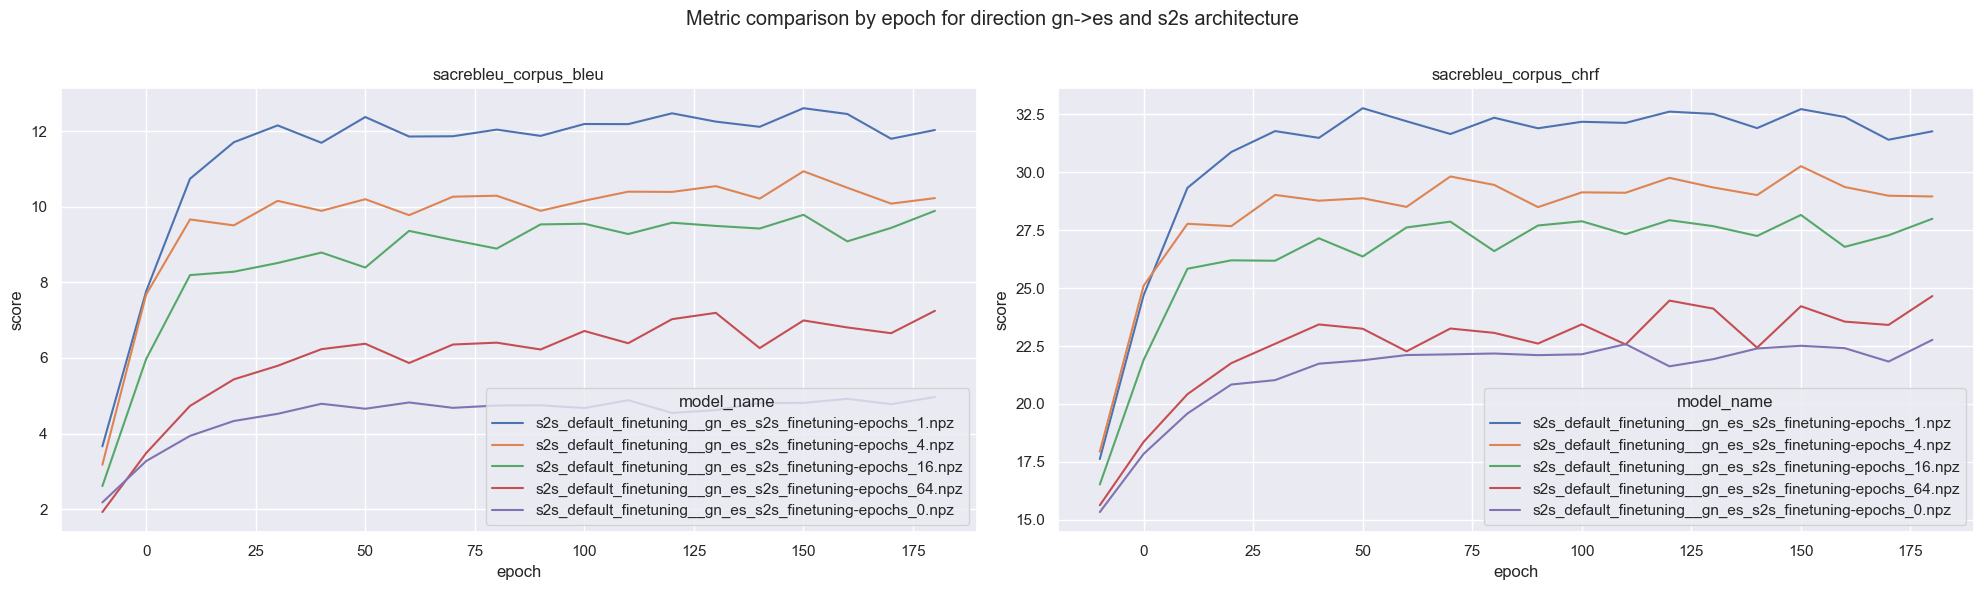

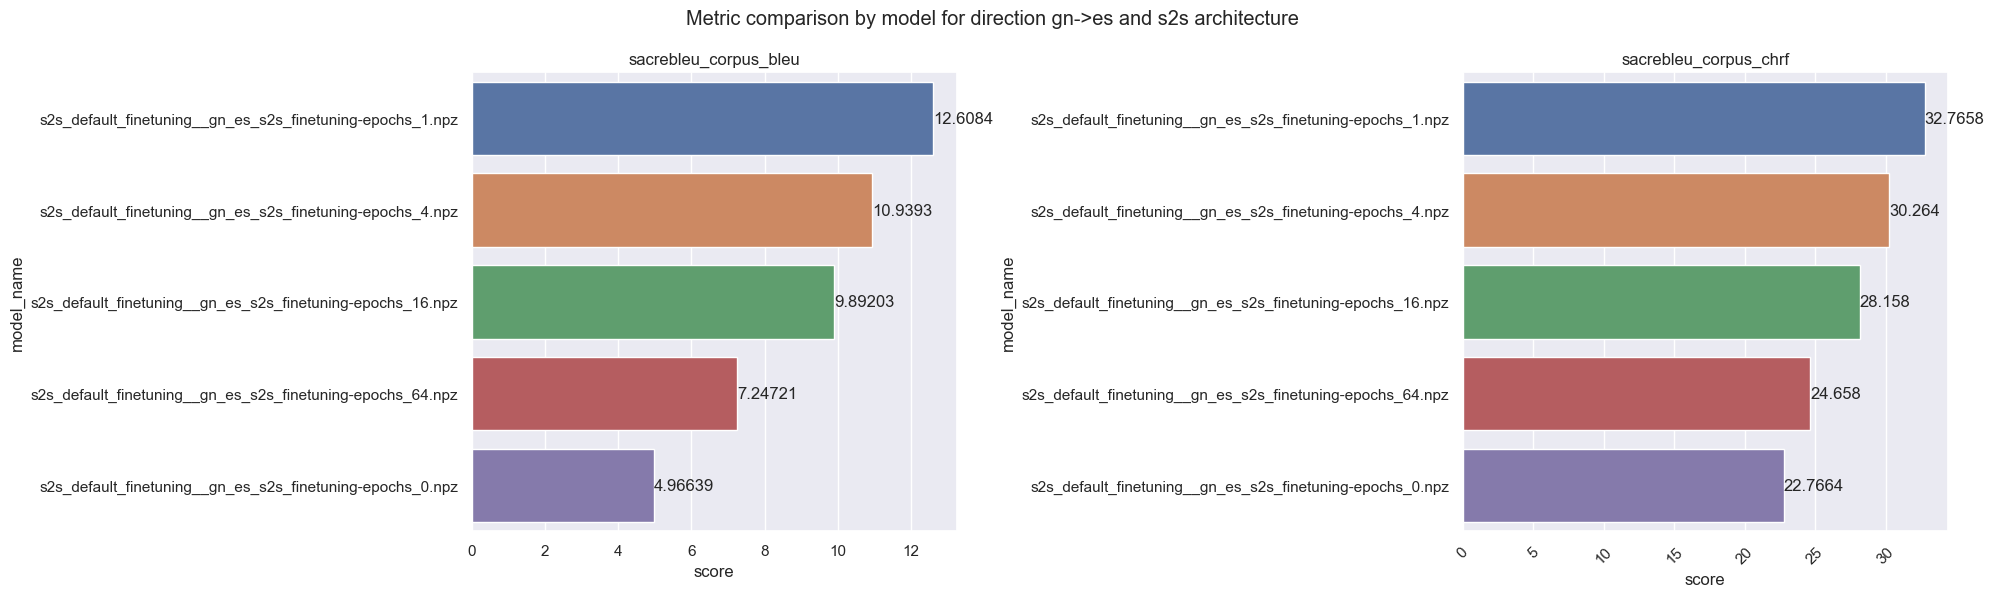

In [137]:
plots.plot_metric_by_epoch_foreach_model(default_grammar_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_grammar_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **S2S (ES -> GN)** 

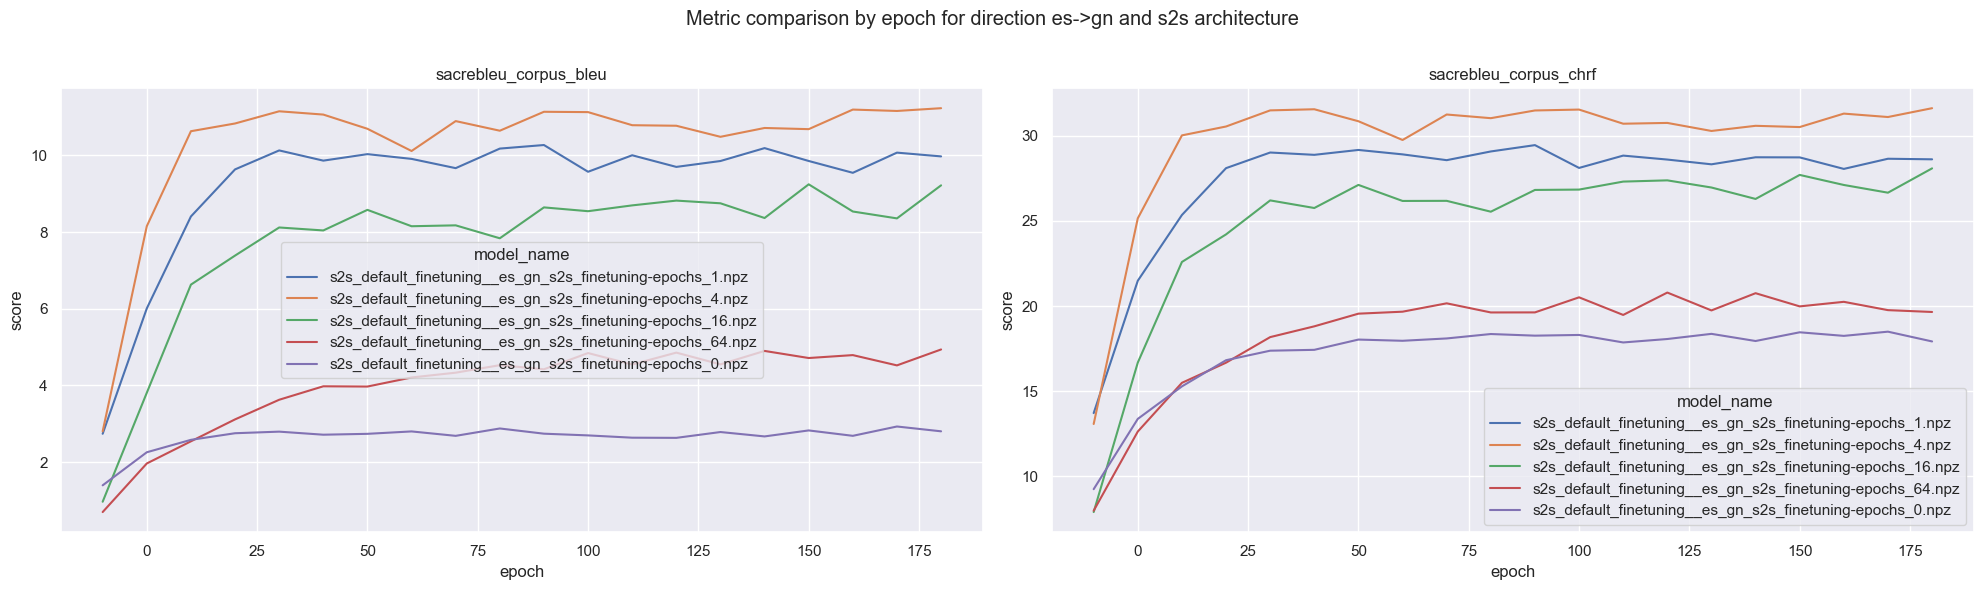

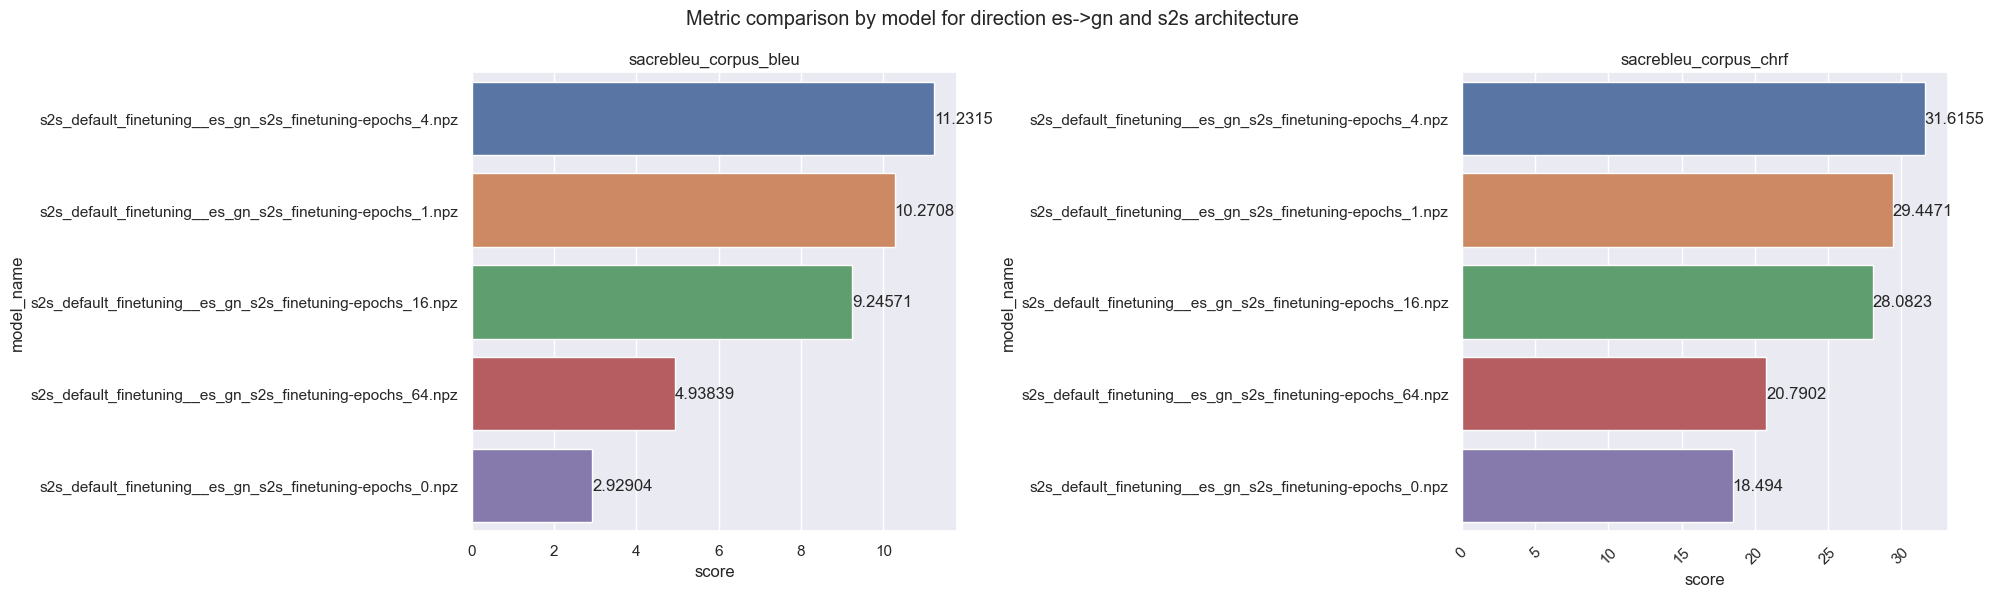

In [138]:
plots.plot_metric_by_epoch_foreach_model(default_grammar_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_grammar_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (GN -> ES)** 

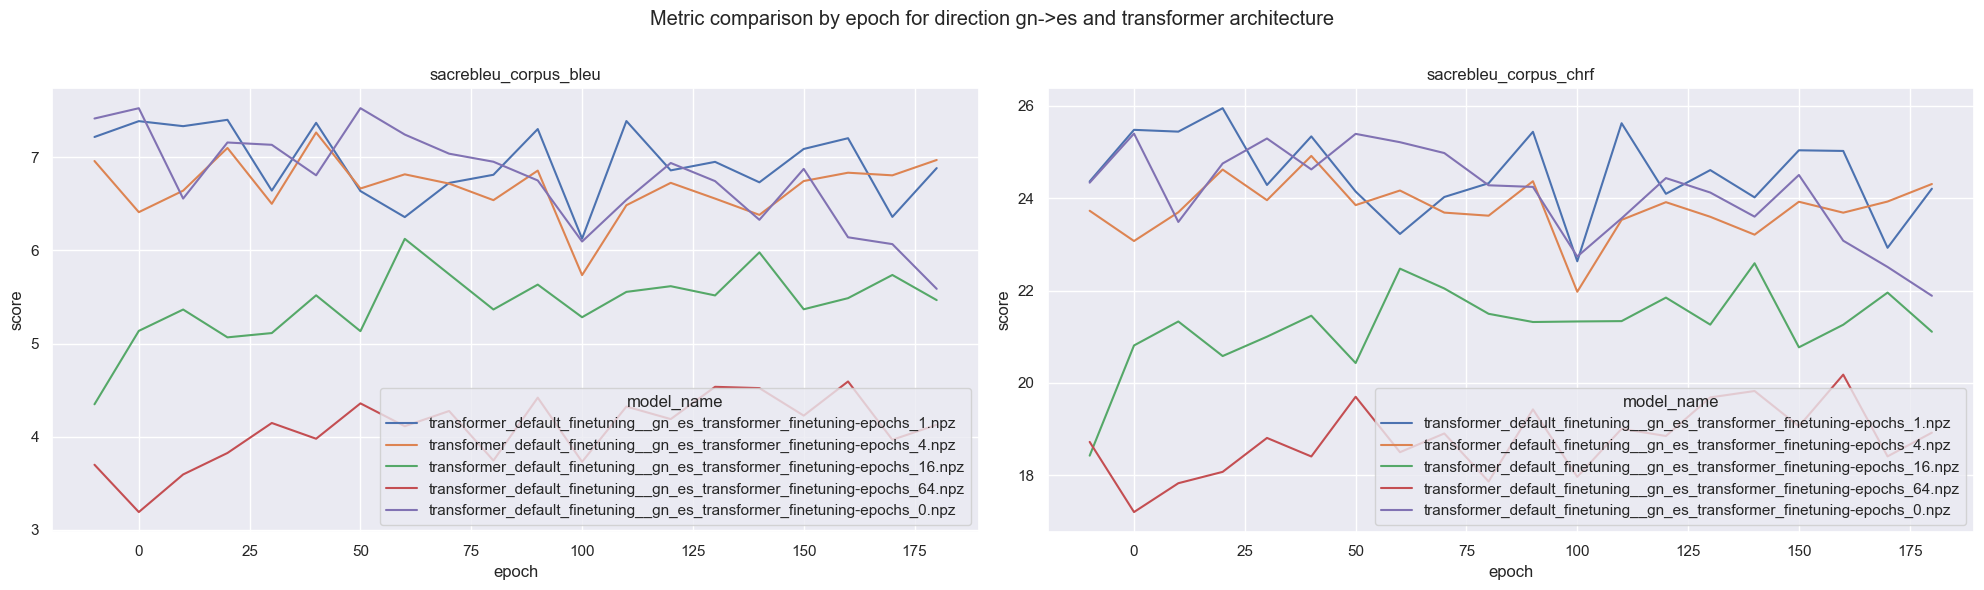

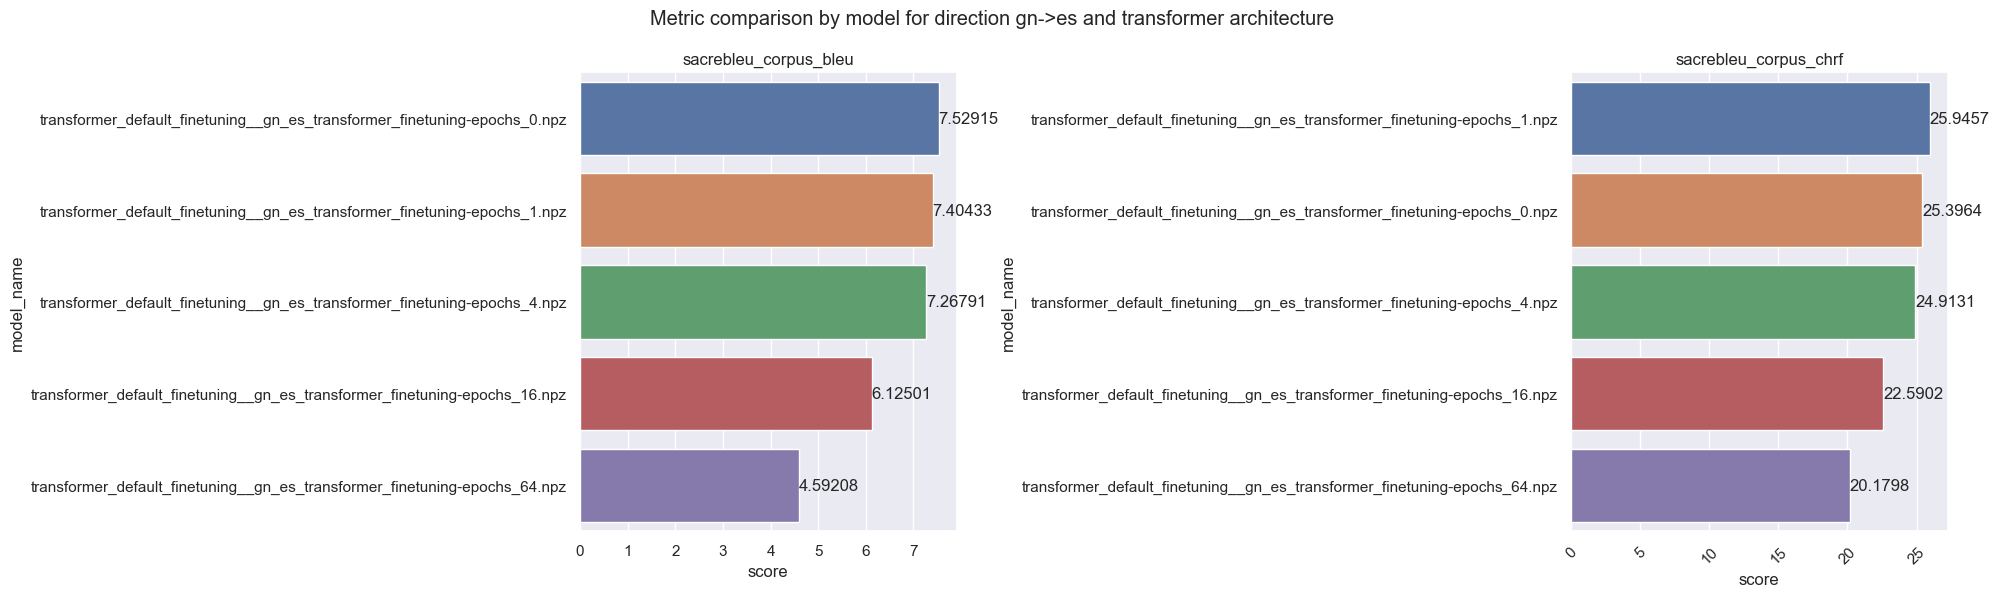

In [139]:
plots.plot_metric_by_epoch_foreach_model(default_grammar_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_grammar_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (ES -> GN)** 

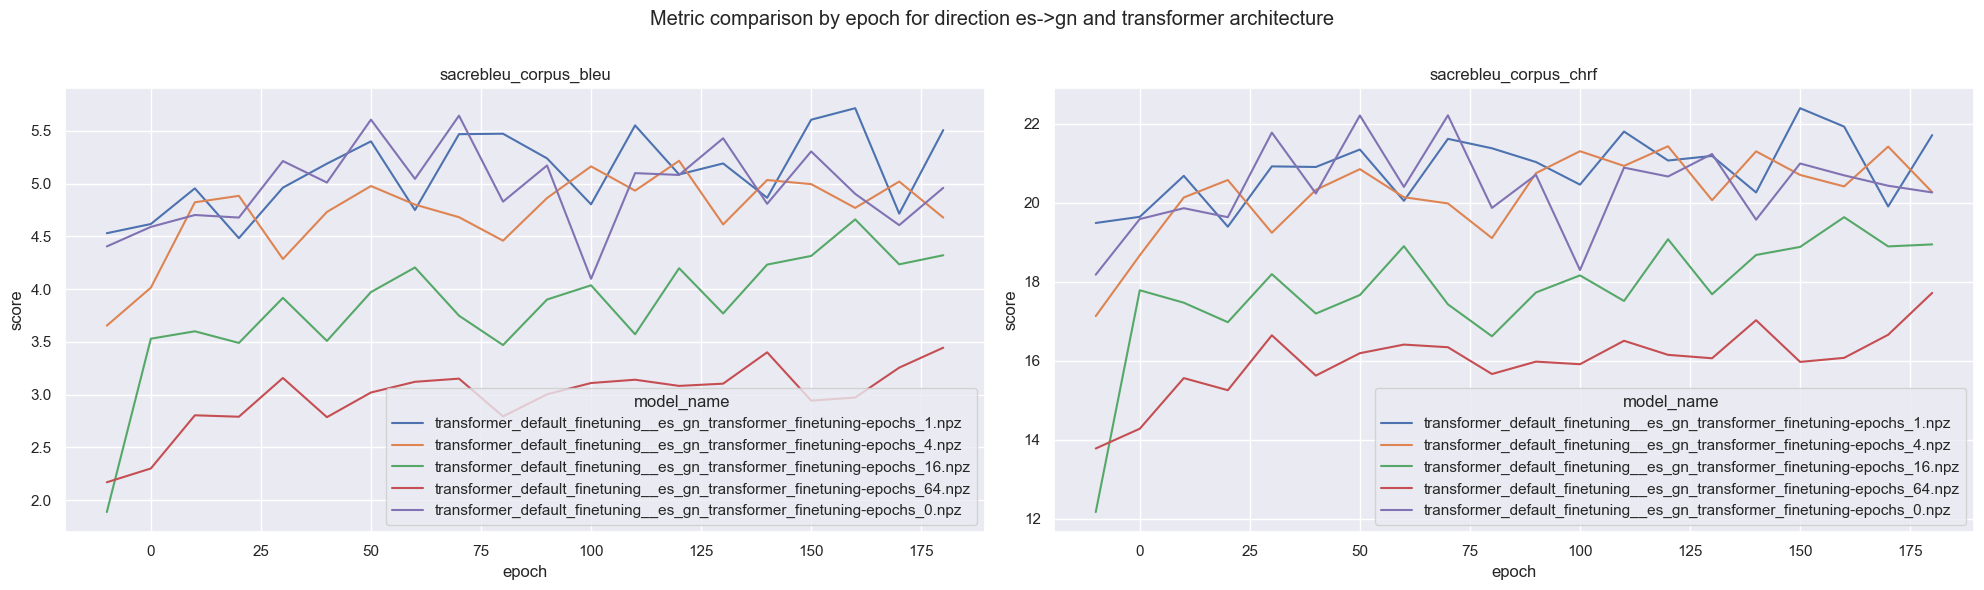

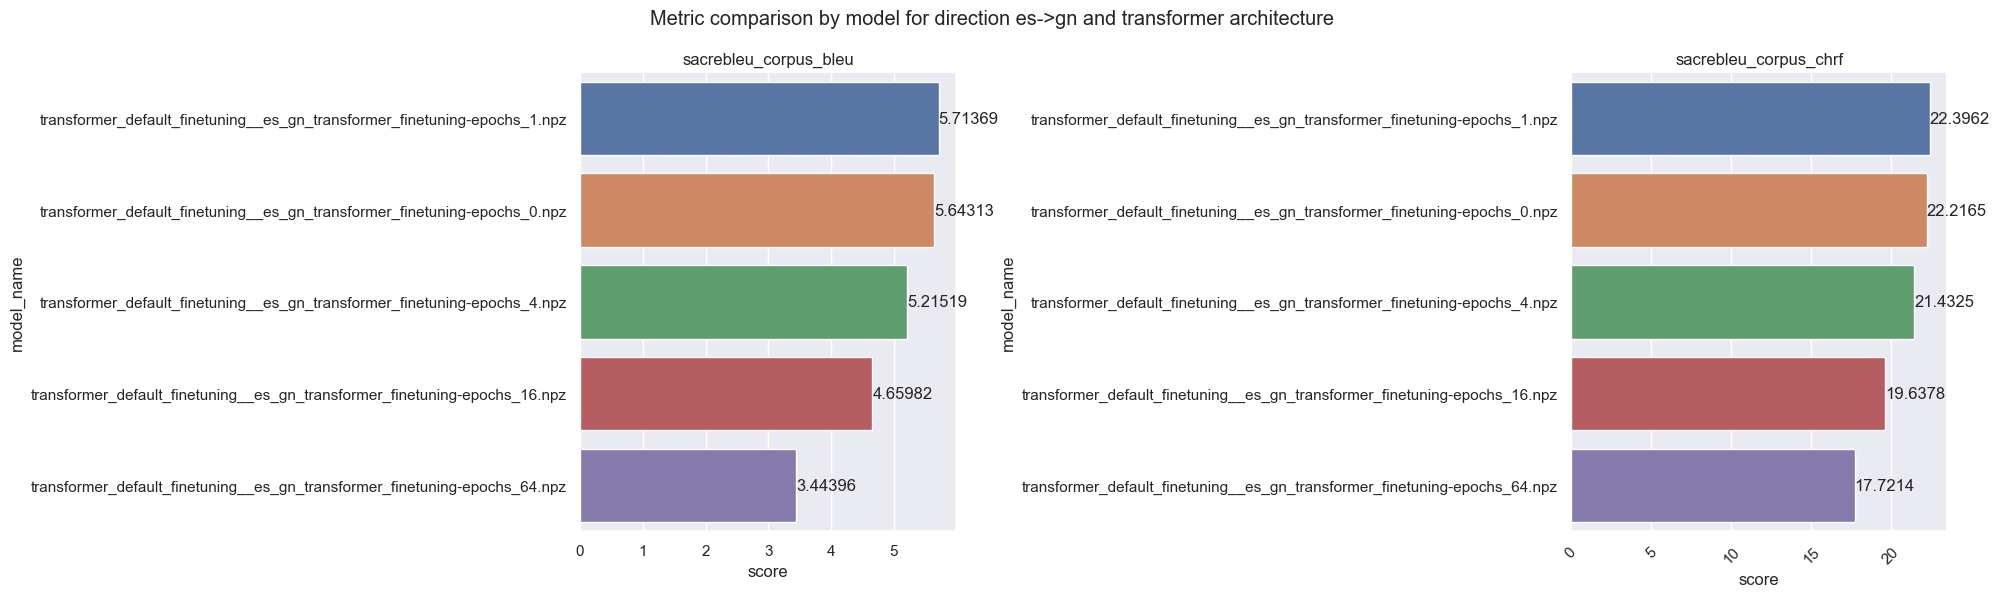

In [140]:
plots.plot_metric_by_epoch_foreach_model(default_grammar_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_grammar_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **Summary:**

<Axes: xlabel='epoch', ylabel='score'>

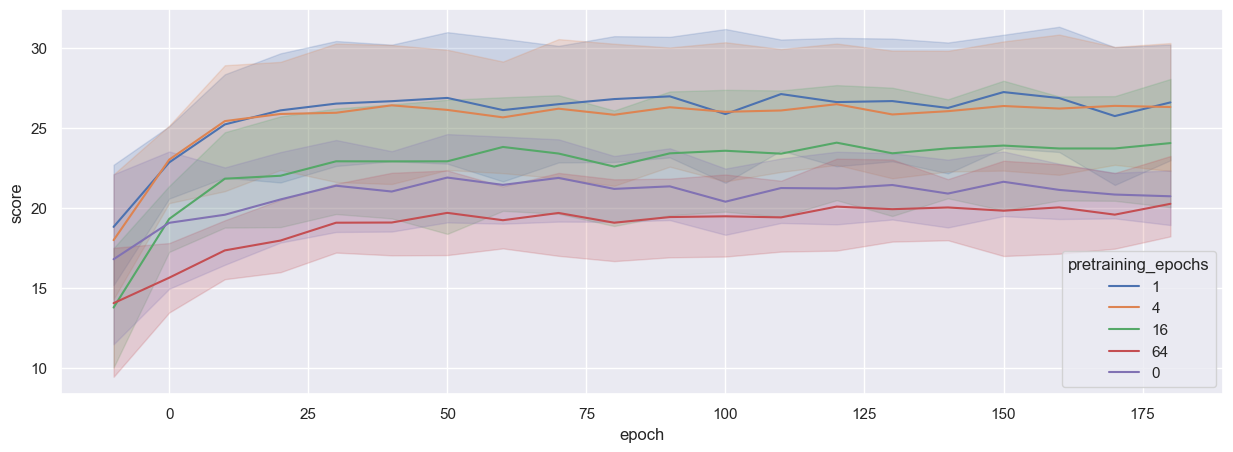

In [141]:
import seaborn as sns; import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(results_grammar_df[results_grammar_df['score_type']=='sacrebleu_corpus_chrf'], x='epoch', y='score', hue='pretraining_epochs', ax=ax)

In [142]:
best_epoch_df = results_grammar_df.groupby(['model_name', 'source', 'target', 'score_type'])['score'].max().reset_index()
best_epoch_df['model_type'] = best_epoch_df['model_name'].str.extract(r'^([a-z2]+)_')
best_epoch_df['pretraining_epochs'] = best_epoch_df['model_name'].str.extract(r'^.*finetuning-epochs_([0-9]+)\.npz')
best_epoch_df

results_rank = best_epoch_df.groupby(['model_type', 'source', 'target', 'score_type'])['score'].rank(method='average', ascending=False)
best_epoch_df['rank'] = results_rank

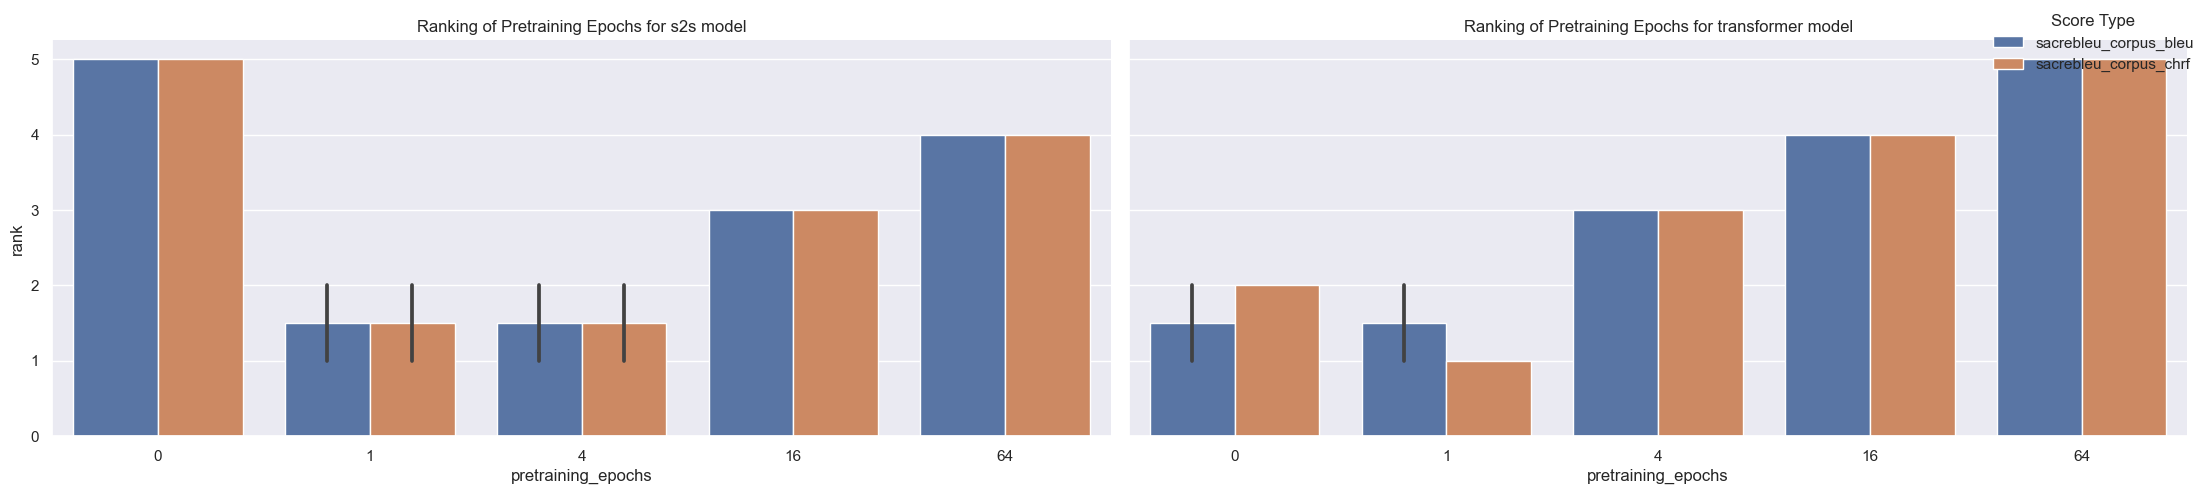

In [143]:
sns.set(style="darkgrid")

g = sns.catplot(
    data=best_epoch_df, y='rank', x='pretraining_epochs',
    hue='score_type', col='model_type', kind='bar',
    height=5, aspect=2, order=list(map(str, [0, 1, 4, 16, 64])),
    legend=False
)

g.set_titles('Ranking of Pretraining Epochs for {col_name} model')
g.add_legend(title='Score Type', loc='upper right')
plt.tight_layout()
plt.show()

#### **1.2. Tuning Pretraining**

In [144]:
pretrained_results_df = pd.read_csv(PRETRAINED_RESULTS_SYNTAX_GRAMMAR_CSV)
finetuned_results_df = pd.read_csv(FINETUNED_RESULTS_CSV)
pretrained_results_df = pd.concat([pretrained_results_df, finetuned_results_df], axis=0)

pretrained_results_df = shift_epochs_from_epoch(pretrained_results_df, from_=10)
finetuned_results_df = shift_epochs_from_epoch(finetuned_results_df, from_=10)

pretrained_results_df['date'] = pd.to_datetime(pretrained_results_df['date'])
pretrained_results_df['pretraining_epochs'] = pretrained_results_df['model_name'].str.extract(r'^.*finetuning-epochs_([0-9]+)')
pretrained_results_df['pretraining_epochs'] = pretrained_results_df['pretraining_epochs'].fillna(0).astype(str)


In [145]:
pretrained_s2s_gn_es_df = filter_df_by_model(pretrained_results_df, 's2s', 'gn')
pretrained_s2s_es_gn_df = filter_df_by_model(pretrained_results_df, 's2s', 'es')
pretrained_transformer_gn_es_df = filter_df_by_model(pretrained_results_df, 'transformer', 'gn')
pretrained_transformer_es_gn_df = filter_df_by_model(pretrained_results_df, 'transformer', 'es')

##### **S2S (GN -> ES)** 

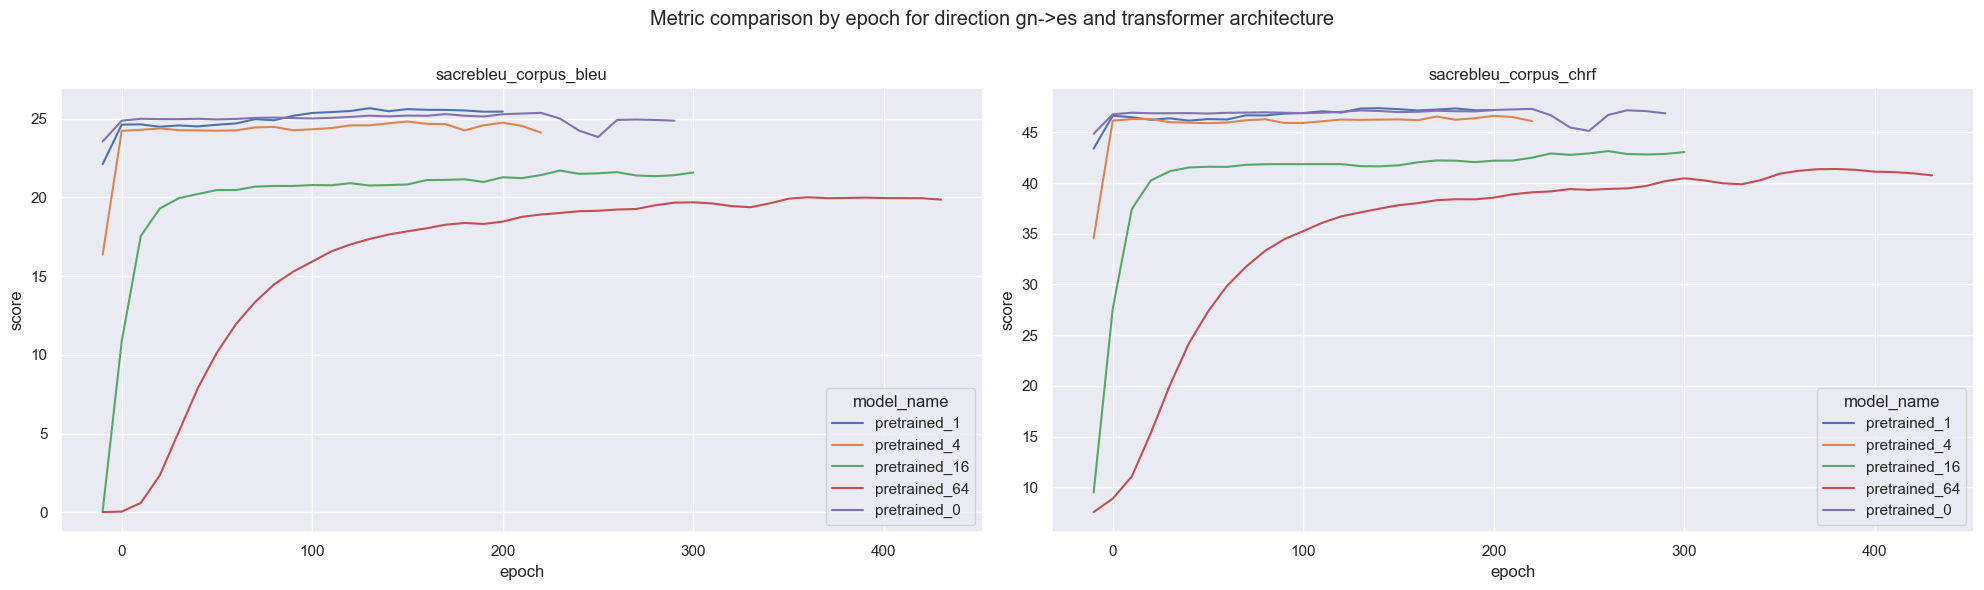

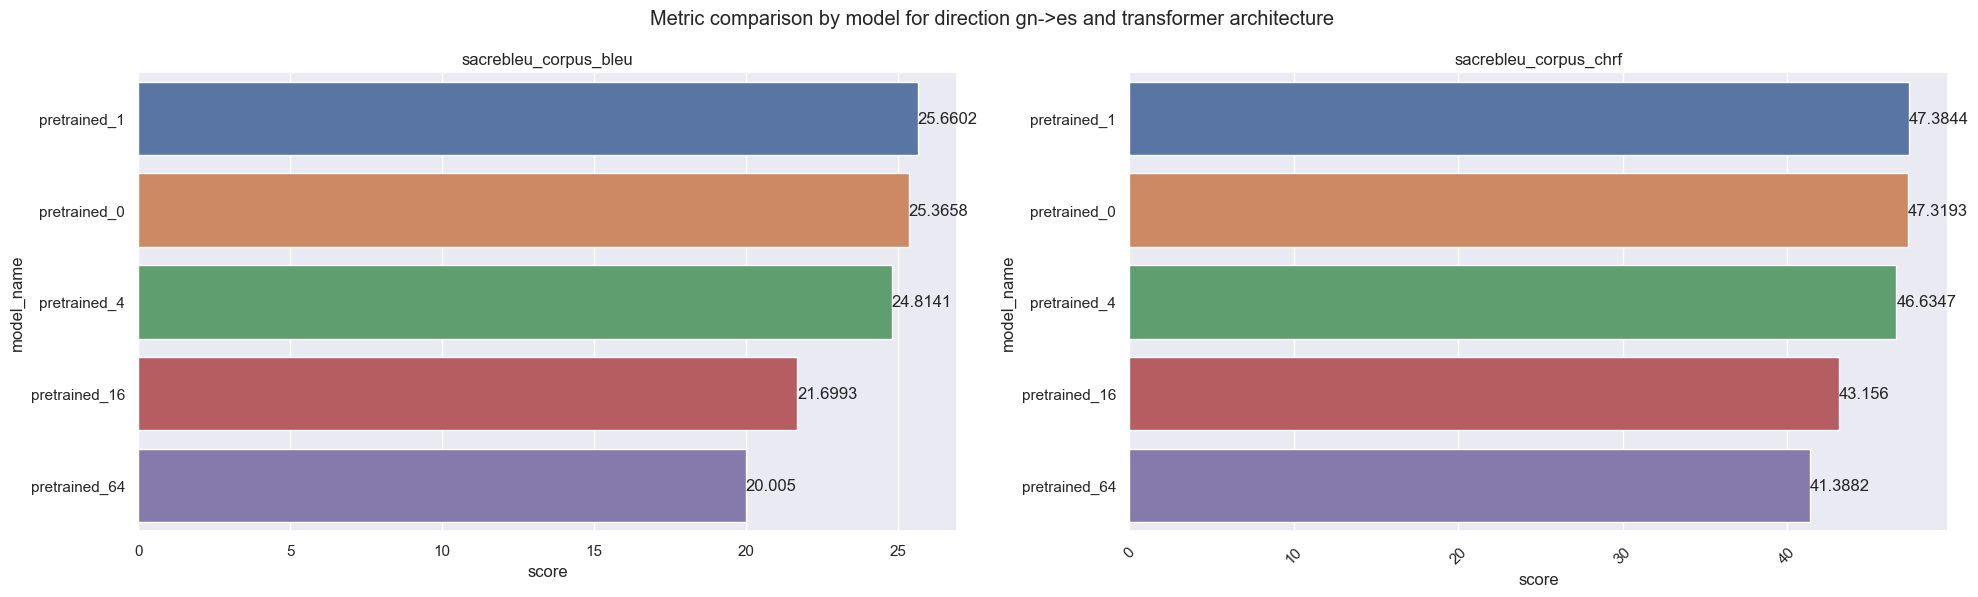

In [146]:
pretrained_s2s_gn_es_df['model_name'] = list(map(lambda x: f'pretrained_{x}', pretrained_s2s_gn_es_df['pretraining_epochs'].tolist()))
plots.plot_metric_by_epoch_foreach_model(pretrained_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **S2S (ES -> GN)** 

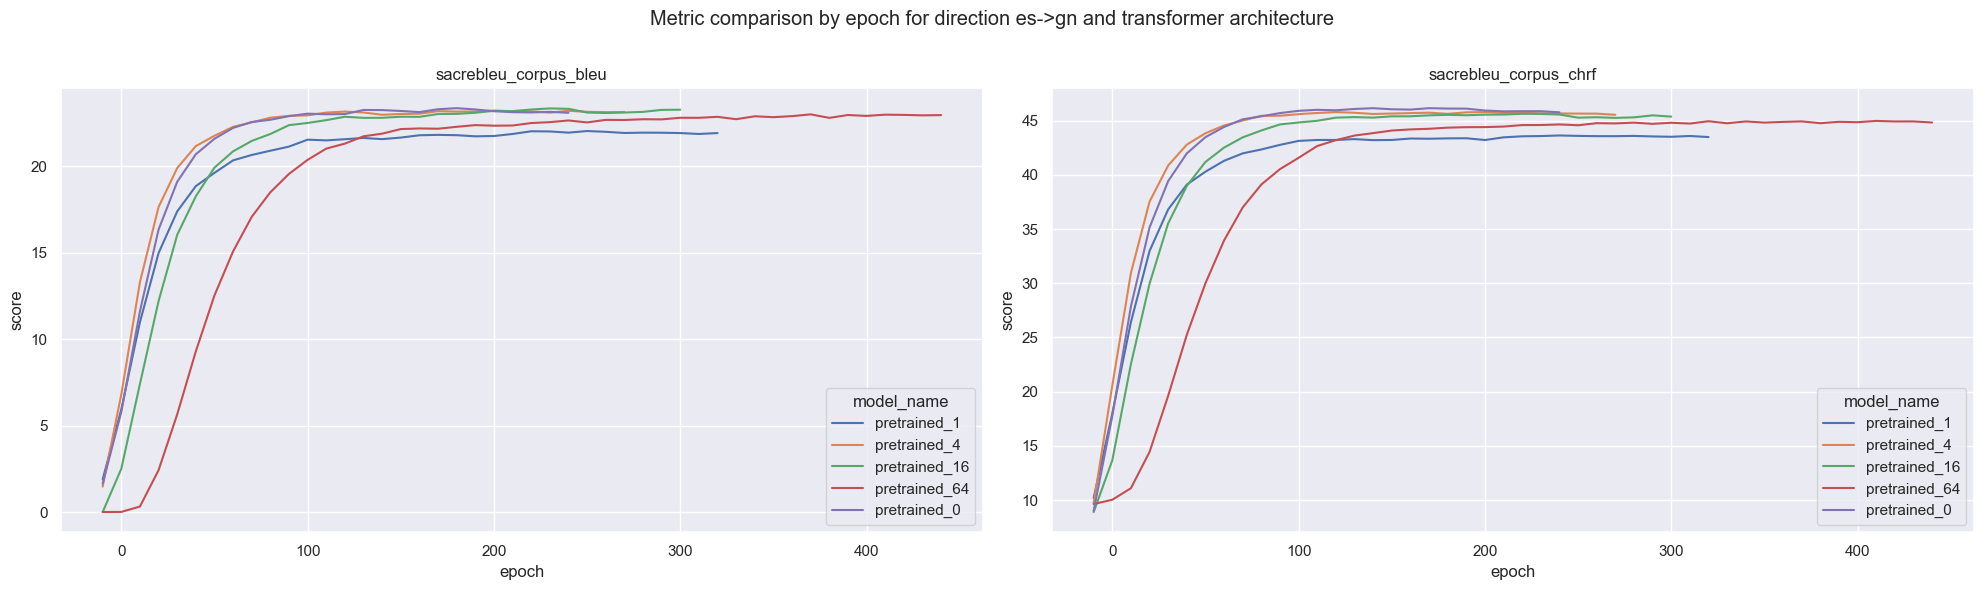

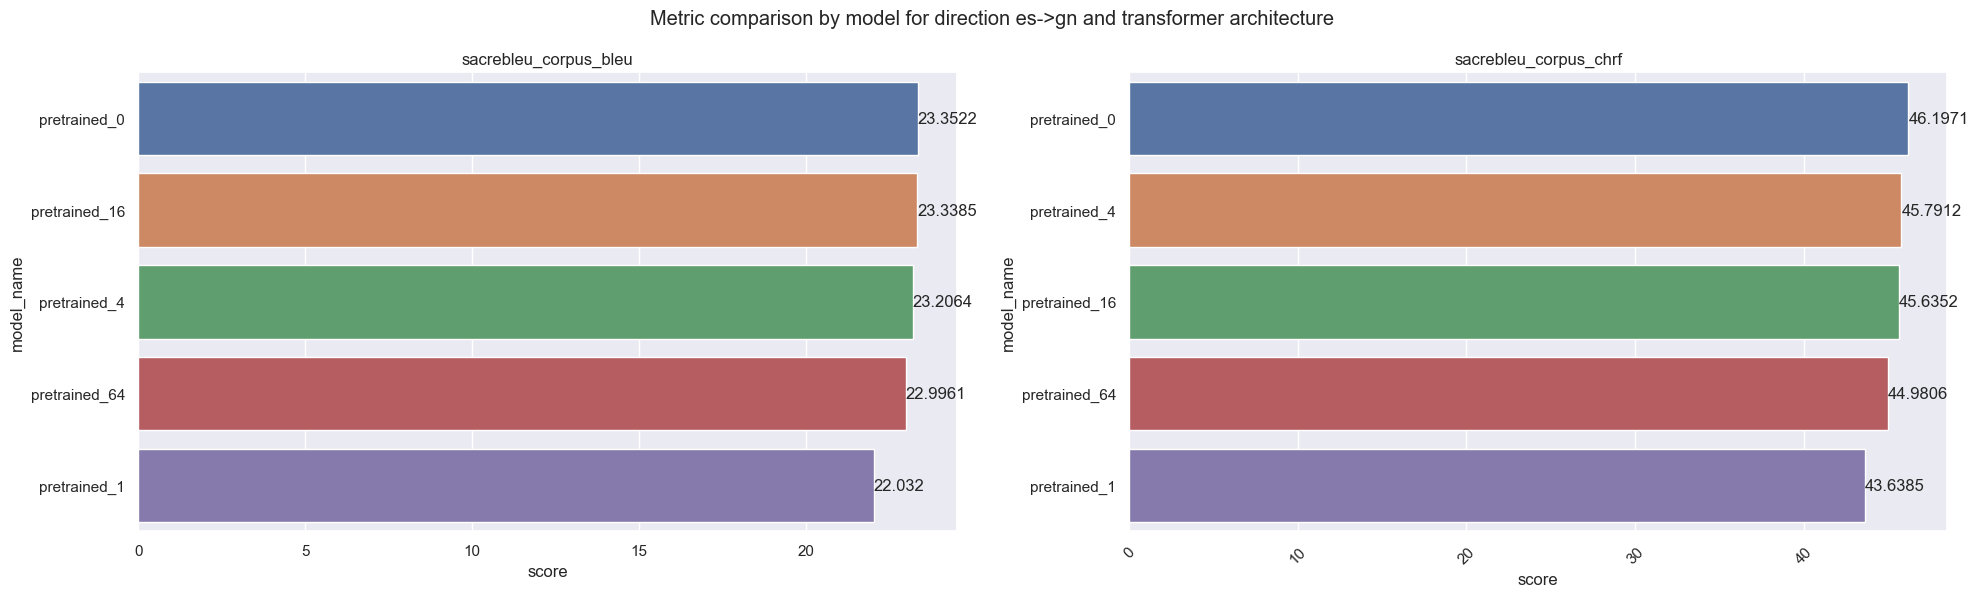

In [147]:
pretrained_s2s_es_gn_df['model_name'] = pretrained_s2s_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (GN -> ES)** 

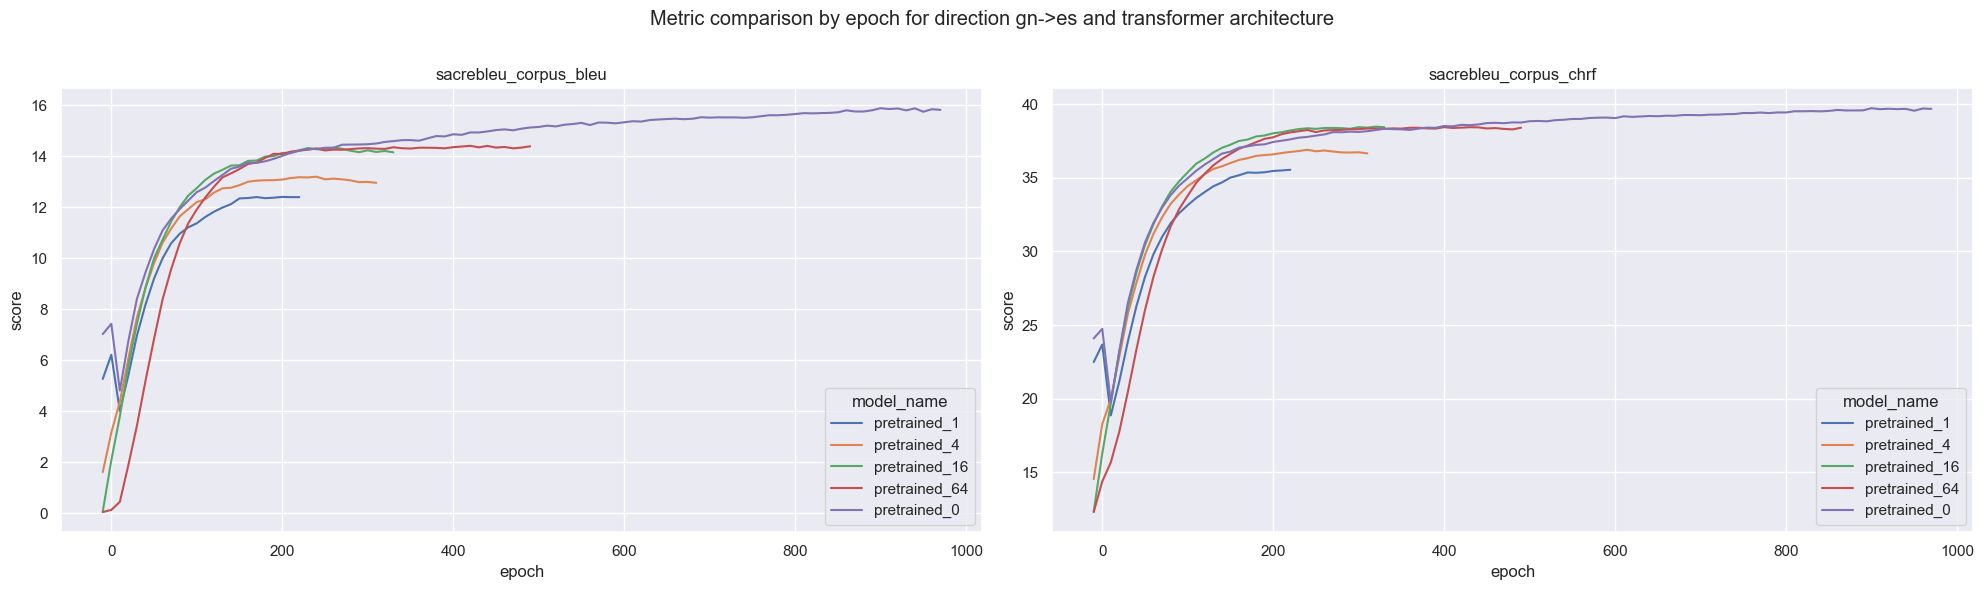

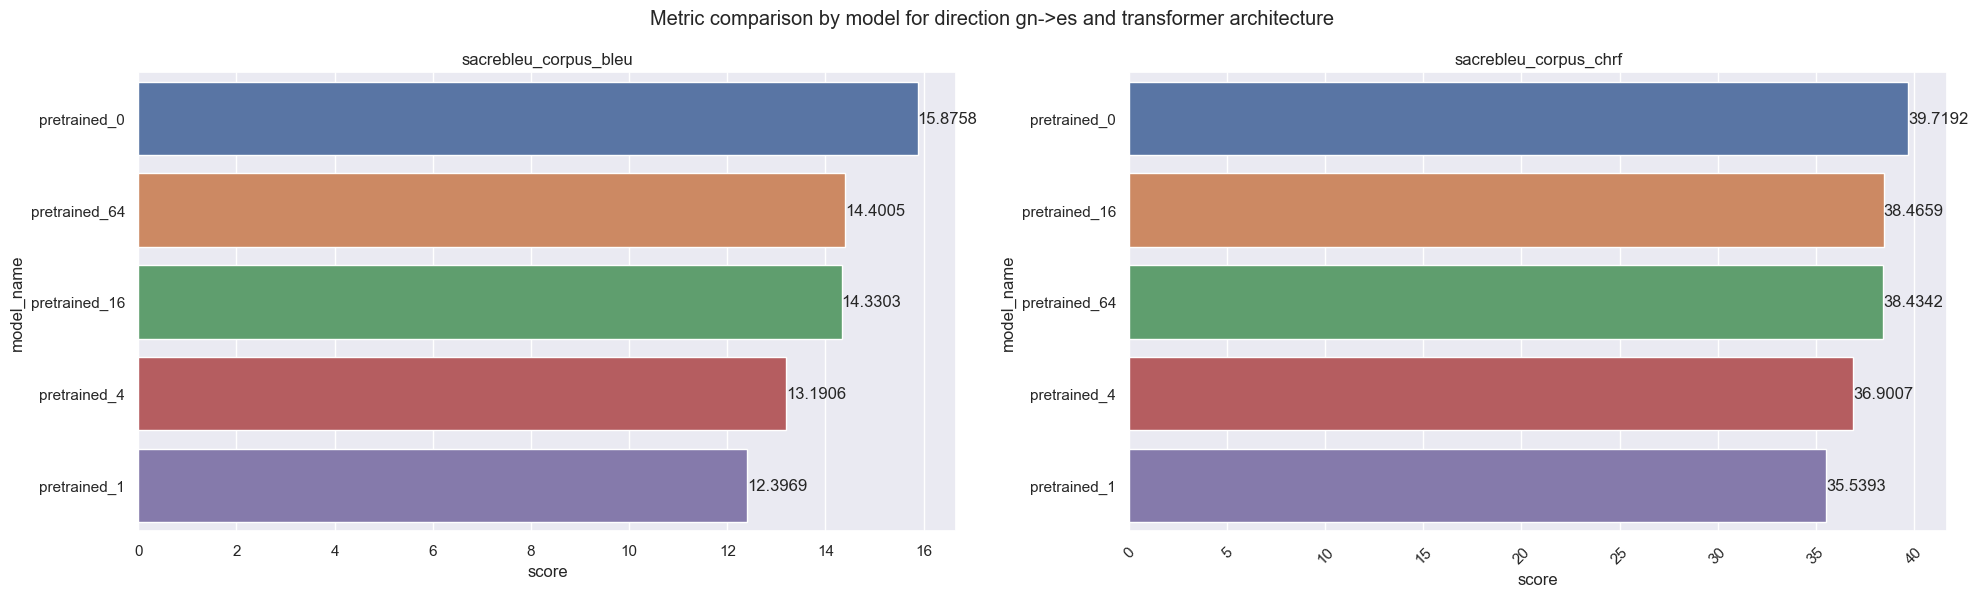

In [148]:
pretrained_transformer_gn_es_df['model_name'] = pretrained_transformer_gn_es_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (ES -> GN)** 

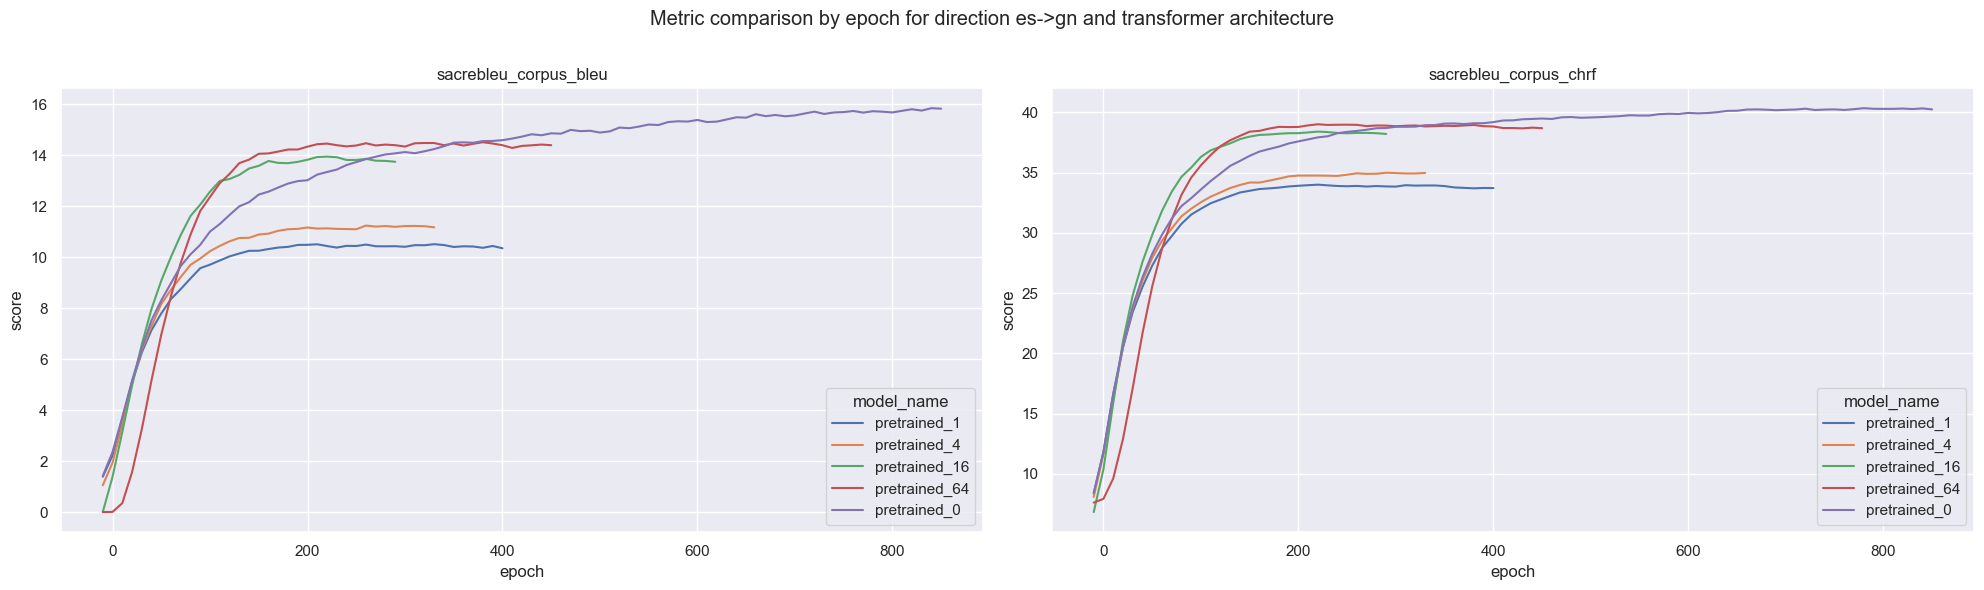

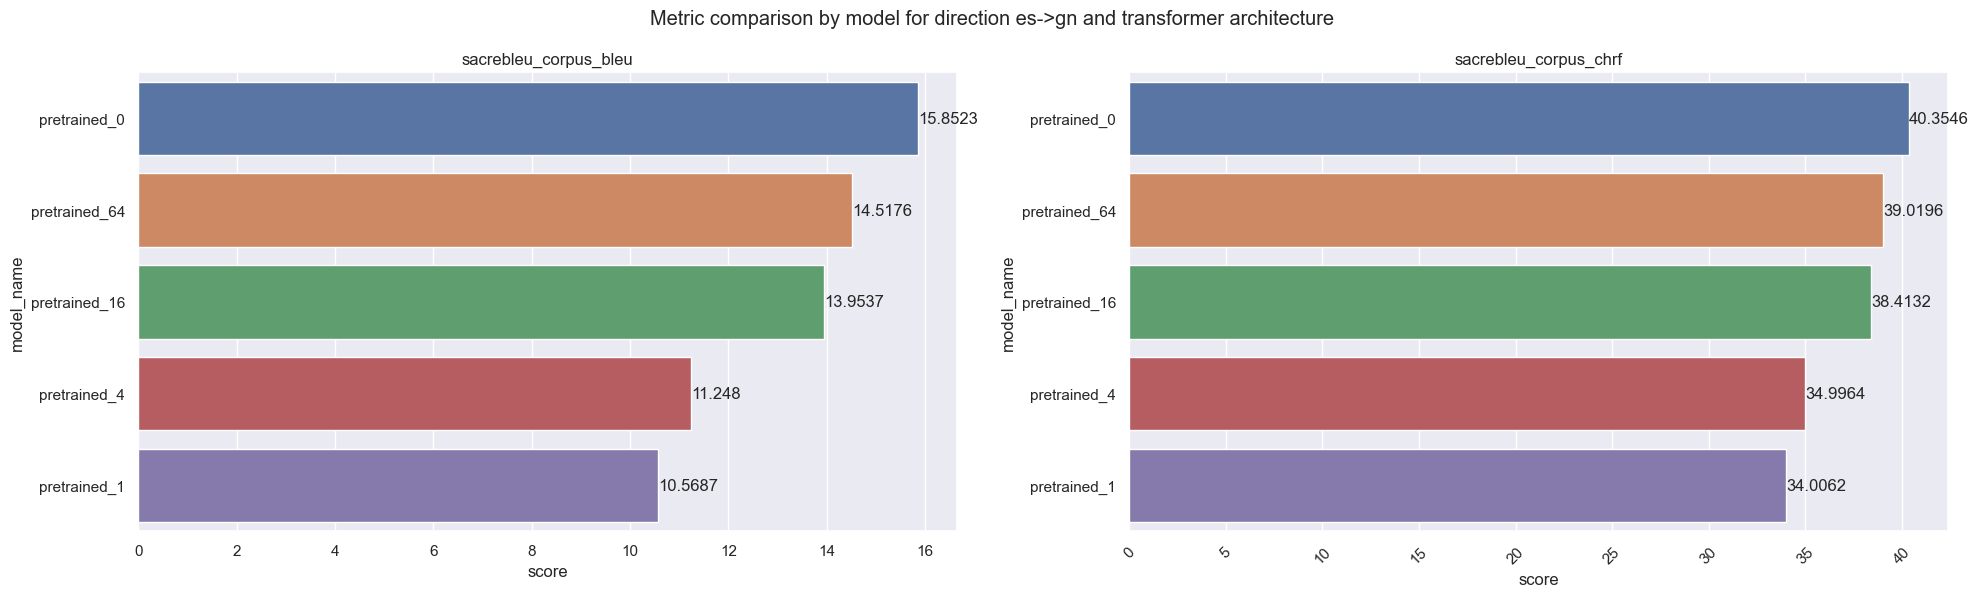

In [149]:
pretrained_transformer_es_gn_df['model_name'] = pretrained_transformer_es_gn_df['pretraining_epochs'].map(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

### **2. The Holy Guarani Bible ⛪🛐**

#### **2.1. Default Pretraining**

In [150]:
DEFAULT_RESULTS_BIBLE_CSV = os.path.join(PRETRAINING_FOLDER, 'default_pretraining_bible.csv')

In [151]:
results_df = pd.read_csv(DEFAULT_RESULTS_BIBLE_CSV)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df = extract_epochs_from_name(results_df)
results_df = shift_epochs_from_epoch(results_df, from_=10)

In [152]:
results_without_pretraining = results_grammar_df[results_grammar_df['pretraining_epochs']=='0']
results_df = pd.concat([results_df, results_without_pretraining], axis=0)

In [153]:
default_bible_s2s_gn_es_df = filter_df_by_model(results_df, 's2s', 'gn')
default_bible_s2s_es_gn_df = filter_df_by_model(results_df, 's2s', 'es')
default_bible_transformer_gn_es_df = filter_df_by_model(results_df, 'transformer', 'gn')
default_bible_transformer_es_gn_df = filter_df_by_model(results_df, 'transformer', 'es')

##### **S2S (GN -> ES)** 

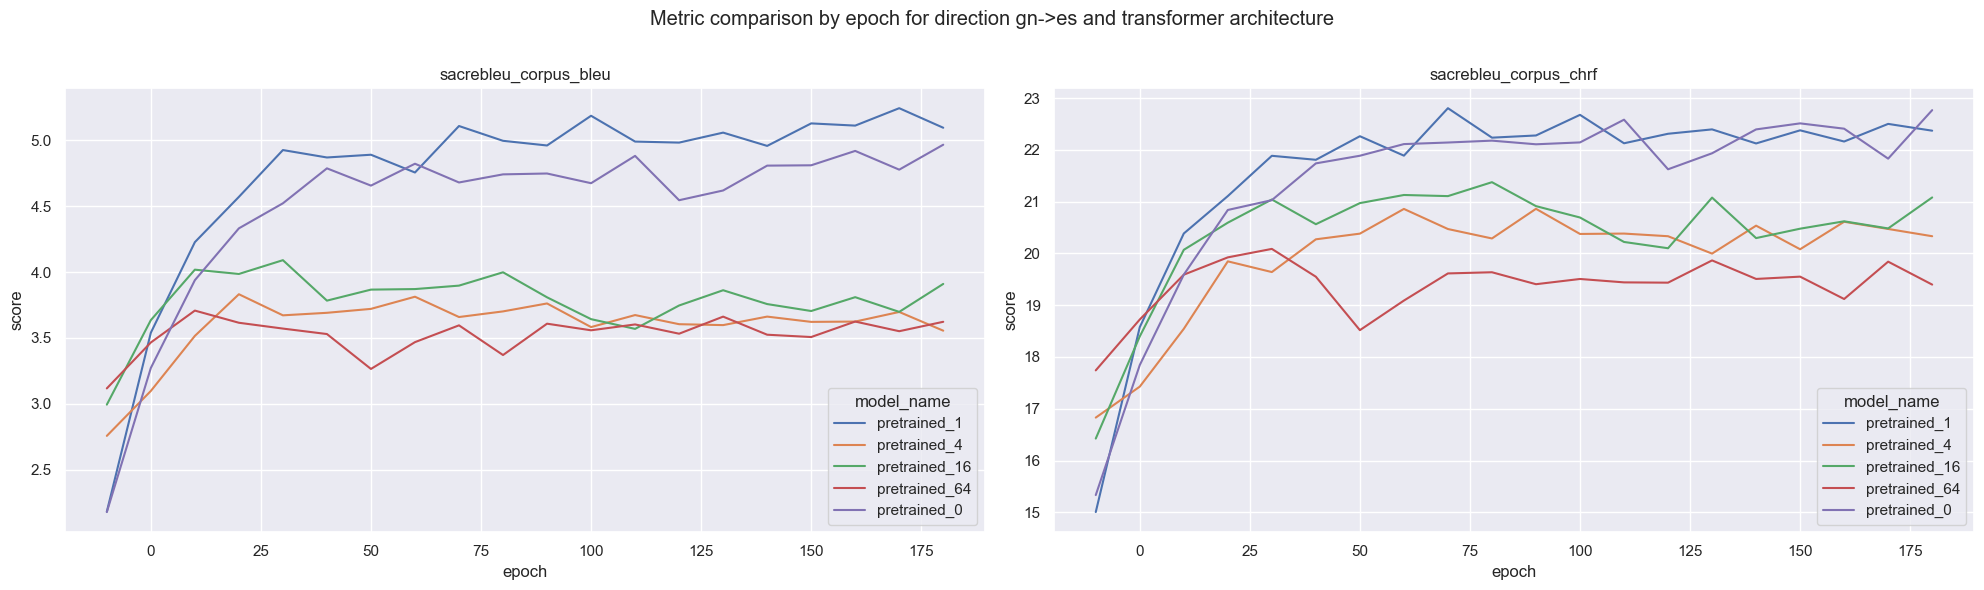

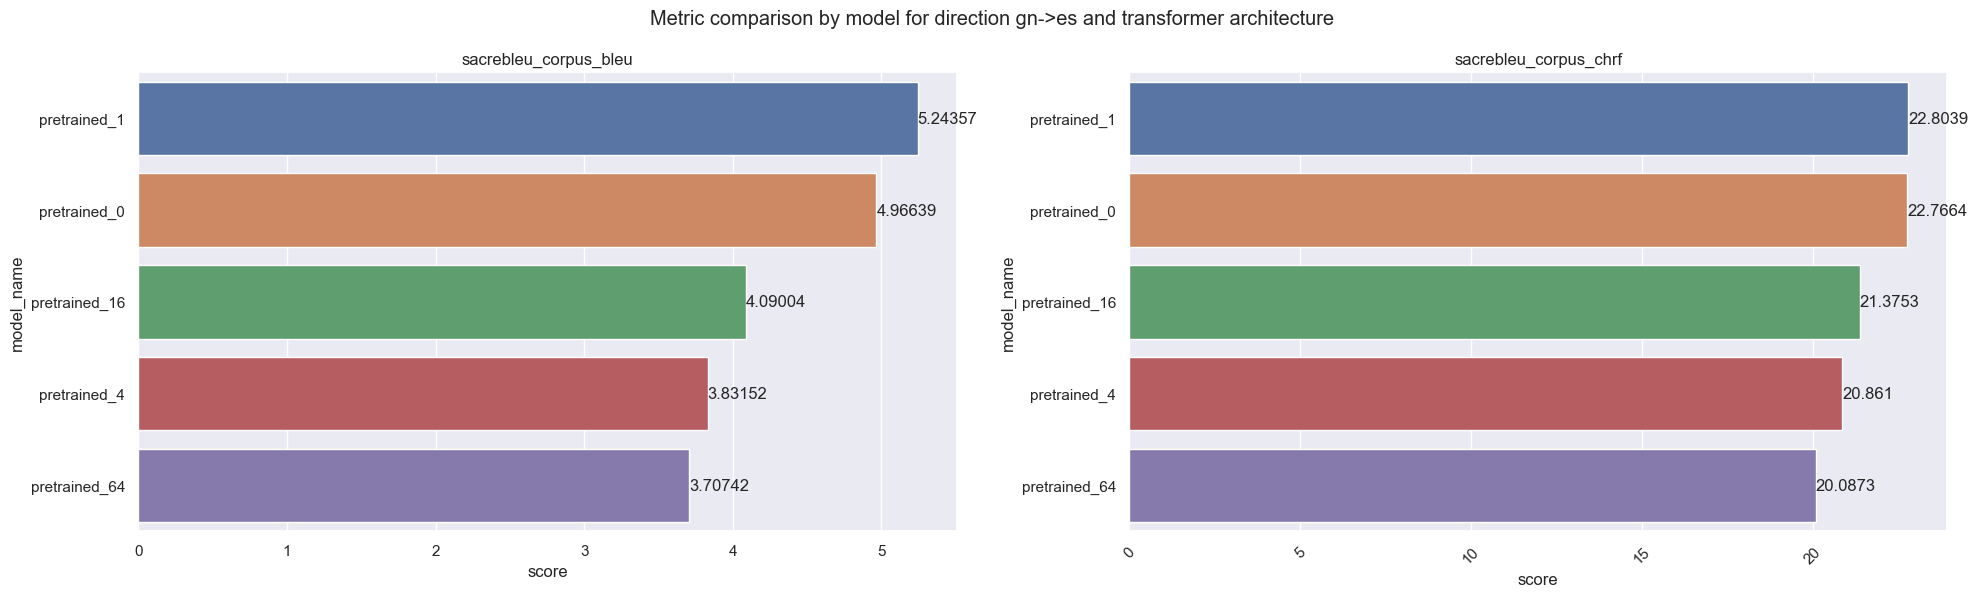

In [154]:
default_bible_s2s_gn_es_df['model_name'] = list(map(lambda x: f'pretrained_{x}', default_bible_s2s_gn_es_df['pretraining_epochs'].tolist()))
plots.plot_metric_by_epoch_foreach_model(default_bible_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_bible_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **S2S (ES -> GN)** 

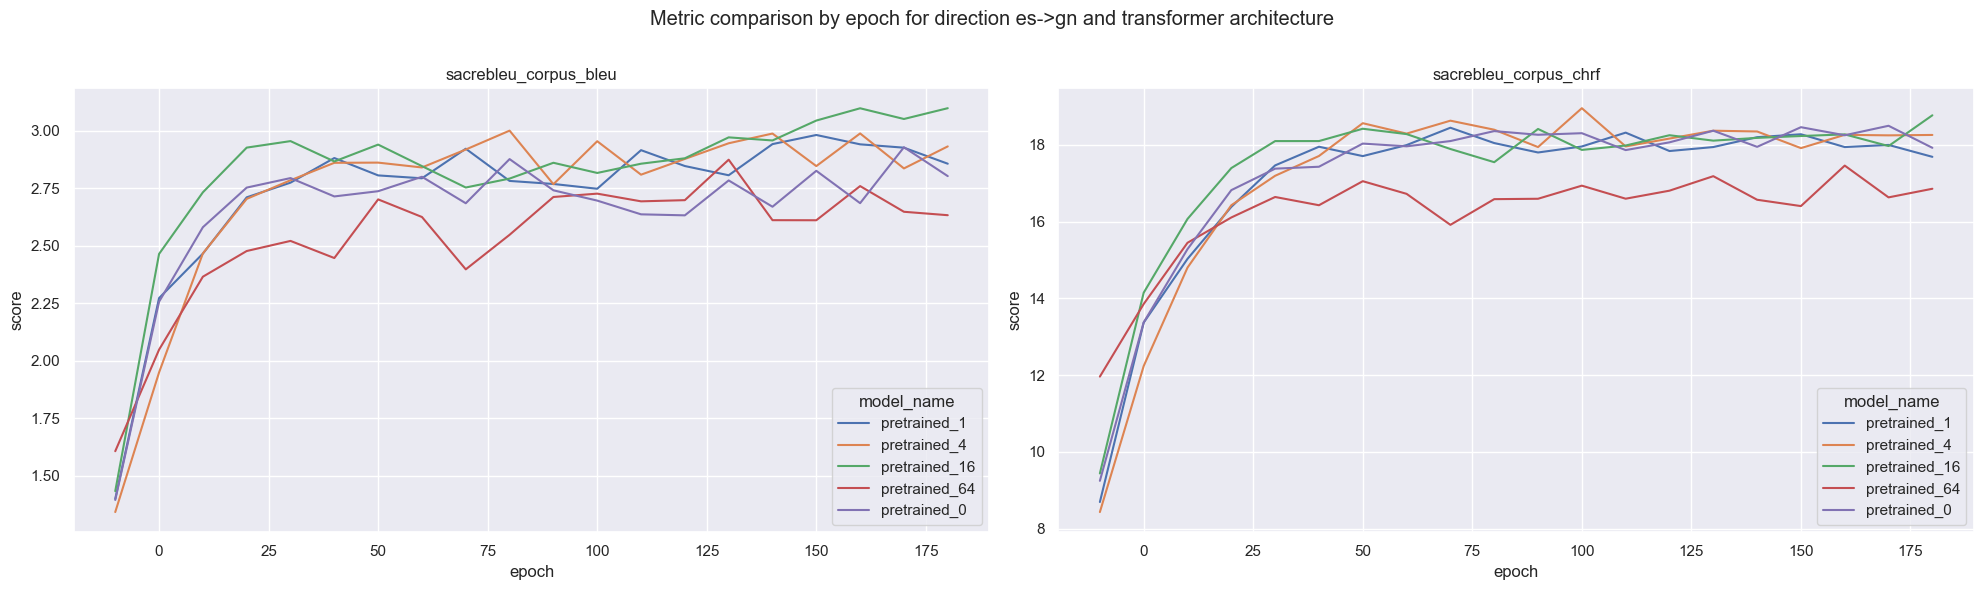

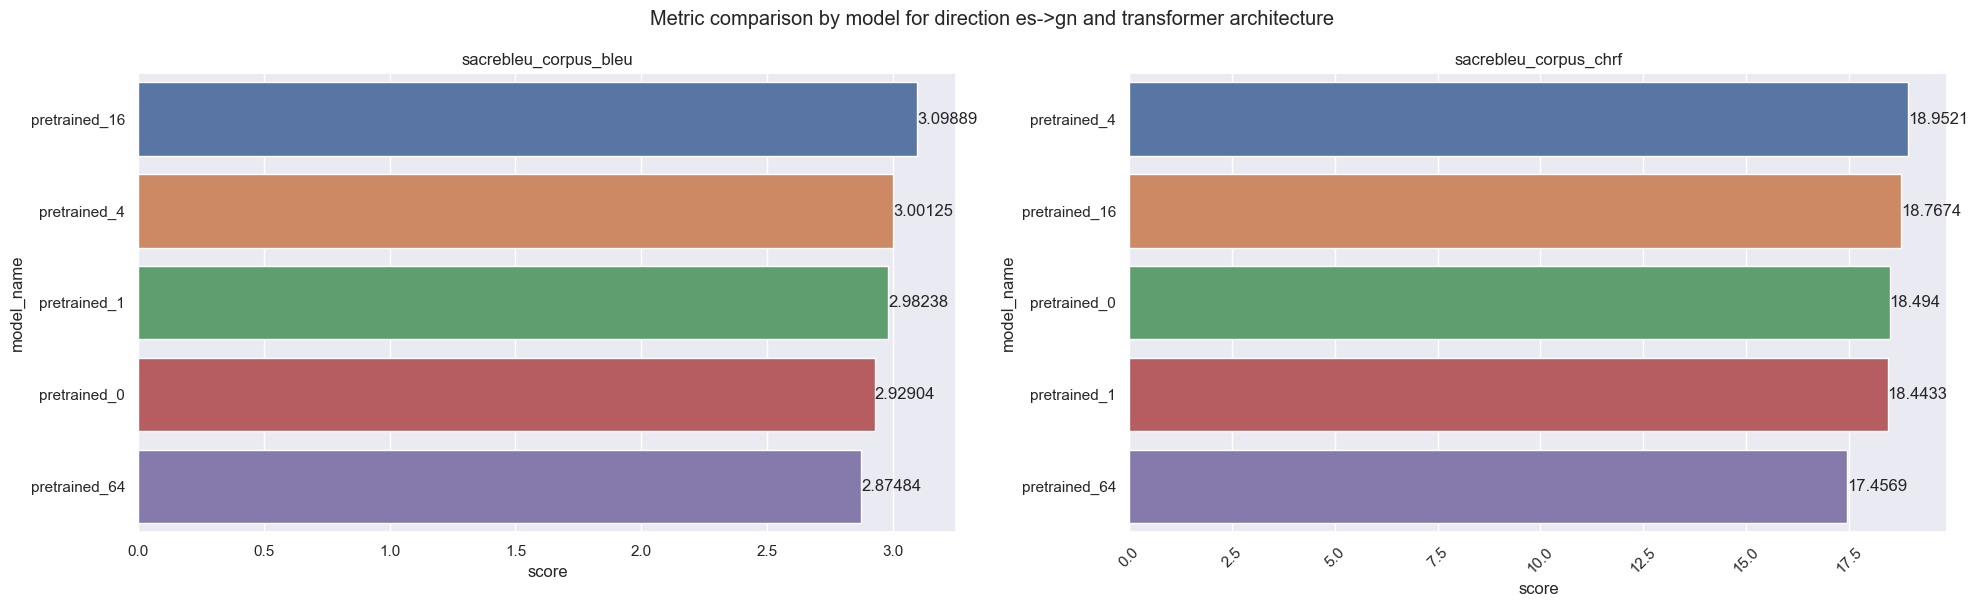

In [155]:
default_bible_s2s_es_gn_df['model_name'] = default_bible_s2s_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(default_bible_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_bible_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (GN -> ES)** 

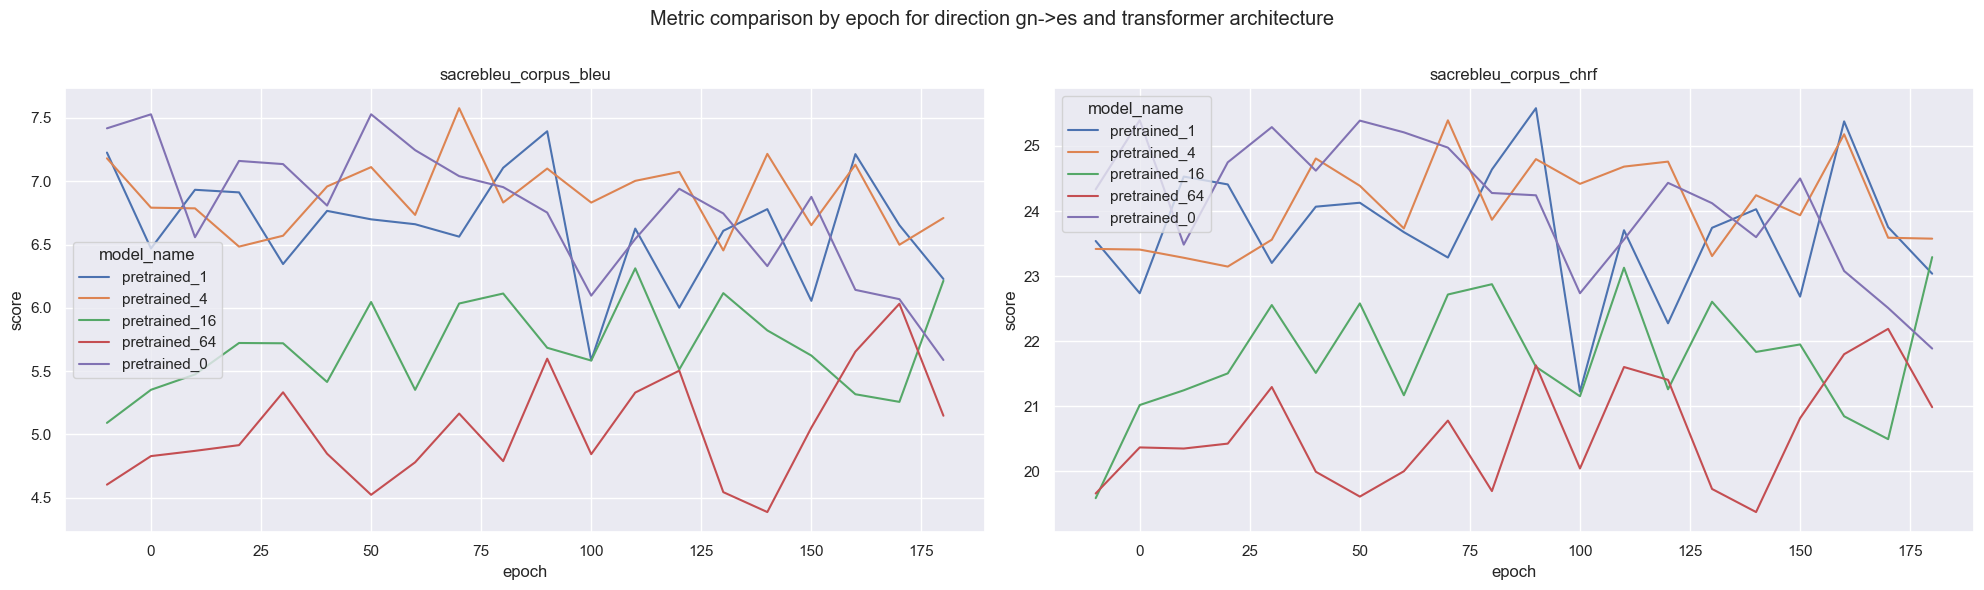

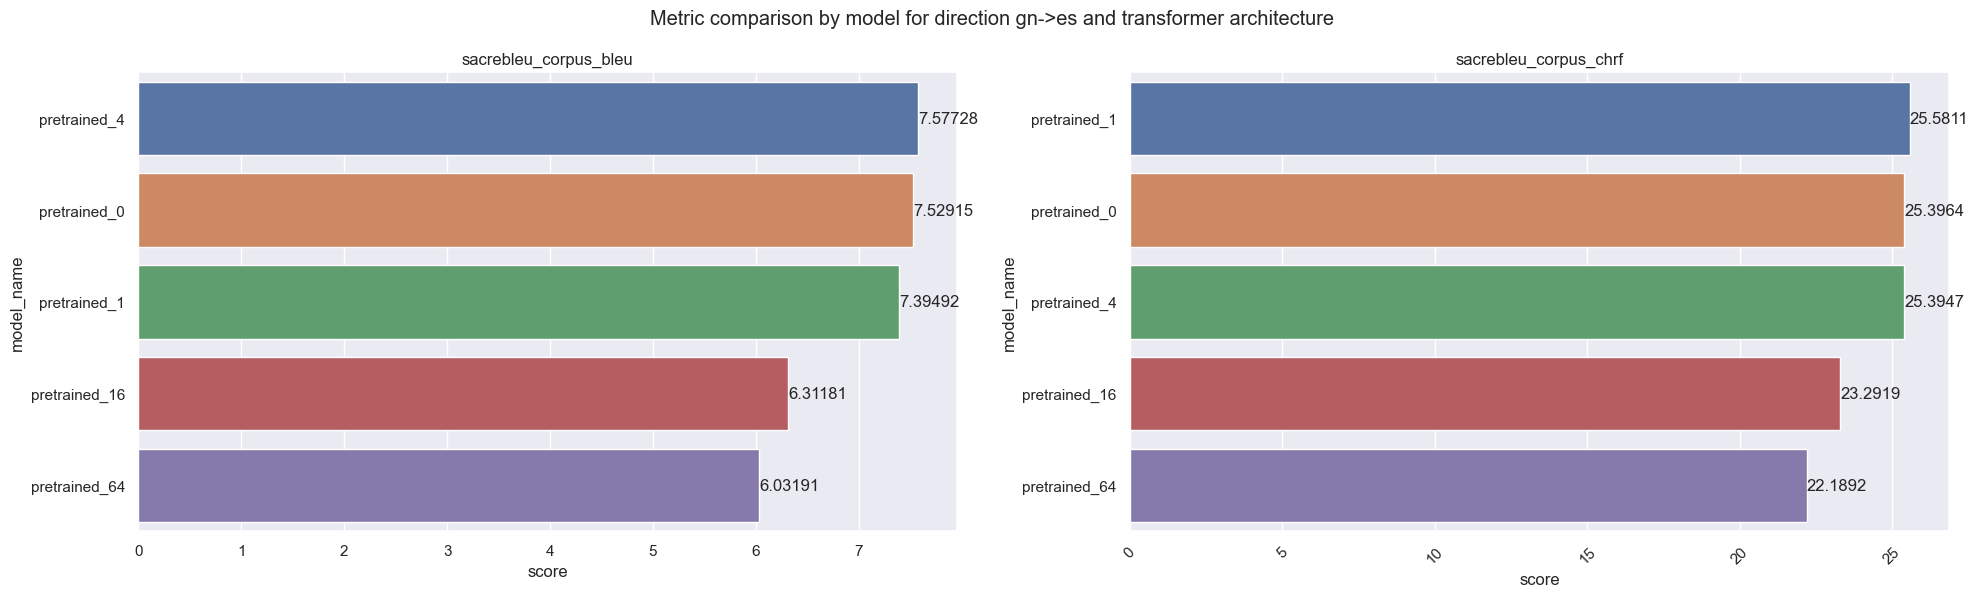

In [156]:
default_bible_transformer_gn_es_df['model_name'] = default_bible_transformer_gn_es_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(default_bible_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_bible_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (ES -> GN)** 

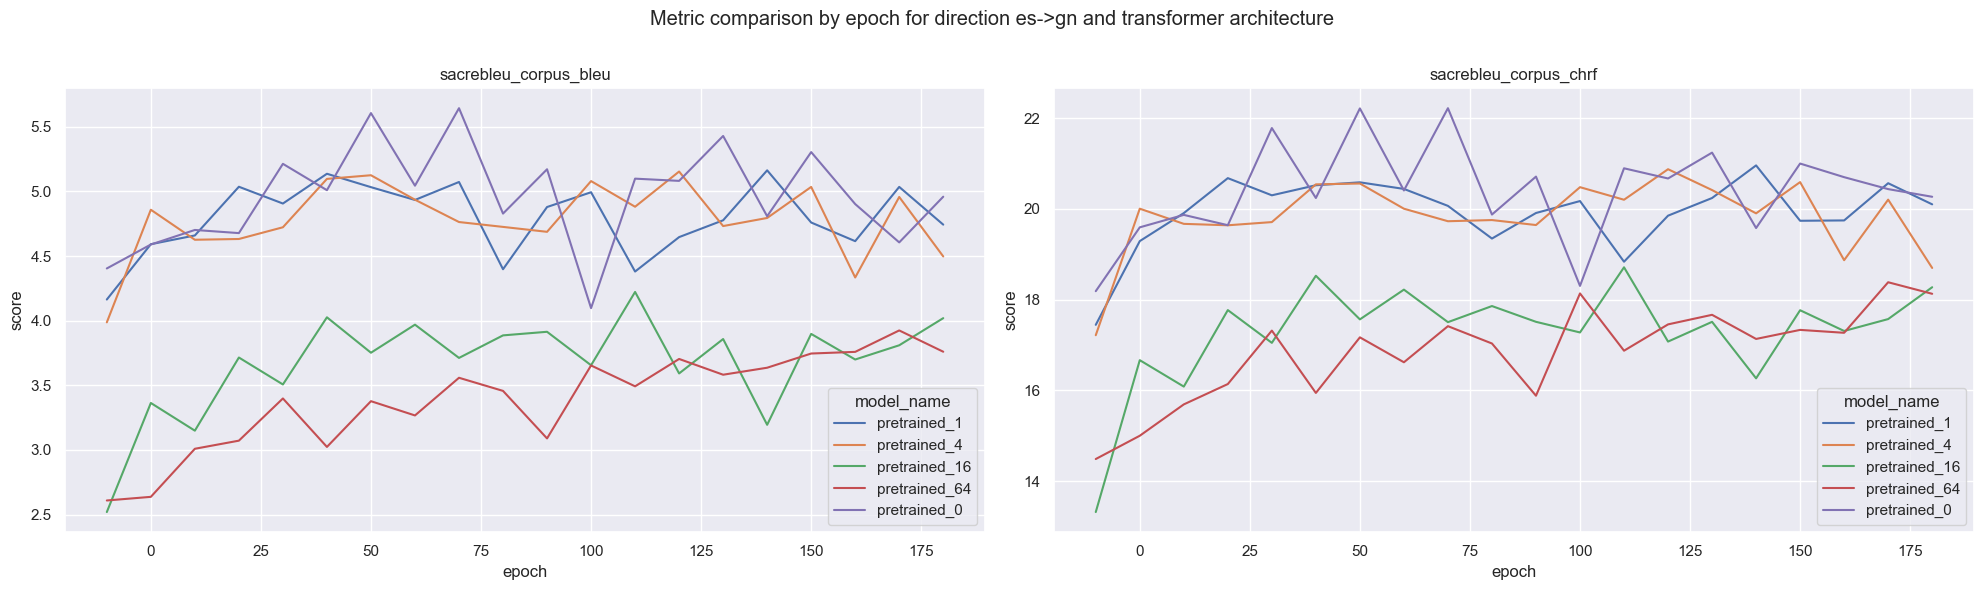

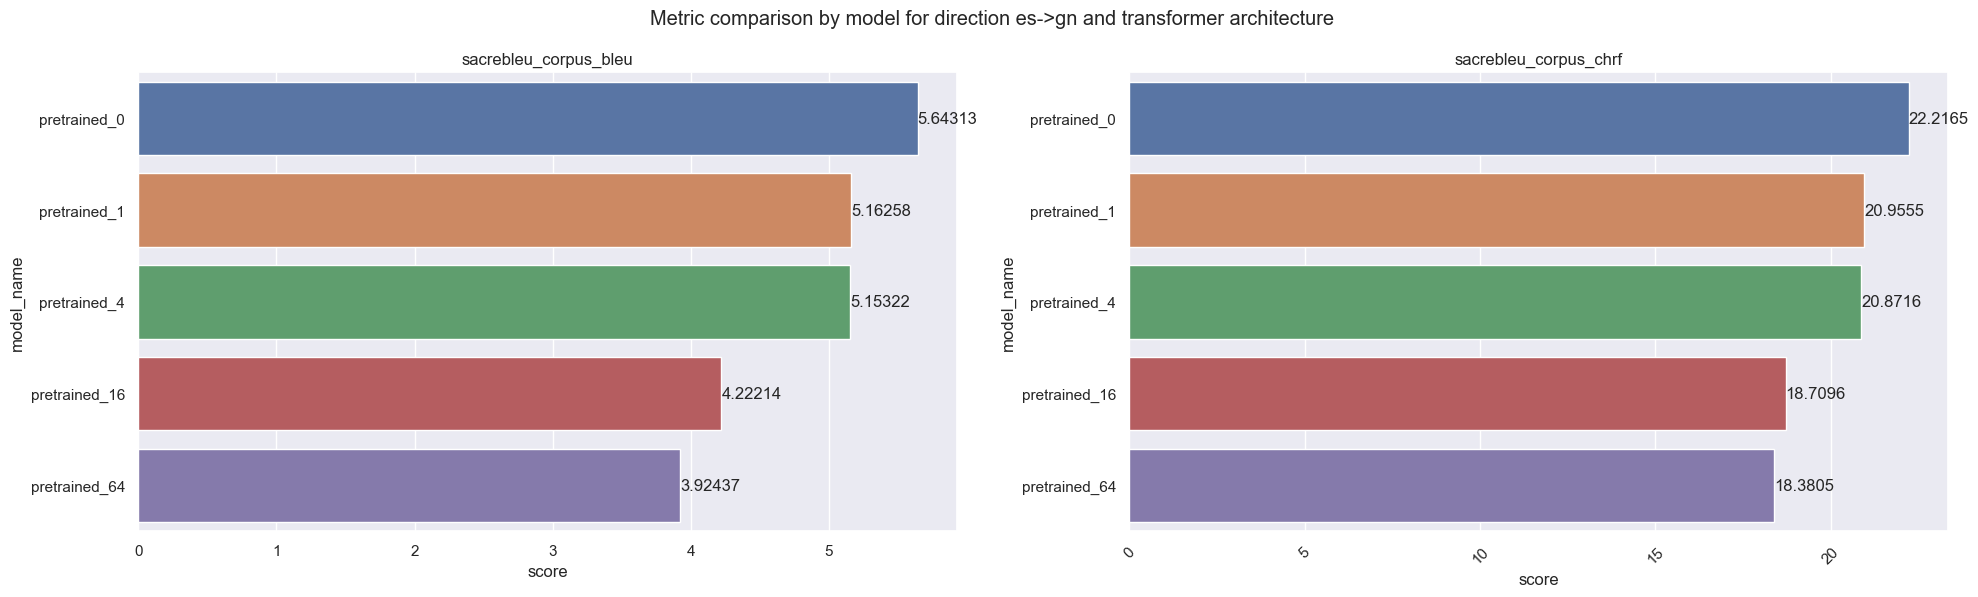

In [157]:
default_bible_transformer_es_gn_df['model_name'] = default_bible_transformer_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(default_bible_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_bible_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

#### **2.2. Finetuned Pretraining**

In [158]:
PRETRAINED_RESULTS_BIBLE_CSV = os.path.join(PRETRAINING_FOLDER, 'finetuned_pretraining_bible.csv')

In [159]:
pretrained_results_df = pd.read_csv(PRETRAINED_RESULTS_BIBLE_CSV)
finetuned_results_df = pd.read_csv(FINETUNED_RESULTS_CSV)
pretrained_results_df = pd.concat([pretrained_results_df, finetuned_results_df], axis=0)

finetuned_results_df = shift_epochs_from_epoch(finetuned_results_df, from_=10)
pretrained_results_df = shift_epochs_from_epoch(pretrained_results_df, from_=10)

pretrained_results_df['date'] = pd.to_datetime(pretrained_results_df['date'])
pretrained_results_df = extract_epochs_from_name(pretrained_results_df)

In [160]:
pretrained_s2s_gn_es_df = filter_df_by_model(pretrained_results_df, 's2s', 'gn')
pretrained_s2s_es_gn_df = filter_df_by_model(pretrained_results_df, 's2s', 'es')
pretrained_transformer_gn_es_df = filter_df_by_model(pretrained_results_df, 'transformer', 'gn')
pretrained_transformer_es_gn_df = filter_df_by_model(pretrained_results_df, 'transformer', 'es')

##### **S2S (GN -> ES)** 

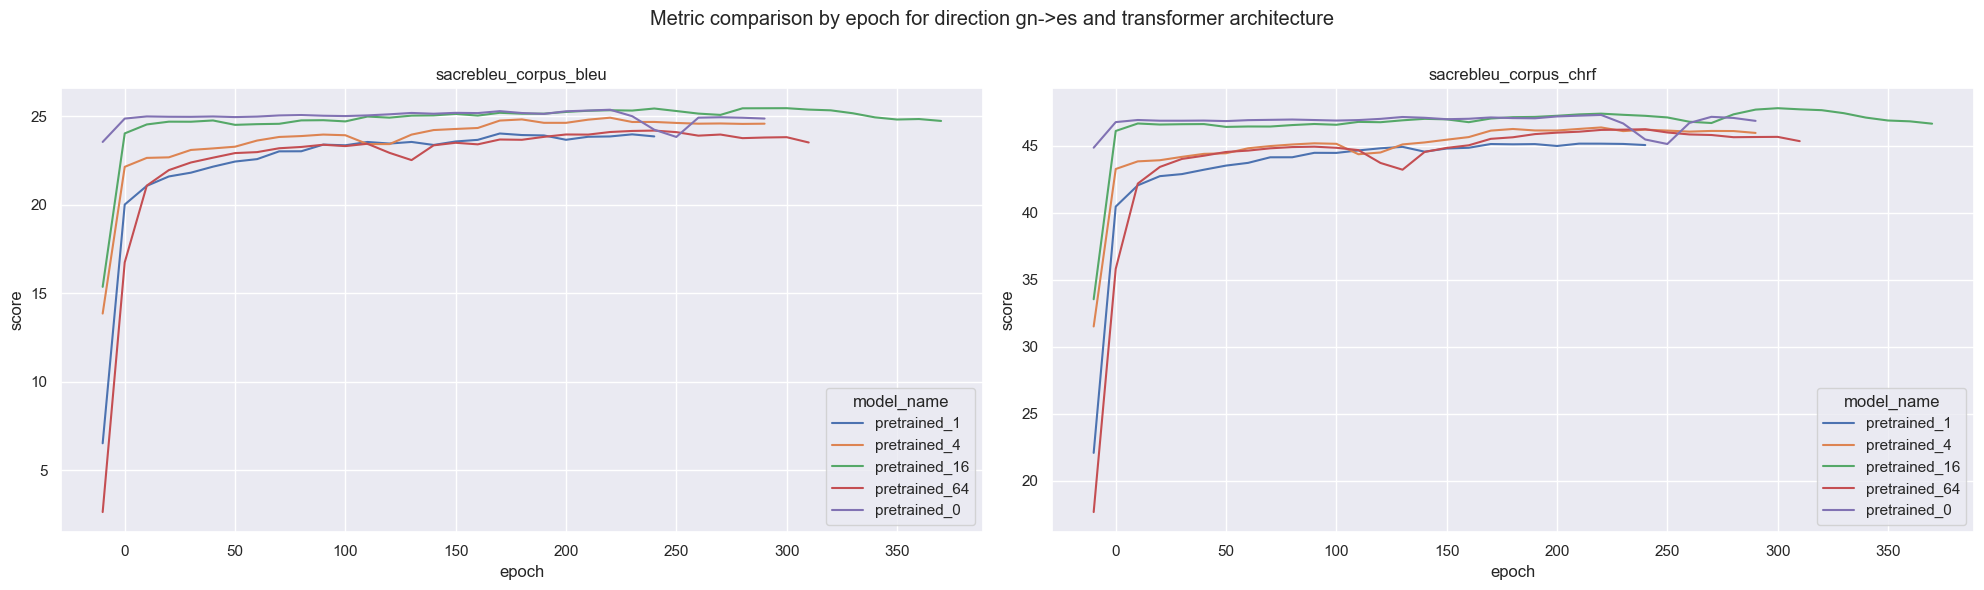

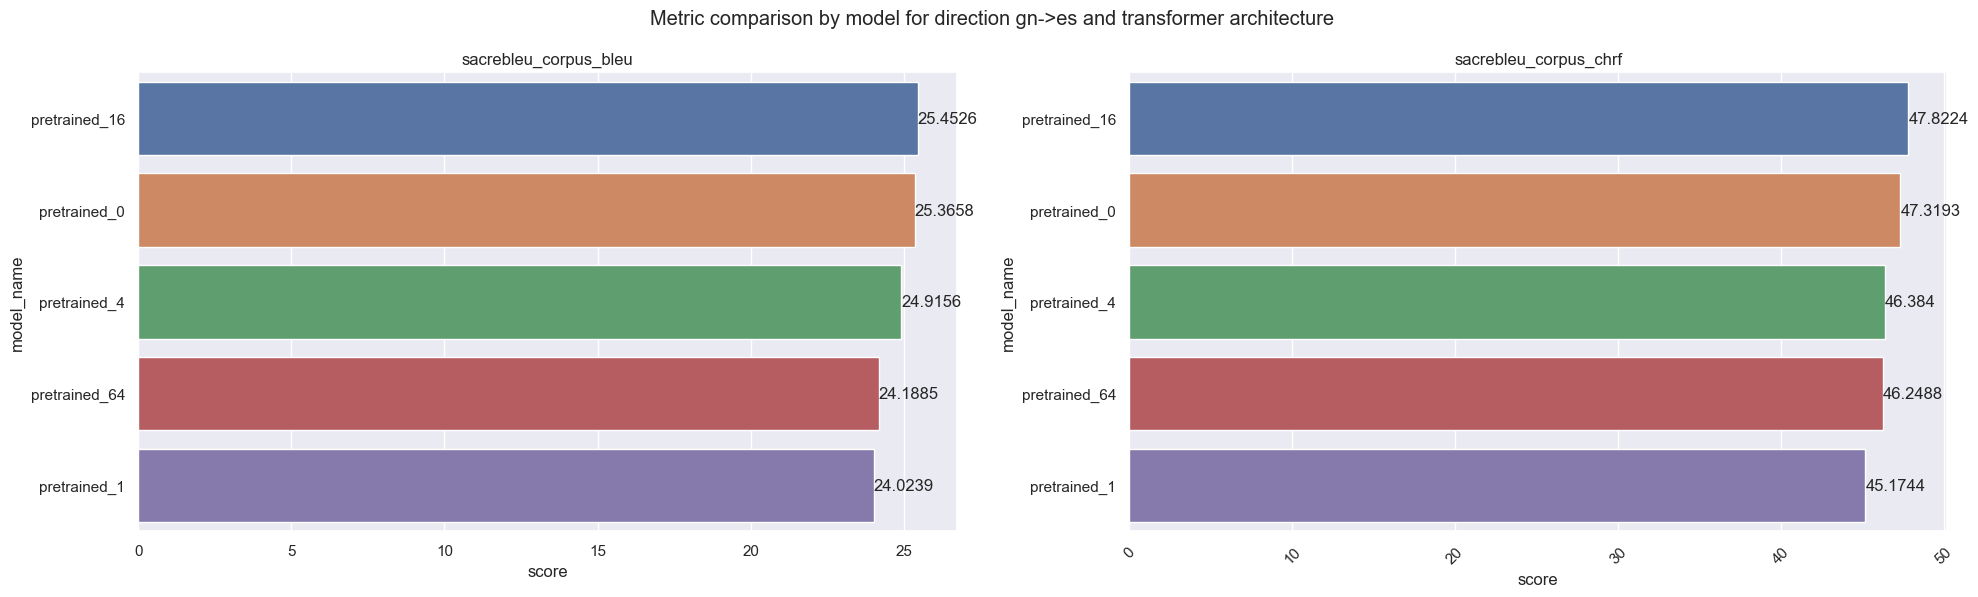

In [161]:
pretrained_s2s_gn_es_df['model_name'] = list(map(lambda x: f'pretrained_{x}', pretrained_s2s_gn_es_df['pretraining_epochs'].tolist()))
plots.plot_metric_by_epoch_foreach_model(pretrained_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **S2S (ES -> GN)** 

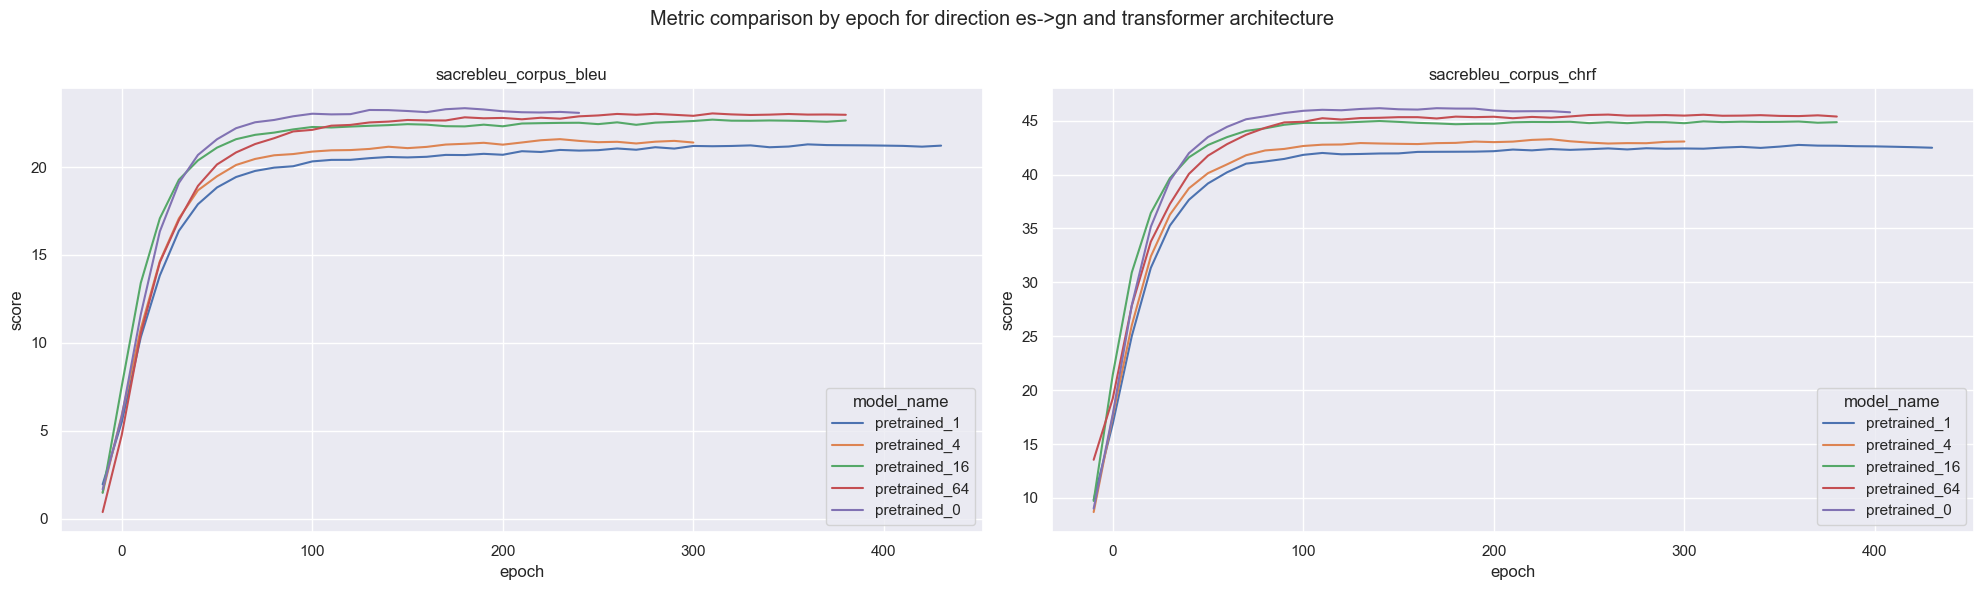

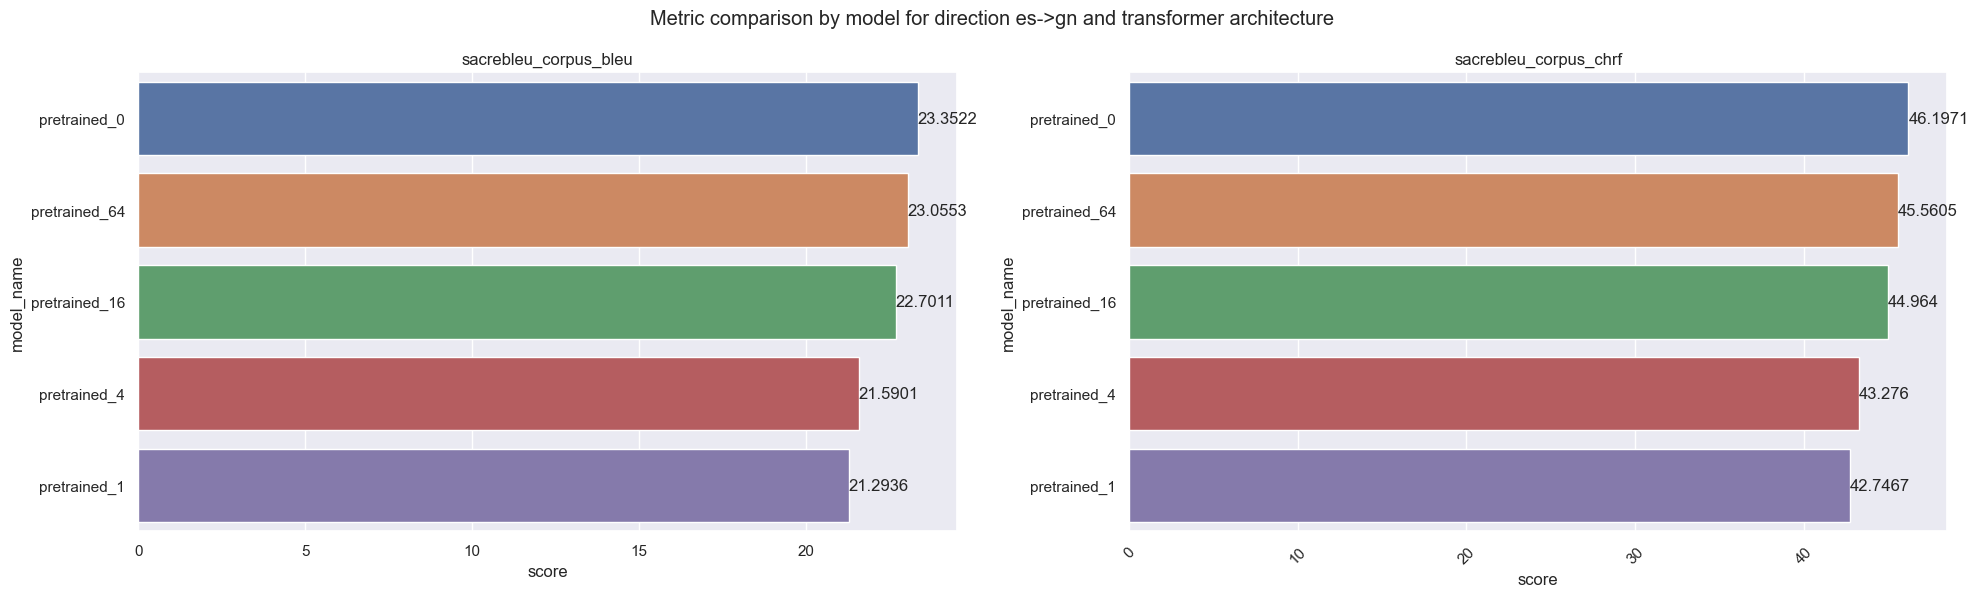

In [162]:
pretrained_s2s_es_gn_df['model_name'] = pretrained_s2s_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (GN -> ES)** 

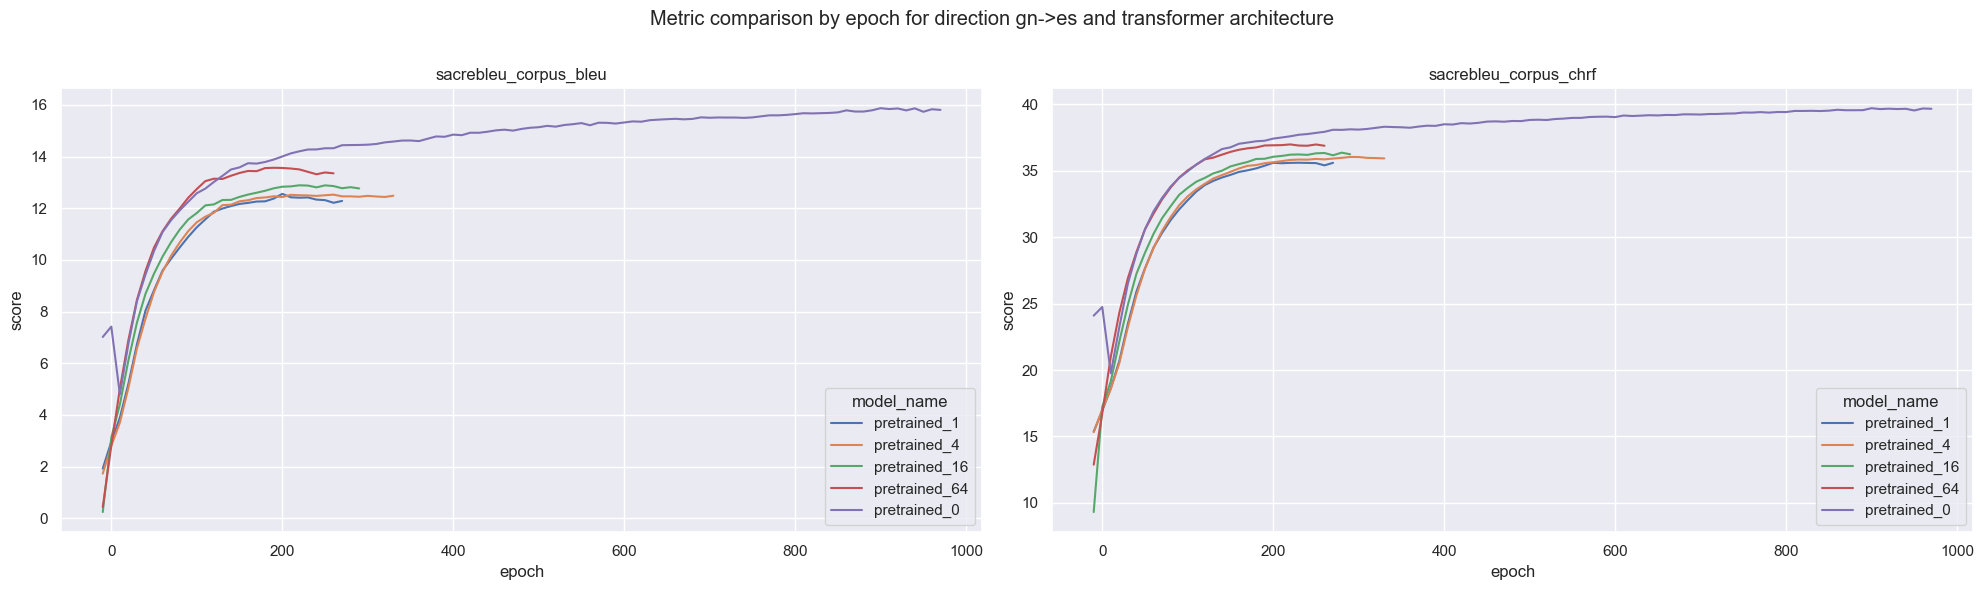

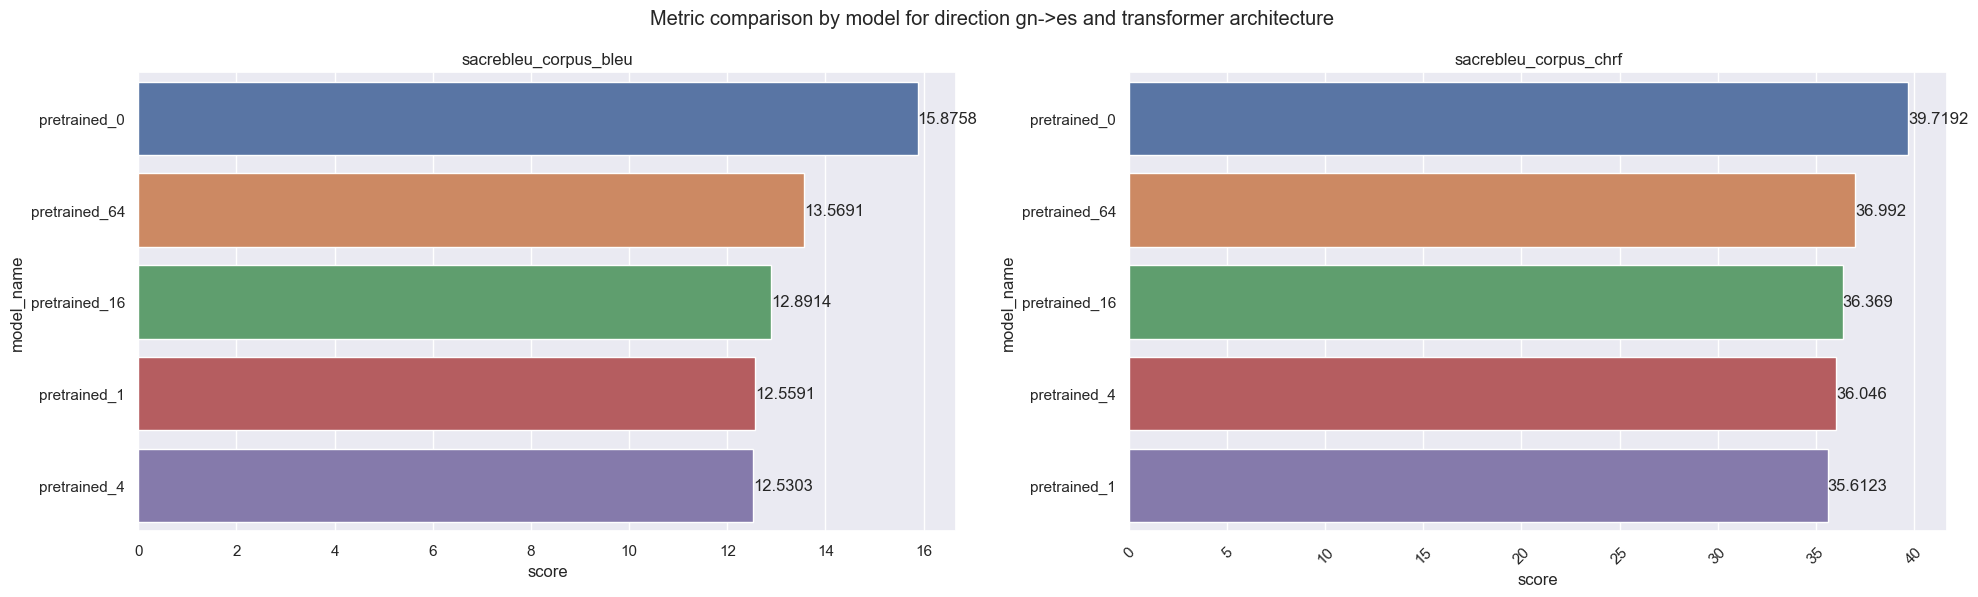

In [163]:
pretrained_transformer_gn_es_df['model_name'] = pretrained_transformer_gn_es_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (ES -> GN)** 

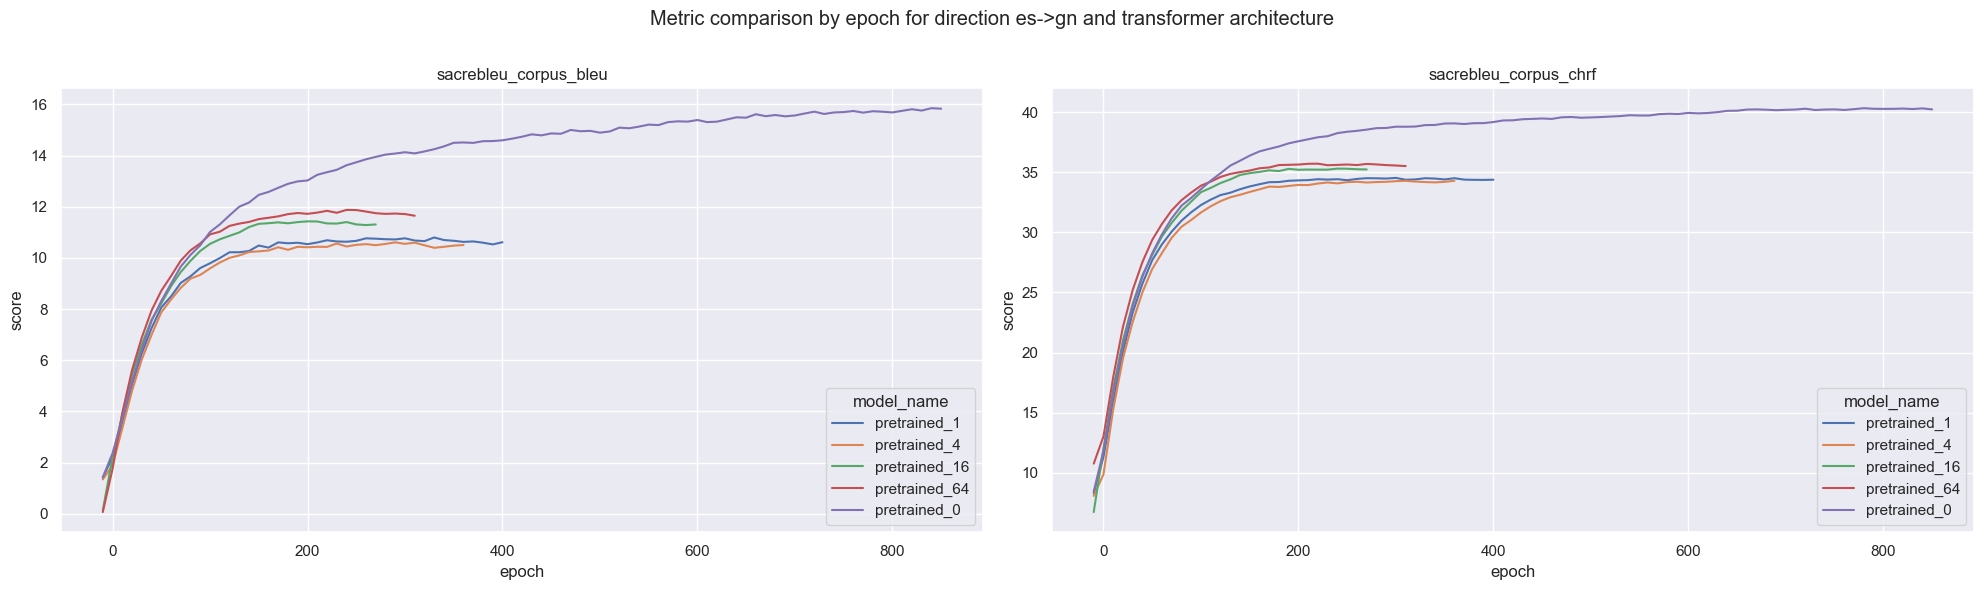

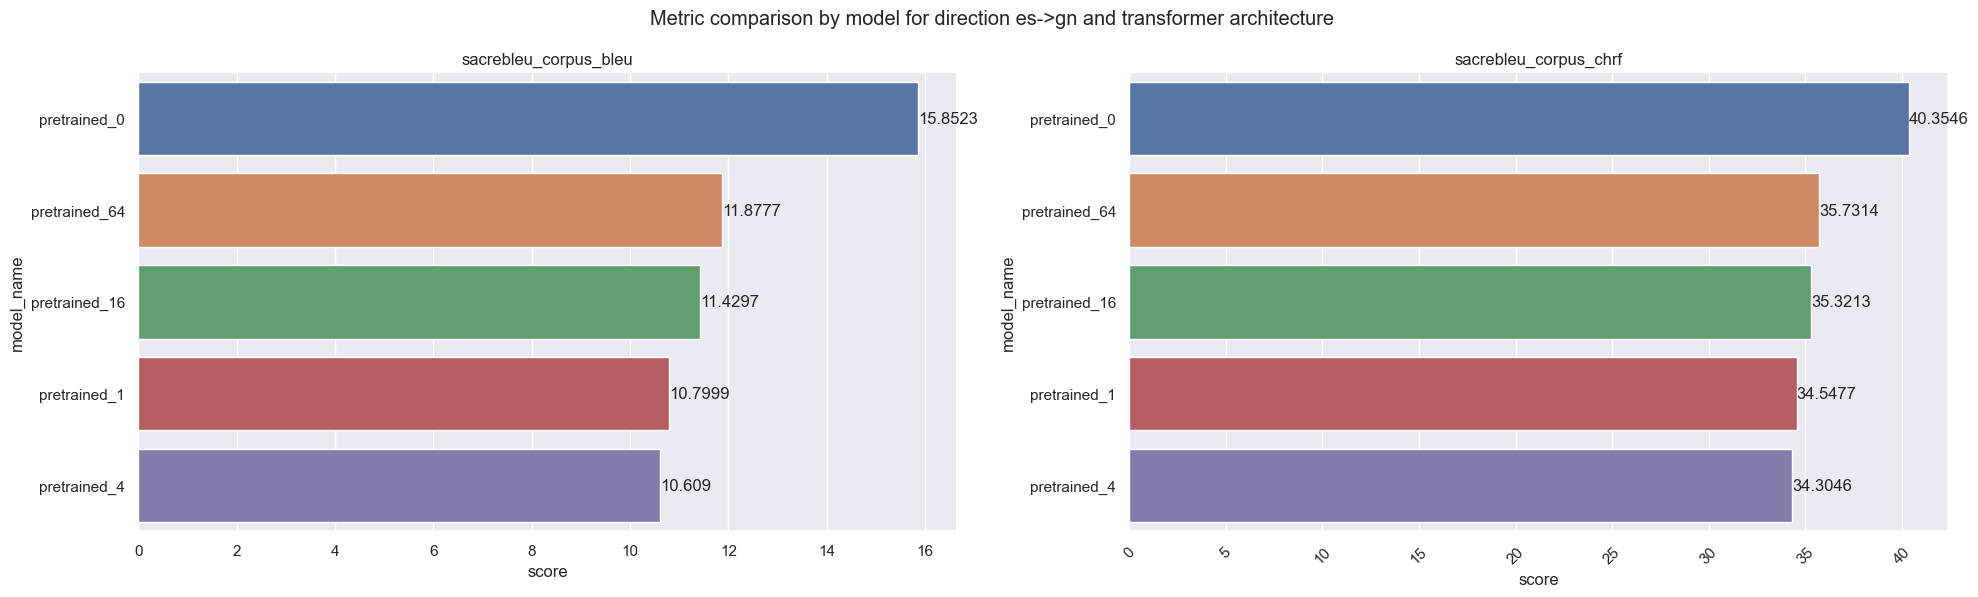

In [164]:
pretrained_transformer_es_gn_df['model_name'] = pretrained_transformer_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

### **3. Ancora**

#### **3.1. Default Pretraining**

In [165]:
DEFAULT_RESULTS_ANCORA_CSV = os.path.join(PRETRAINING_FOLDER, 'default_pretraining_ancora.csv')

In [166]:
results_df = pd.read_csv(DEFAULT_RESULTS_ANCORA_CSV)
results_without_pretraining = results_grammar_df[results_grammar_df['pretraining_epochs']=='0']
results_df = pd.concat([results_df, results_without_pretraining], axis=0)

results_df = shift_epochs_from_epoch(results_df, from_=10)

results_df['date'] = pd.to_datetime(results_df['date'])
results_df = extract_epochs_from_name(results_df)

In [167]:
default_ancora_s2s_gn_es_df = filter_df_by_model(results_df, 's2s', 'gn')
default_ancora_s2s_es_gn_df = filter_df_by_model(results_df, 's2s', 'es')
default_ancora_transformer_gn_es_df = filter_df_by_model(results_df, 'transformer', 'gn')
default_ancora_transformer_es_gn_df = filter_df_by_model(results_df, 'transformer', 'es')

##### **S2S (GN -> ES)** 

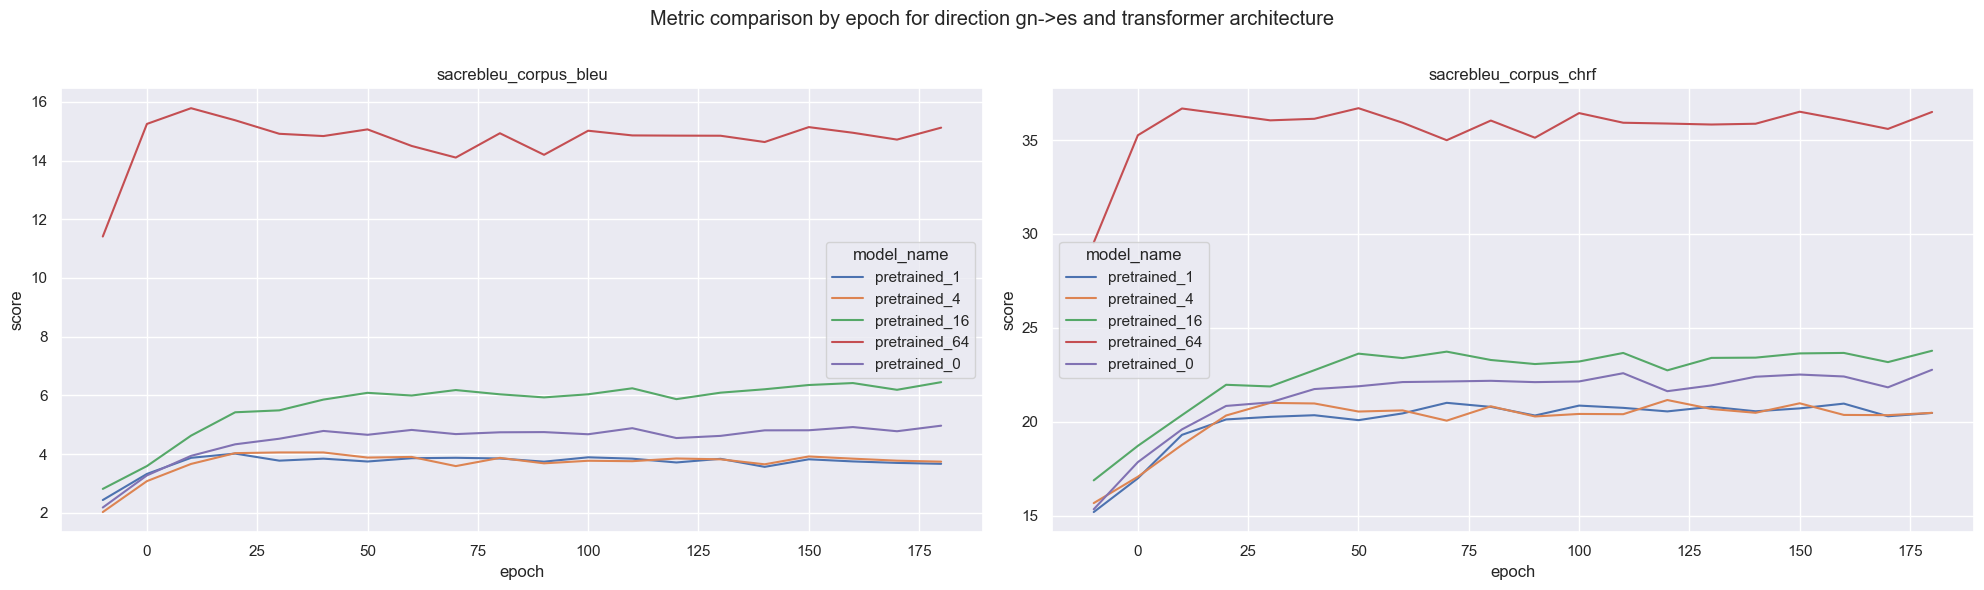

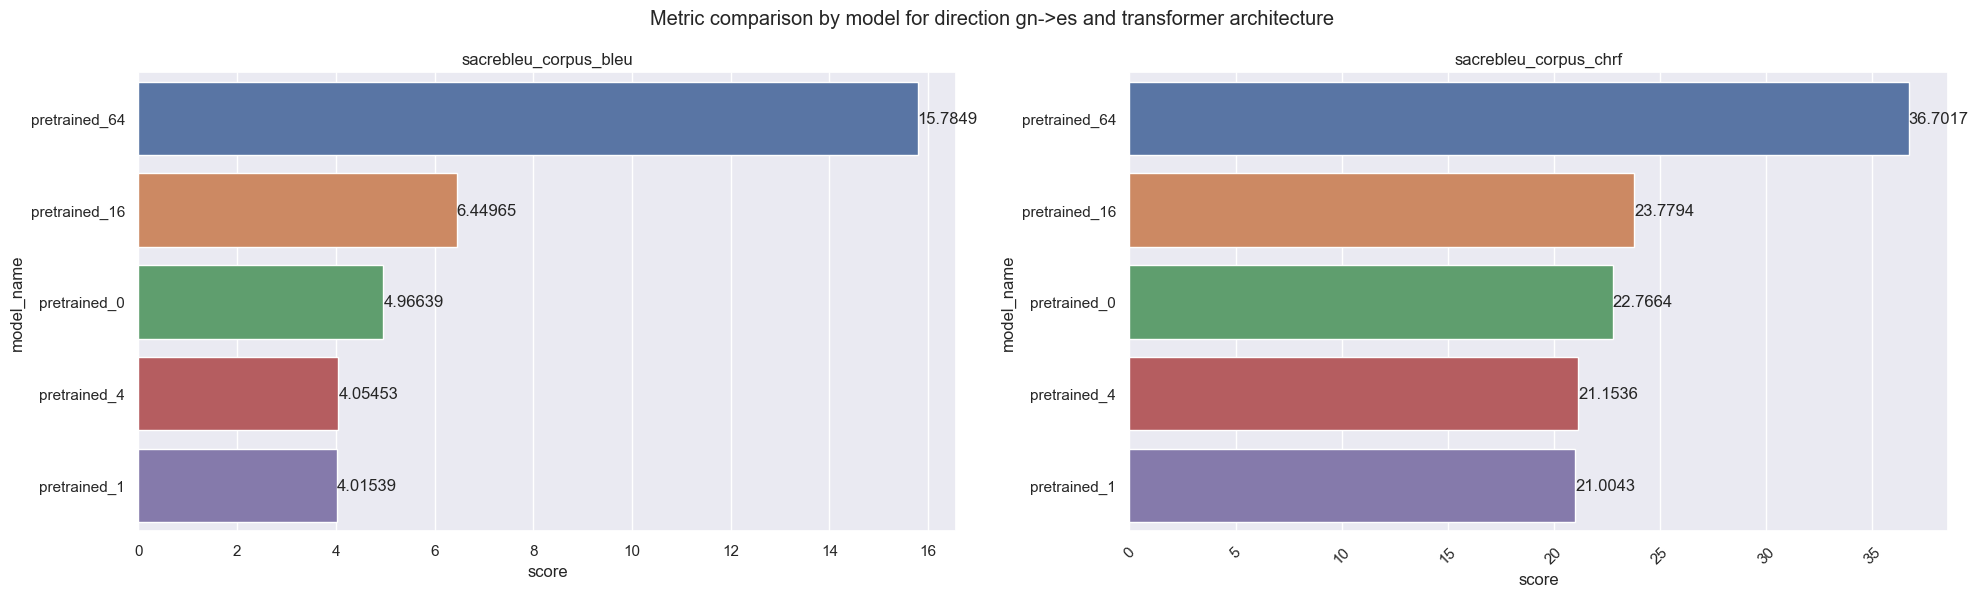

In [168]:
default_ancora_s2s_gn_es_df['model_name'] = list(map(lambda x: f'pretrained_{x}', default_ancora_s2s_gn_es_df['pretraining_epochs'].tolist()))
plots.plot_metric_by_epoch_foreach_model(default_ancora_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_ancora_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **S2S (ES -> GN)** 

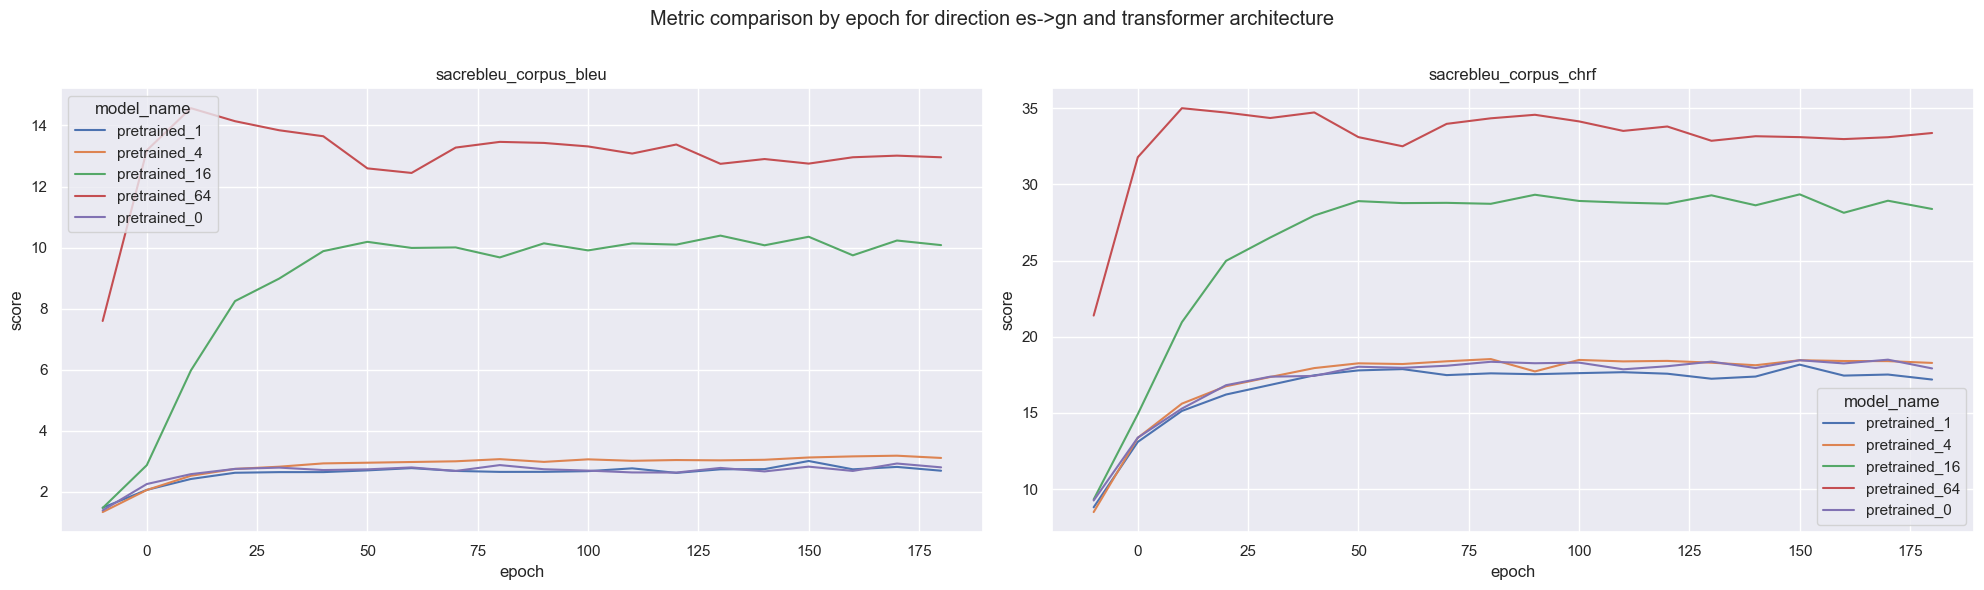

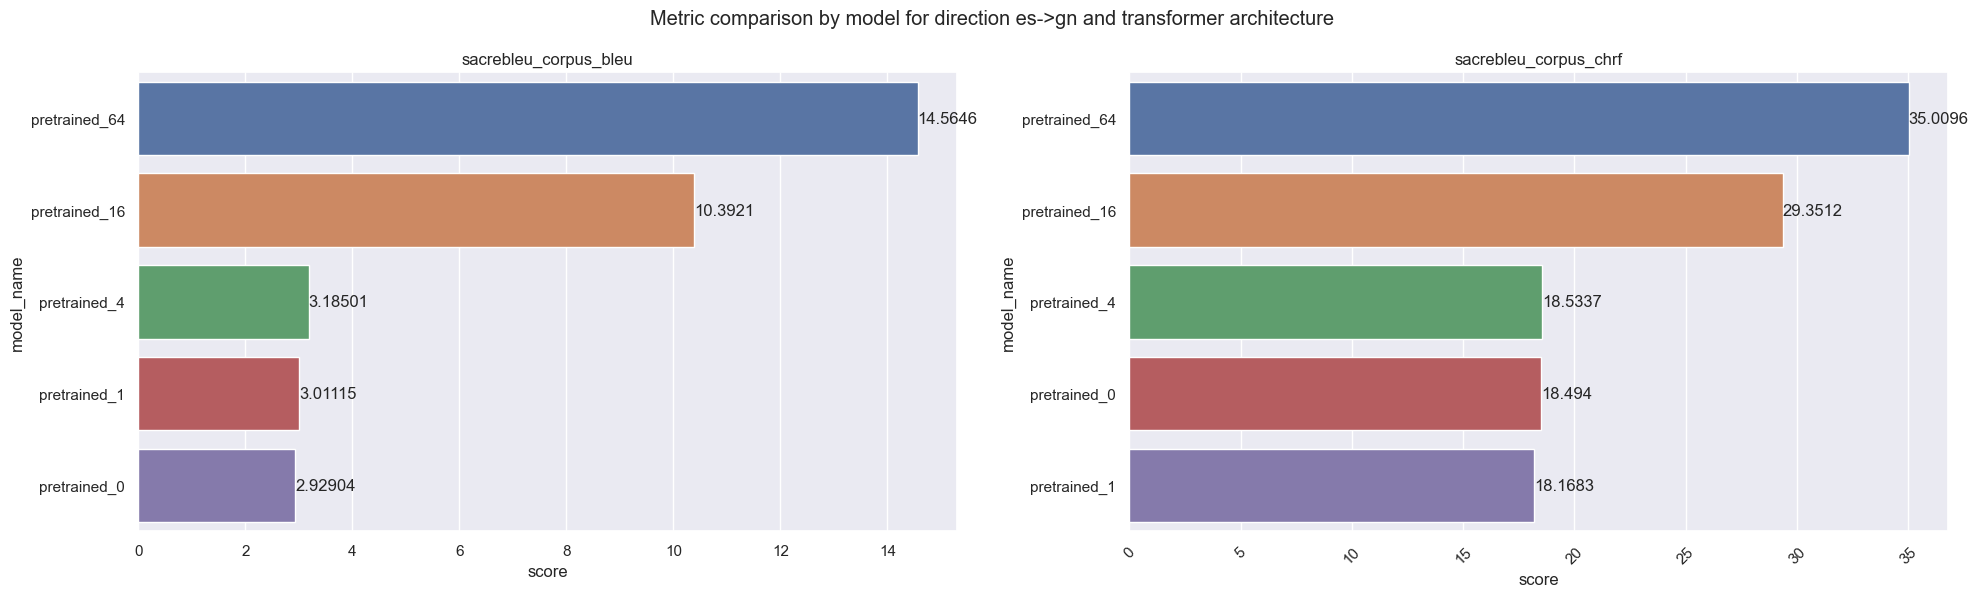

In [169]:
default_ancora_s2s_es_gn_df['model_name'] = default_ancora_s2s_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(default_ancora_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_ancora_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (GN -> ES)** 

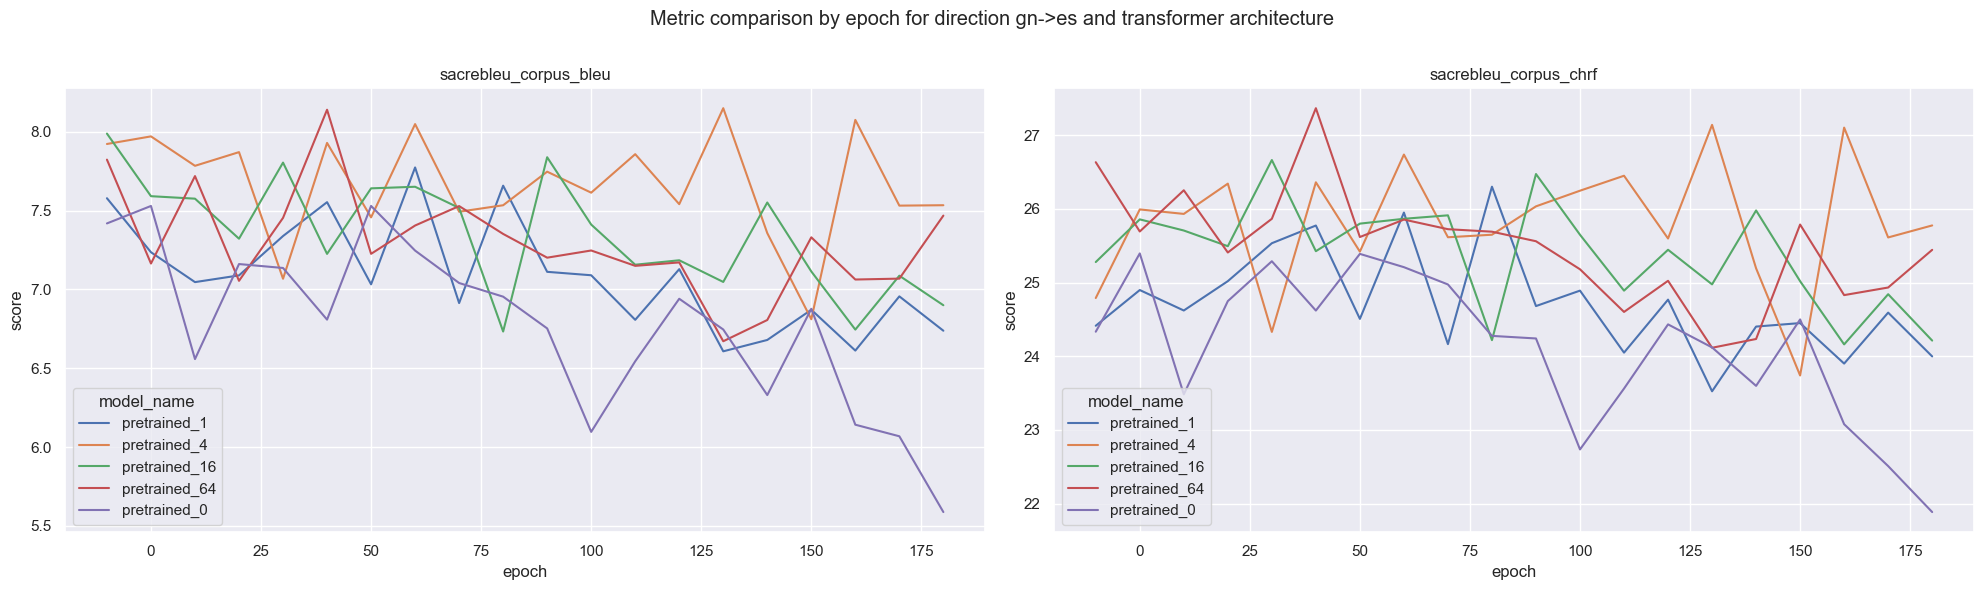

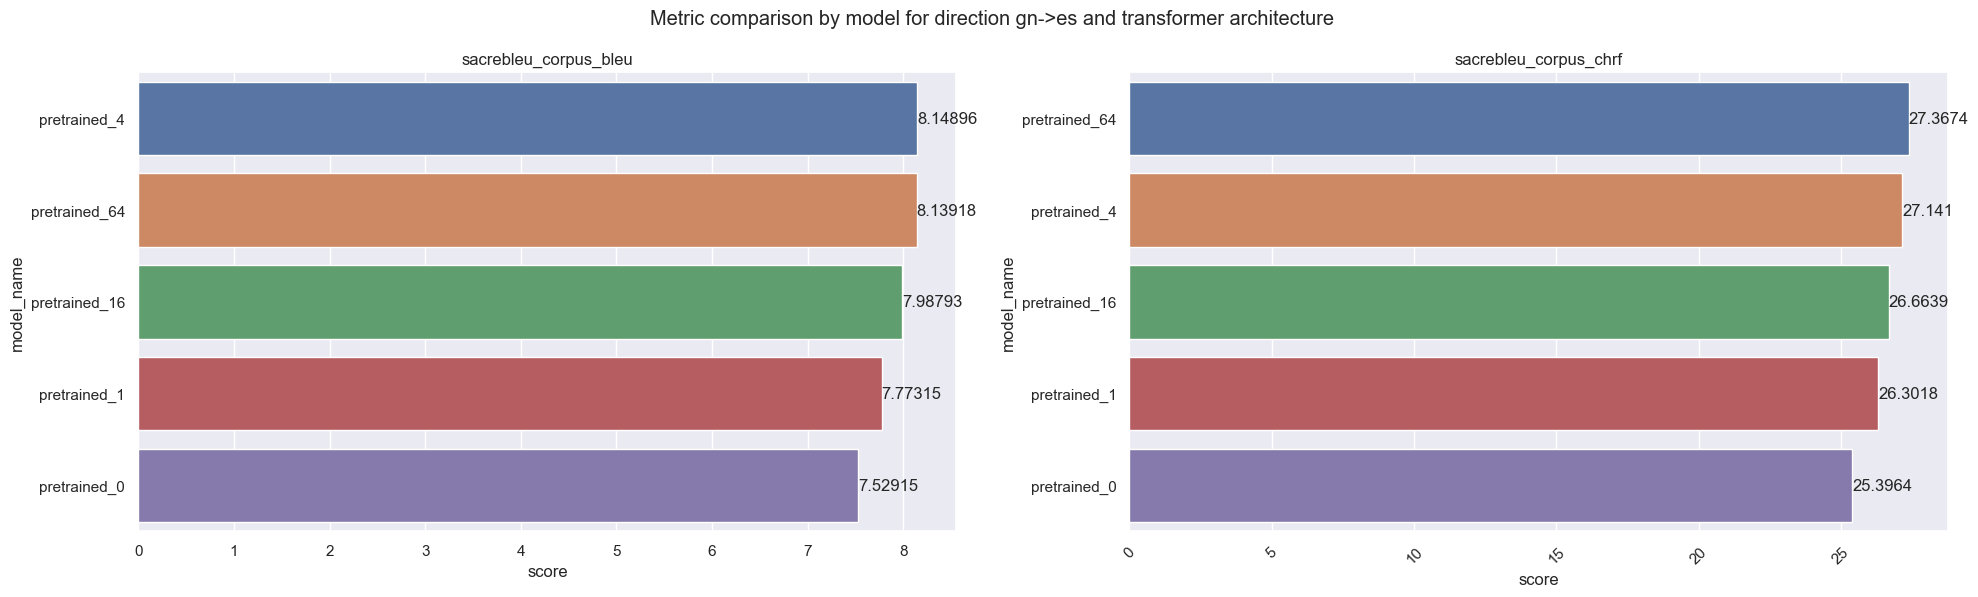

In [170]:
default_ancora_transformer_gn_es_df['model_name'] = default_ancora_transformer_gn_es_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(default_ancora_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_ancora_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (ES -> GN)** 

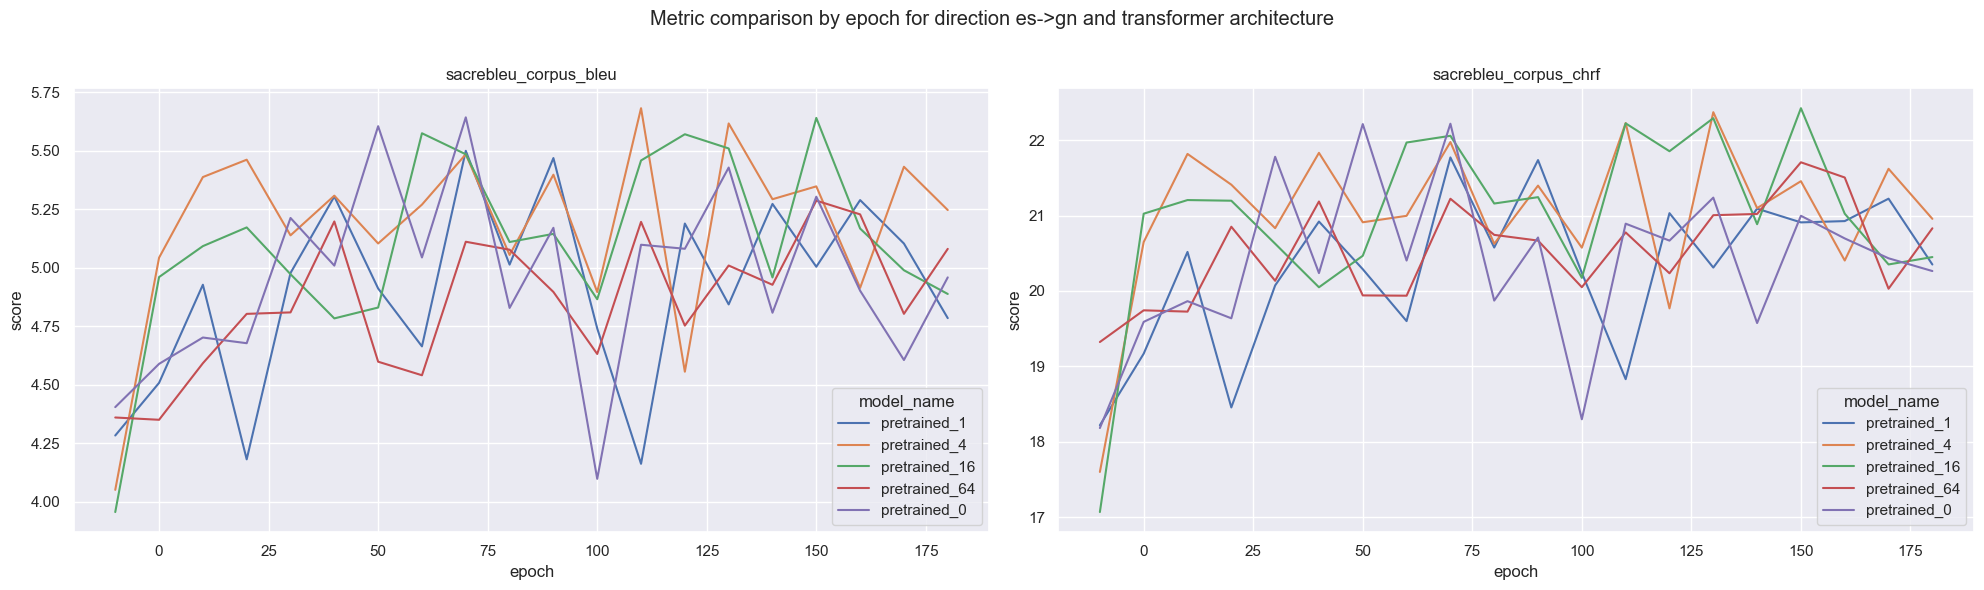

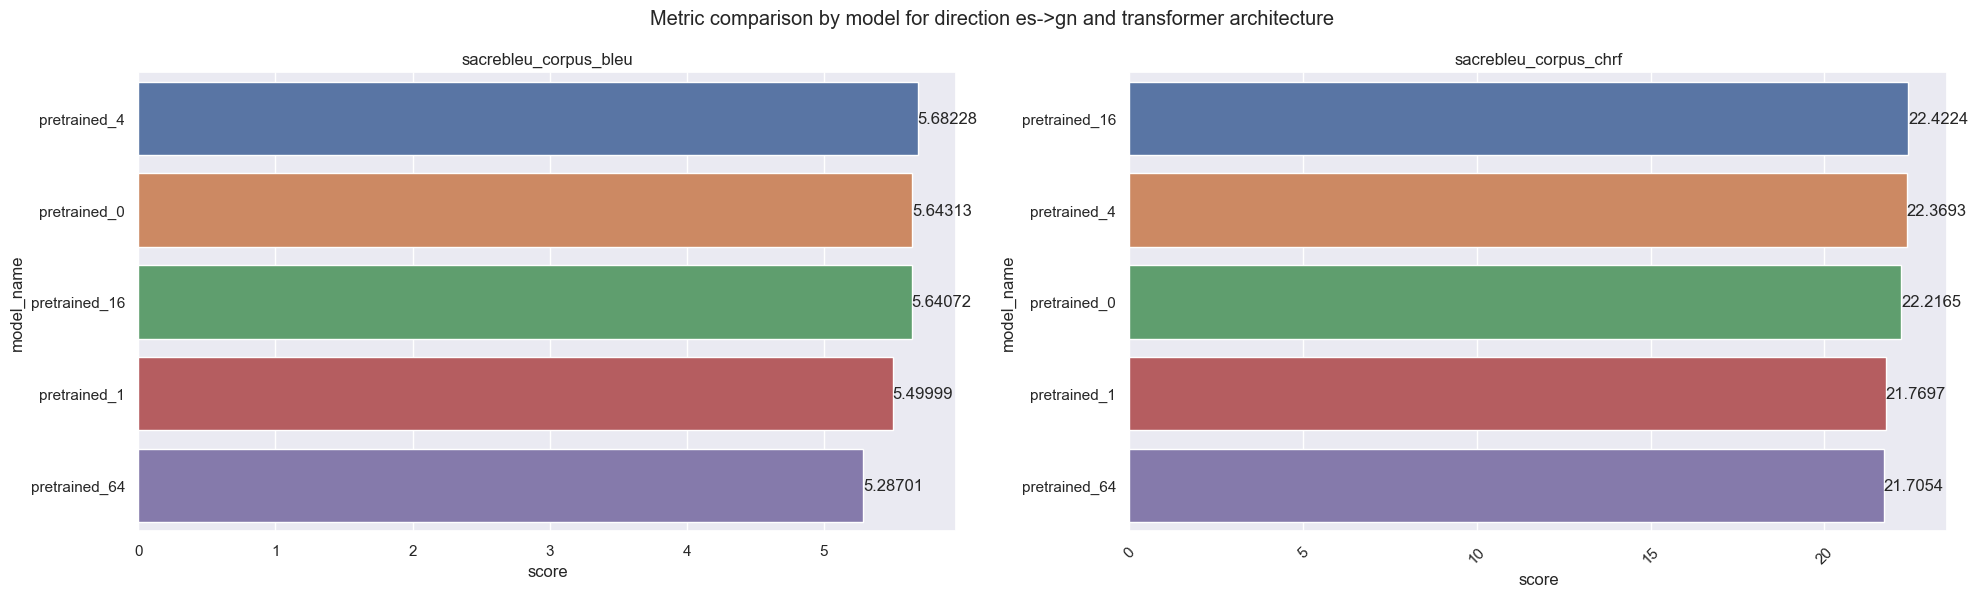

In [171]:
default_ancora_transformer_es_gn_df['model_name'] = default_ancora_transformer_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(default_ancora_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_ancora_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

#### **3.2. Tuned Pretraining**

In [193]:
PRETRAINED_RESULTS_ANCORA_CSV = os.path.join(PRETRAINING_FOLDER, 'finetuned_pretraining_ancora.csv')

In [194]:
pretrained_results_df = pd.read_csv(PRETRAINED_RESULTS_ANCORA_CSV)
finetuned_results_df = pd.read_csv(FINETUNED_RESULTS_CSV)
pretrained_results_df = pd.concat([pretrained_results_df, finetuned_results_df], axis=0)

pretrained_results_df = shift_epochs_from_epoch(pretrained_results_df, from_=10)
finetuned_results_df = shift_epochs_from_epoch(finetuned_results_df, from_=10)

pretrained_results_df['date'] = pd.to_datetime(pretrained_results_df['date'])
pretrained_results_df = extract_epochs_from_name(pretrained_results_df)

In [195]:
pretrained_s2s_gn_es_df = filter_df_by_model(pretrained_results_df, 's2s', 'gn')
pretrained_s2s_es_gn_df = filter_df_by_model(pretrained_results_df, 's2s', 'es')
pretrained_transformer_gn_es_df = filter_df_by_model(pretrained_results_df, 'transformer', 'gn')
pretrained_transformer_es_gn_df = filter_df_by_model(pretrained_results_df, 'transformer', 'es')

##### **S2S (GN -> ES)** 

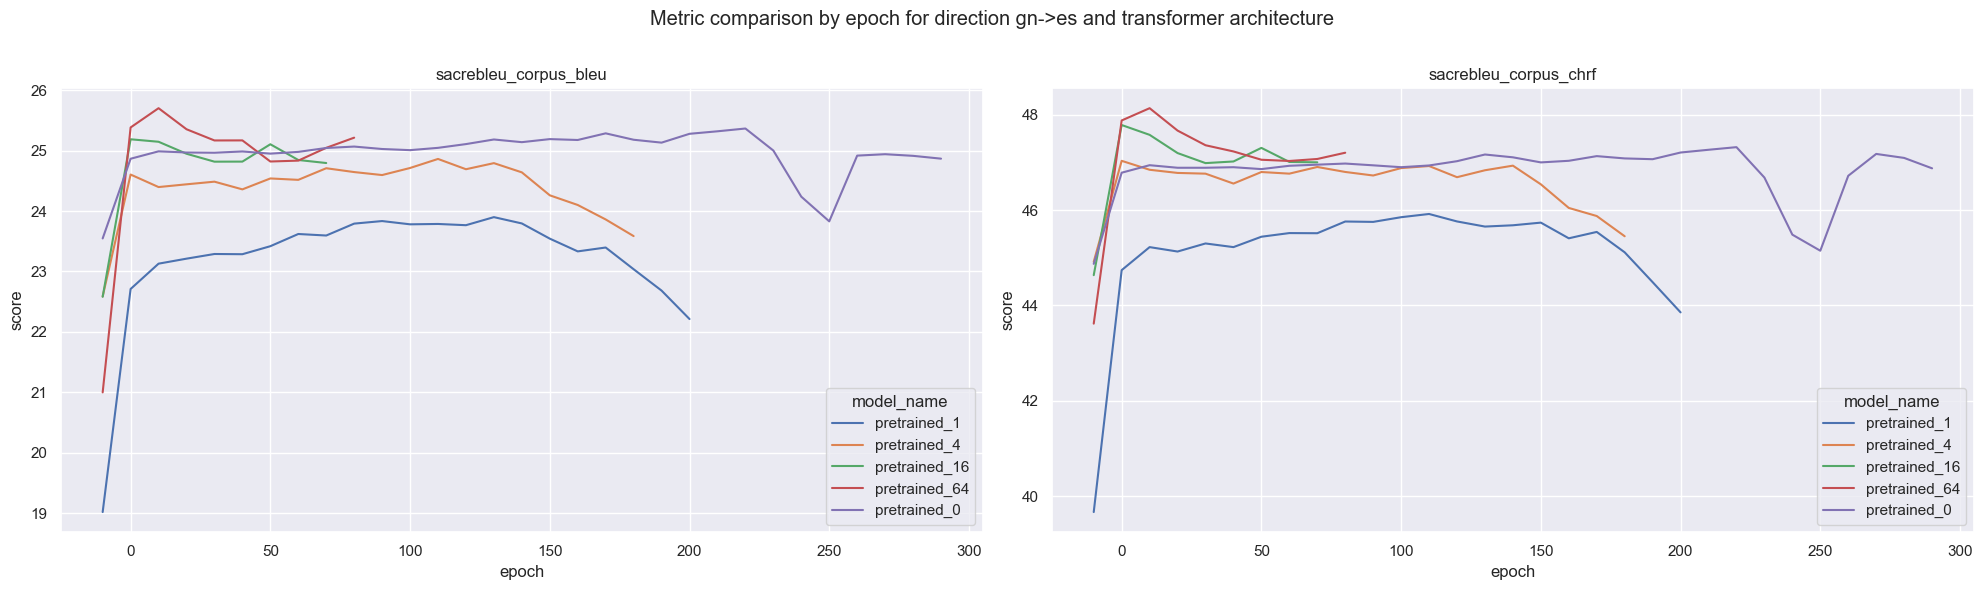

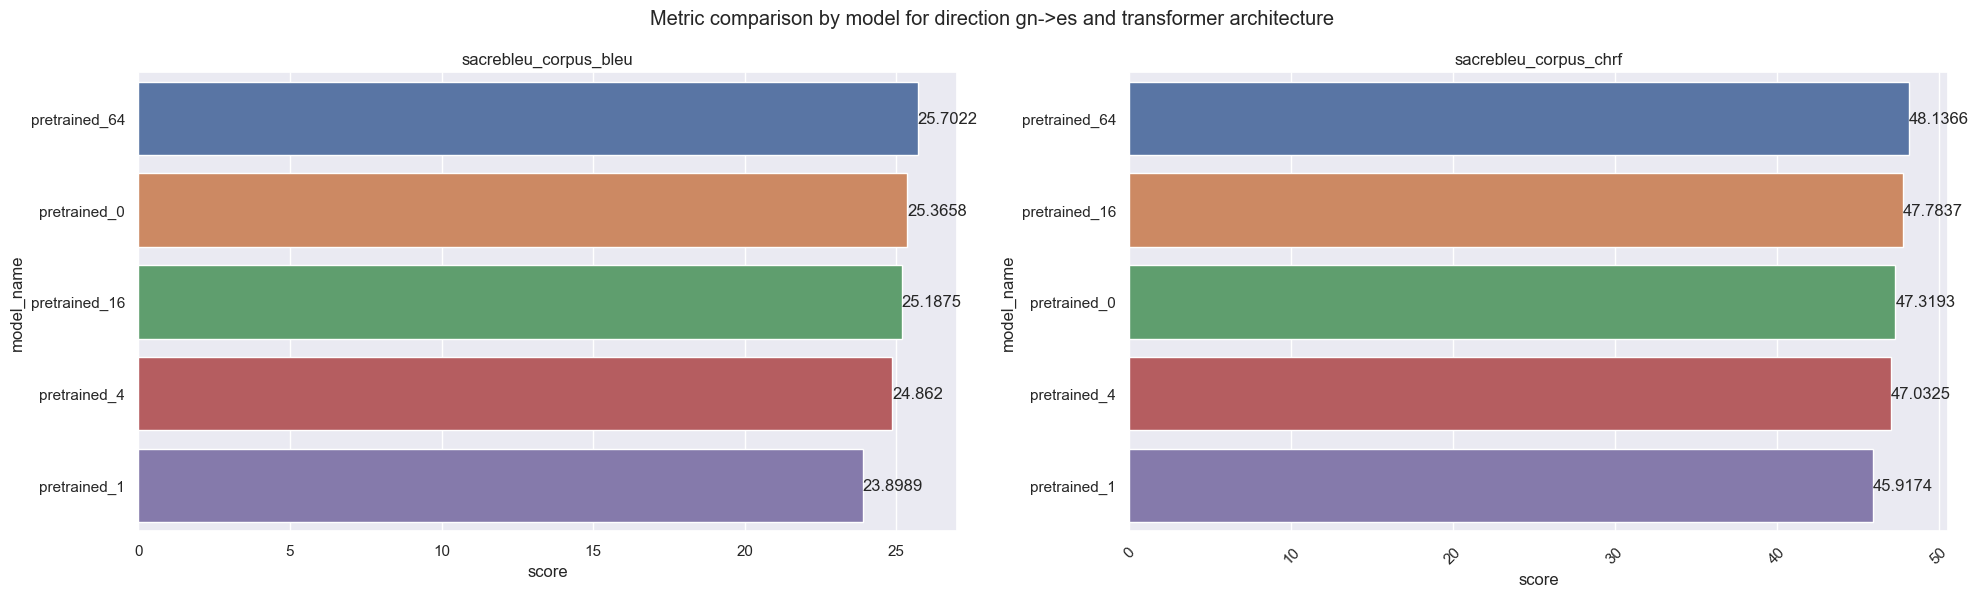

In [196]:
pretrained_s2s_gn_es_df['model_name'] = list(map(lambda x: f'pretrained_{x}', pretrained_s2s_gn_es_df['pretraining_epochs'].tolist()))
plots.plot_metric_by_epoch_foreach_model(pretrained_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **S2S (ES -> GN)** 

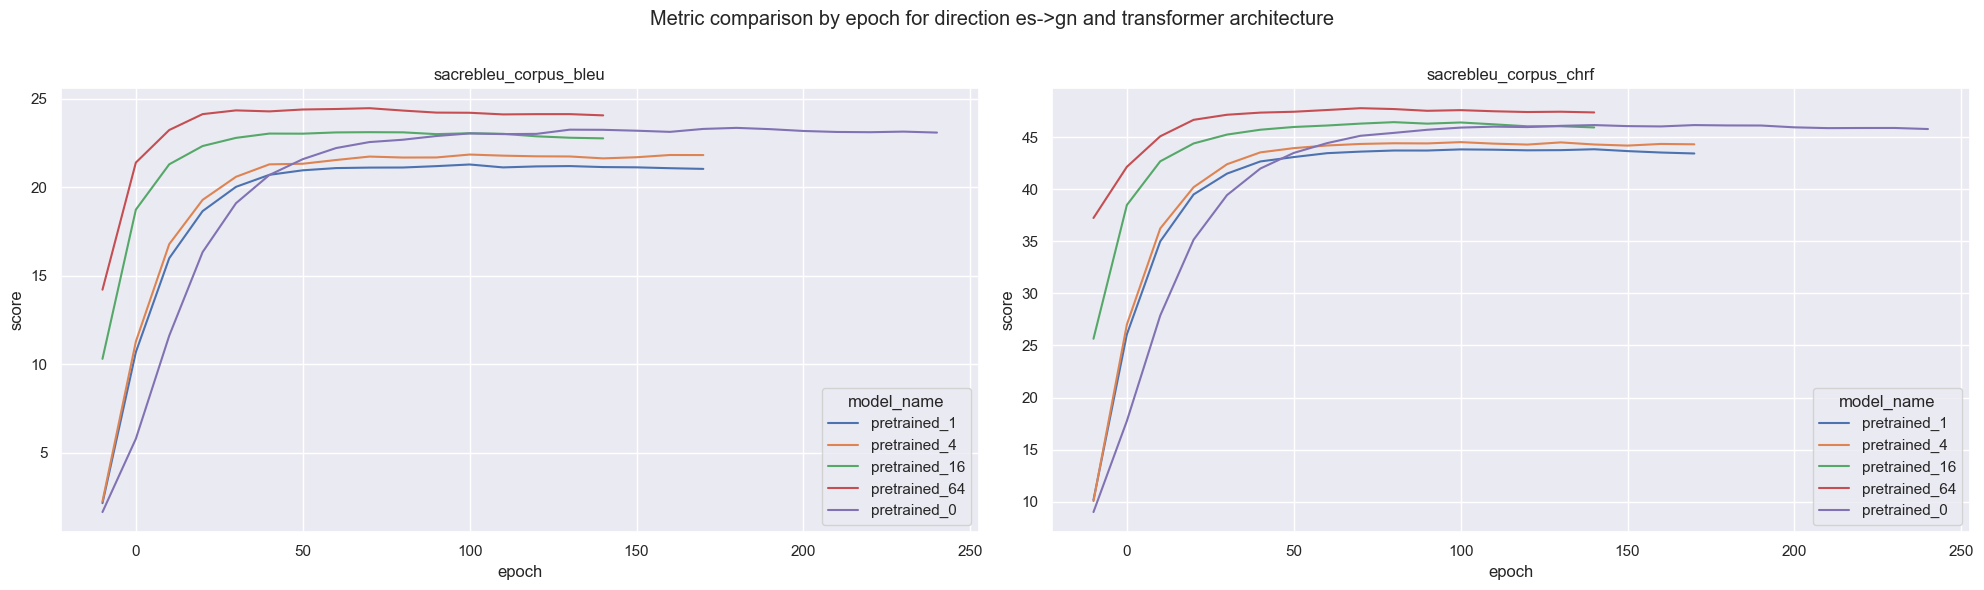

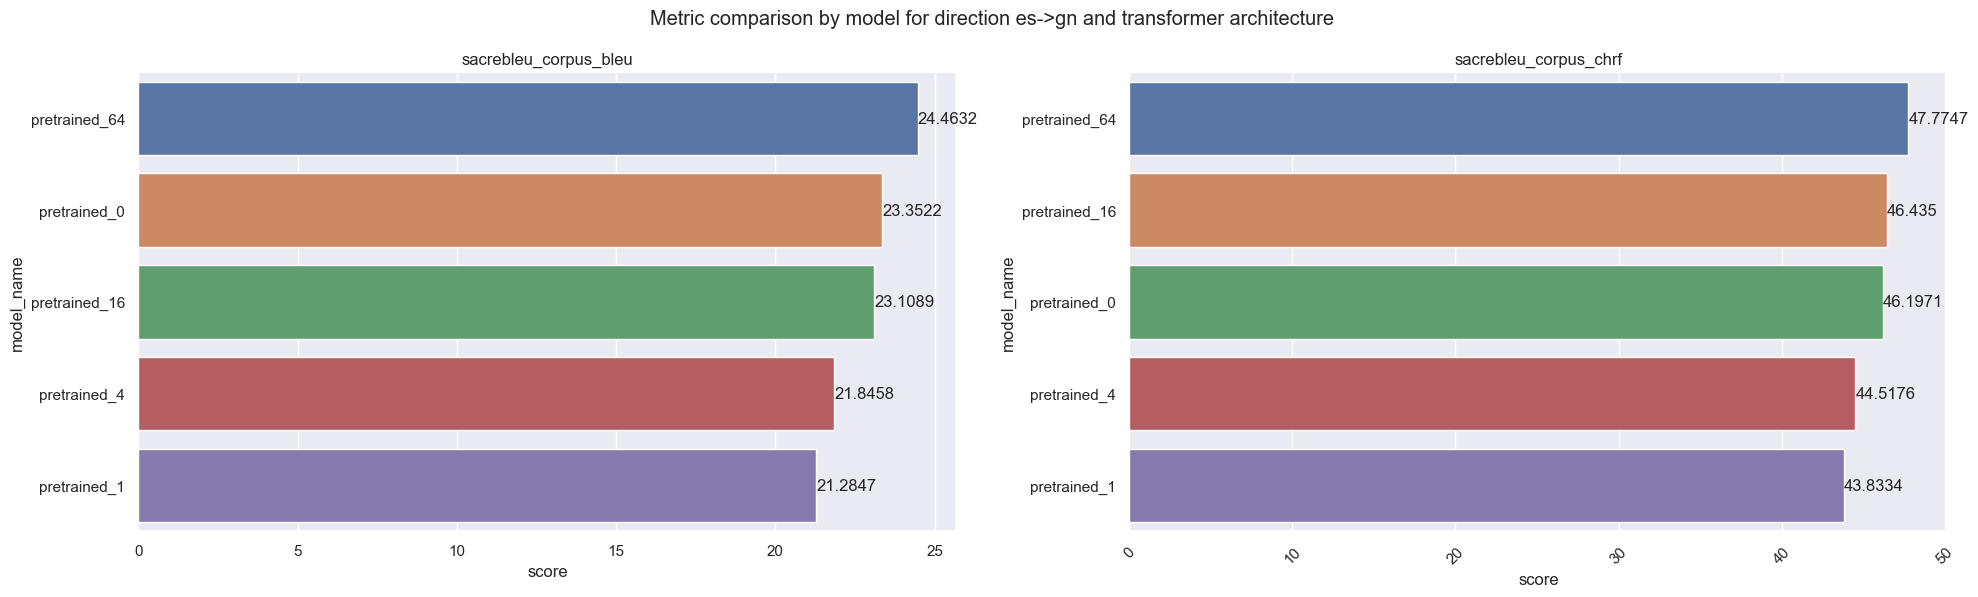

In [197]:
pretrained_s2s_es_gn_df['model_name'] = pretrained_s2s_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (GN -> ES)** 

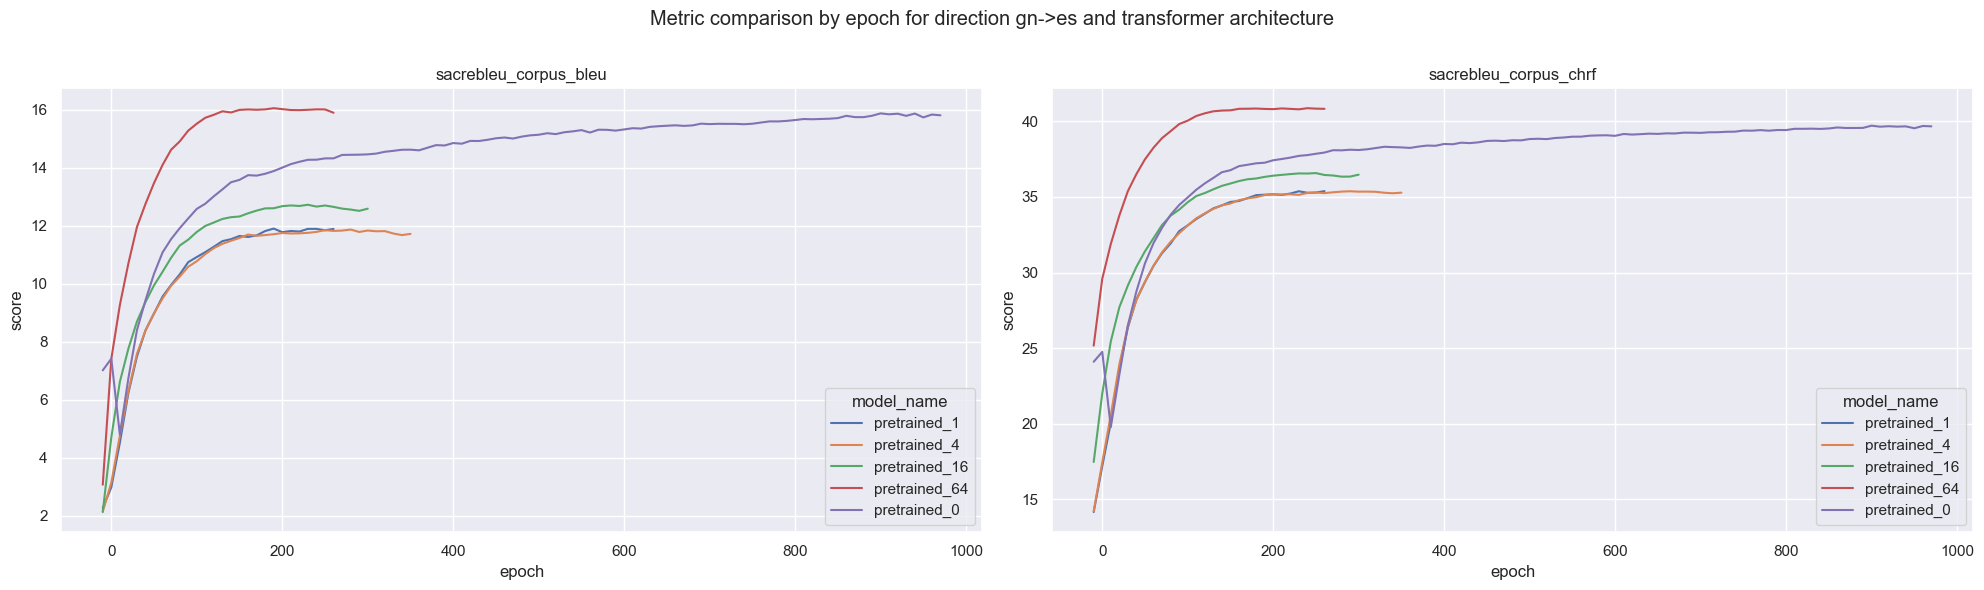

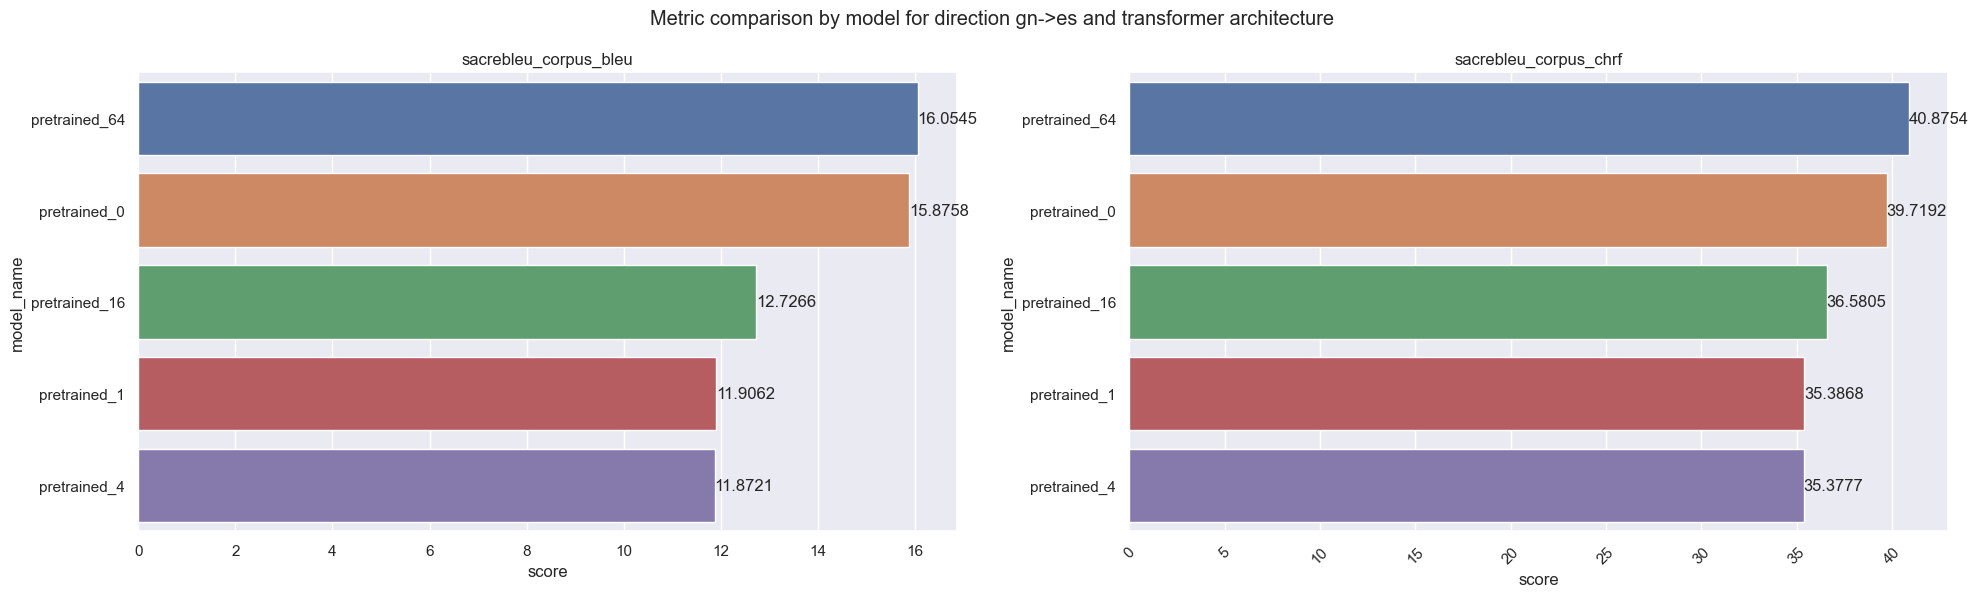

In [198]:
pretrained_transformer_gn_es_df['model_name'] = pretrained_transformer_gn_es_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (ES -> GN)** 

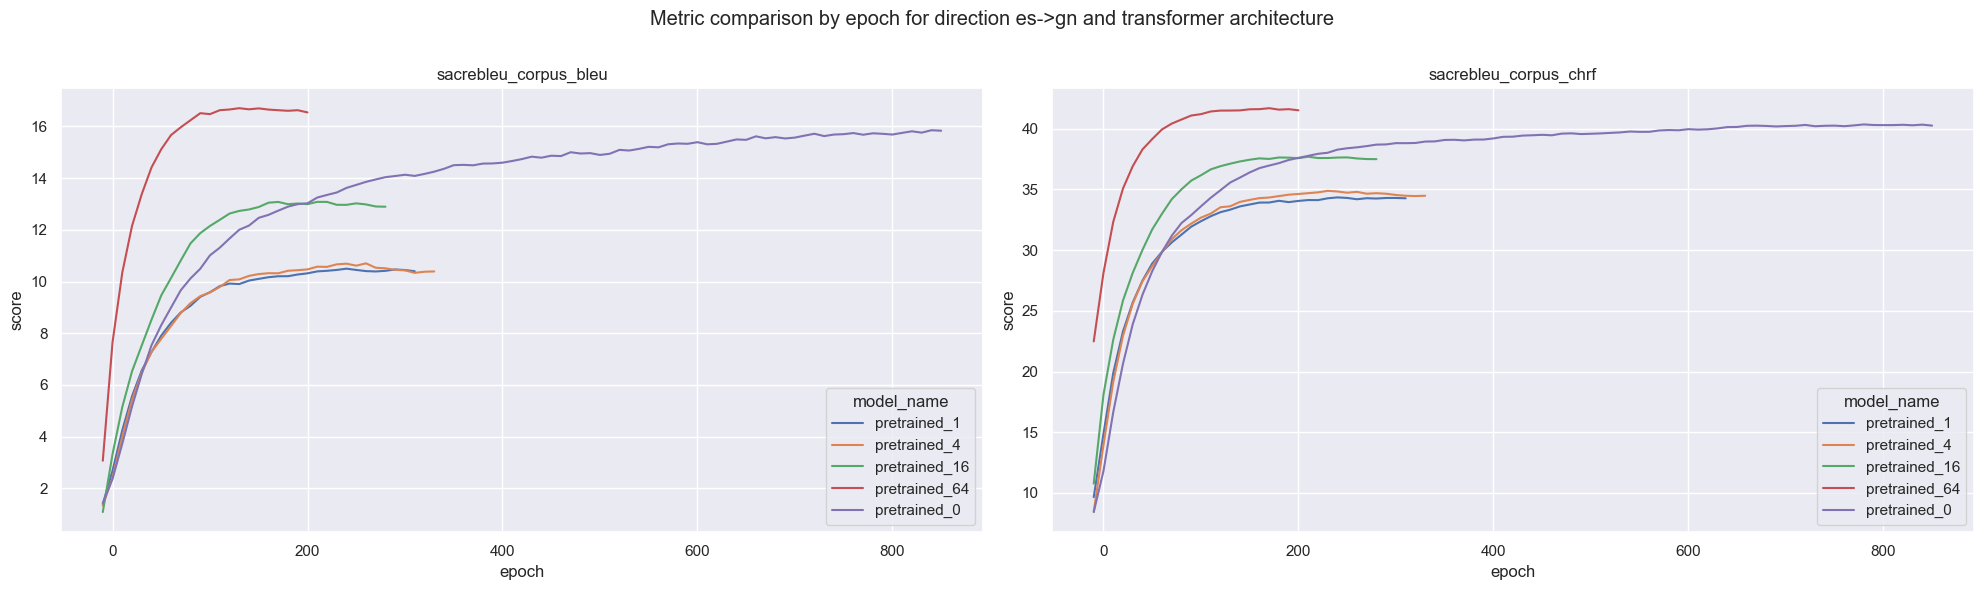

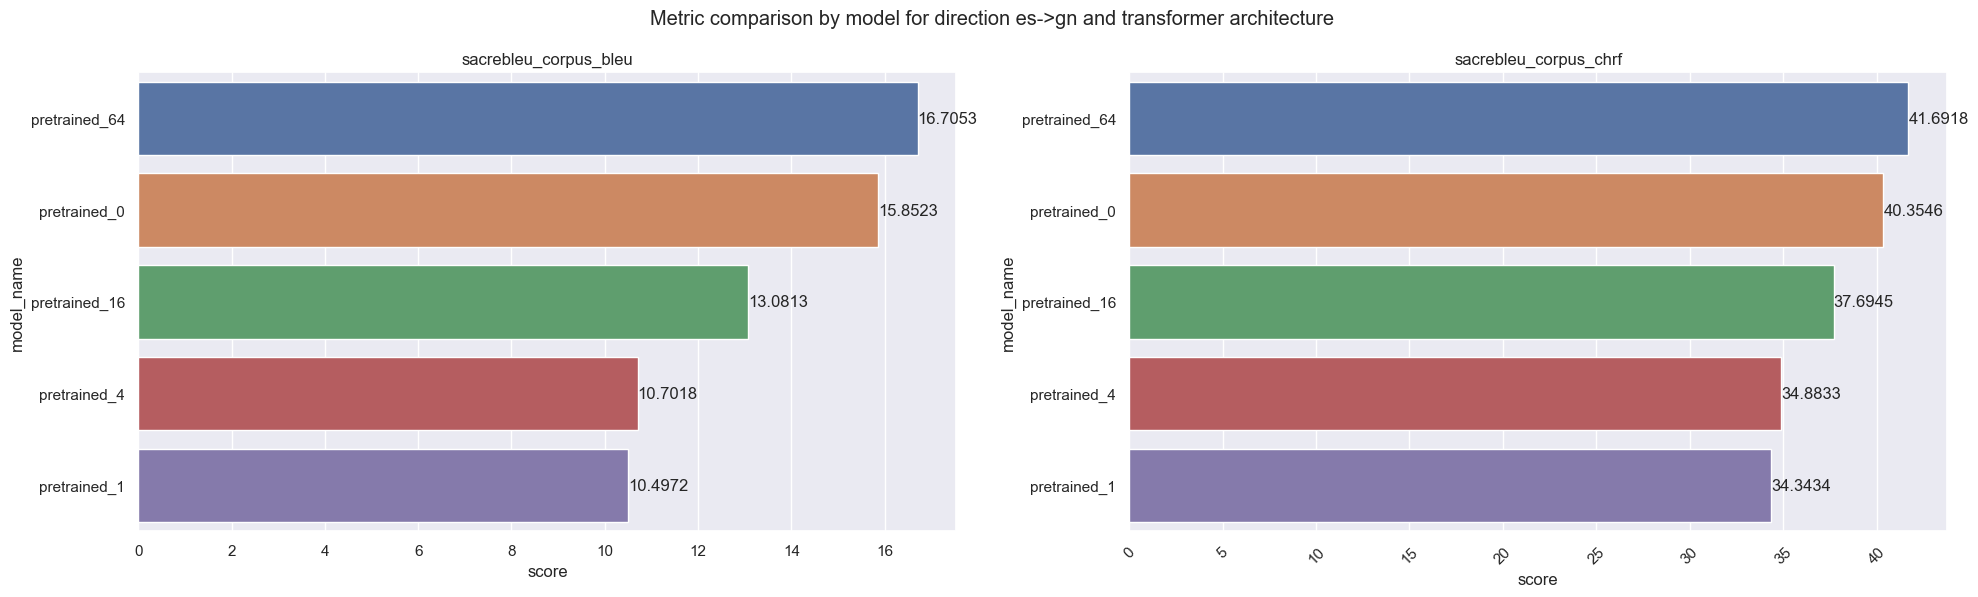

In [199]:
pretrained_transformer_es_gn_df['model_name'] = pretrained_transformer_es_gn_df['pretraining_epochs'].map(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

### **4. All**

#### **4.1. Default Pretraining**

In [200]:
DEFAULT_RESULTS_ALL_CSV = os.path.join(PRETRAINING_FOLDER, 'default_pretraining_all.csv')

In [201]:
results_df = pd.read_csv(DEFAULT_RESULTS_ALL_CSV)
results_without_pretraining = results_grammar_df[results_grammar_df['pretraining_epochs']=='0']
results_df = pd.concat([results_df, results_without_pretraining], axis=0)

results_df = shift_epochs_from_epoch(results_df, from_=10)

results_df['date'] = pd.to_datetime(results_df['date'])
results_df = extract_epochs_from_name(results_df)

In [202]:
default_ancora_s2s_gn_es_df = filter_df_by_model(results_df, 's2s', 'gn')
default_ancora_s2s_es_gn_df = filter_df_by_model(results_df, 's2s', 'es')
default_ancora_transformer_gn_es_df = filter_df_by_model(results_df, 'transformer', 'gn')
default_ancora_transformer_es_gn_df = filter_df_by_model(results_df, 'transformer', 'es')

##### **S2S (GN -> ES)** 

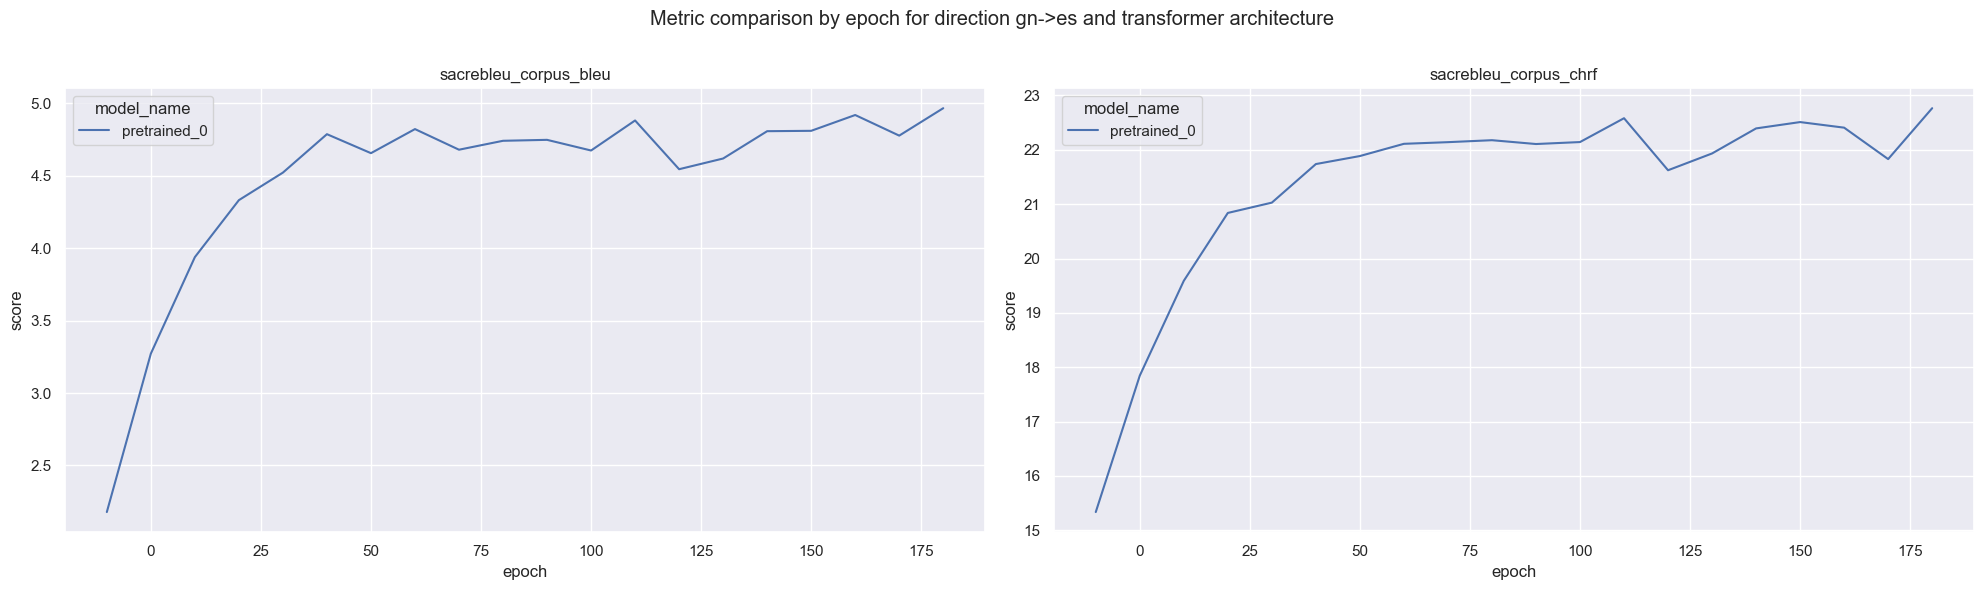

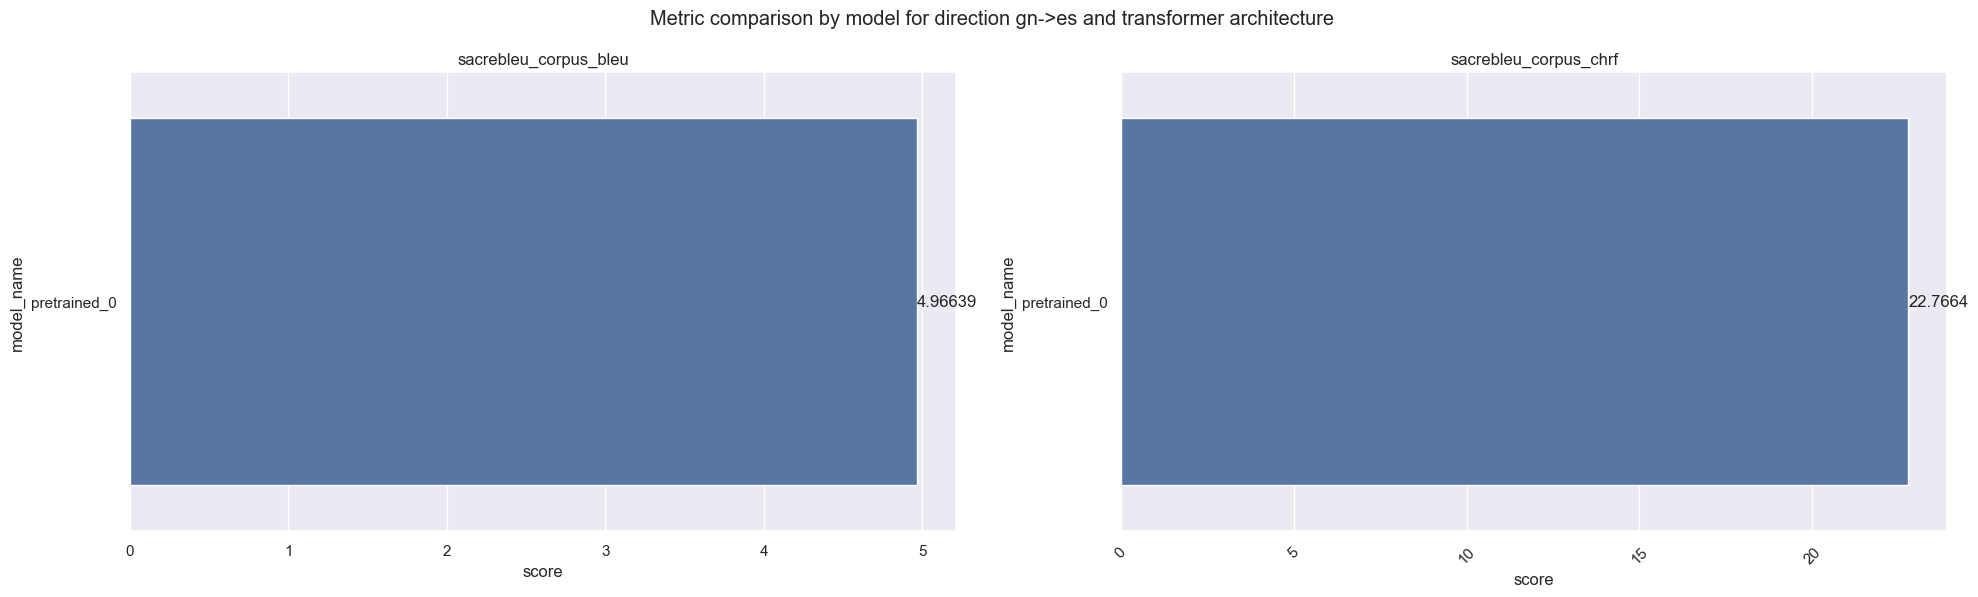

In [203]:
default_ancora_s2s_gn_es_df['model_name'] = list(map(lambda x: f'pretrained_{x}', default_ancora_s2s_gn_es_df['pretraining_epochs'].tolist()))
plots.plot_metric_by_epoch_foreach_model(default_ancora_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_ancora_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **S2S (ES -> GN)** 

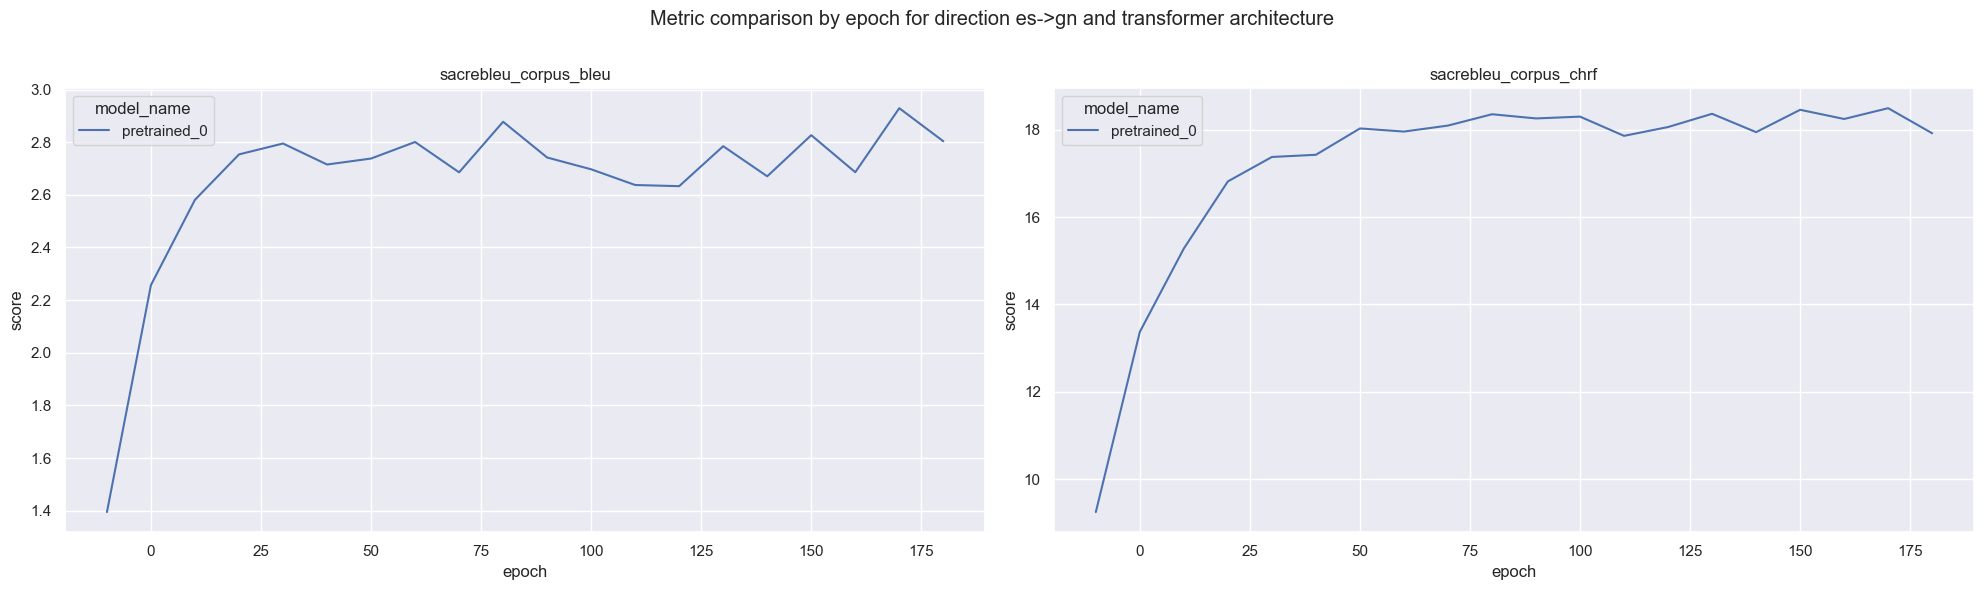

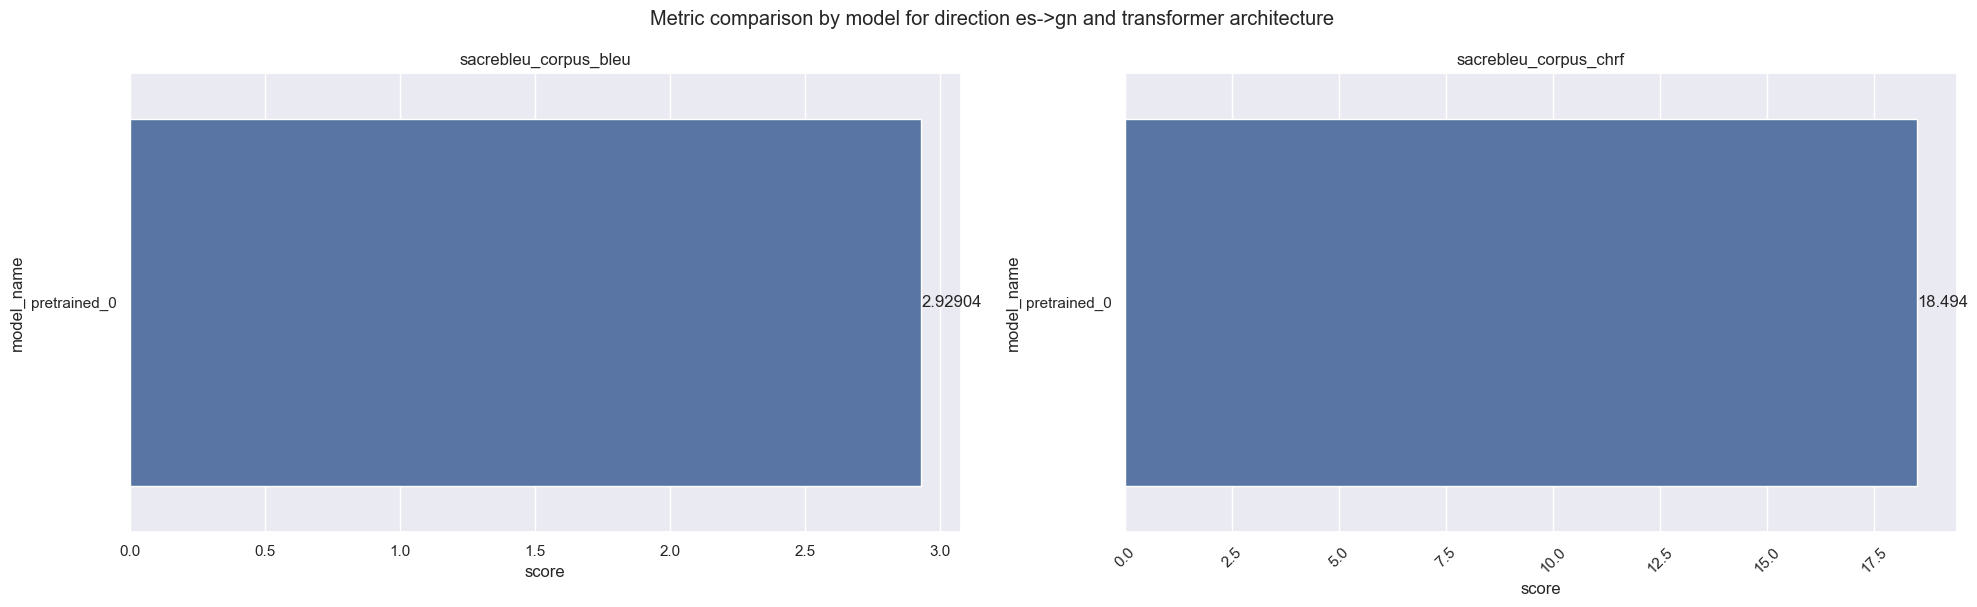

In [204]:
default_ancora_s2s_es_gn_df['model_name'] = default_ancora_s2s_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(default_ancora_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_ancora_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (GN -> ES)** 

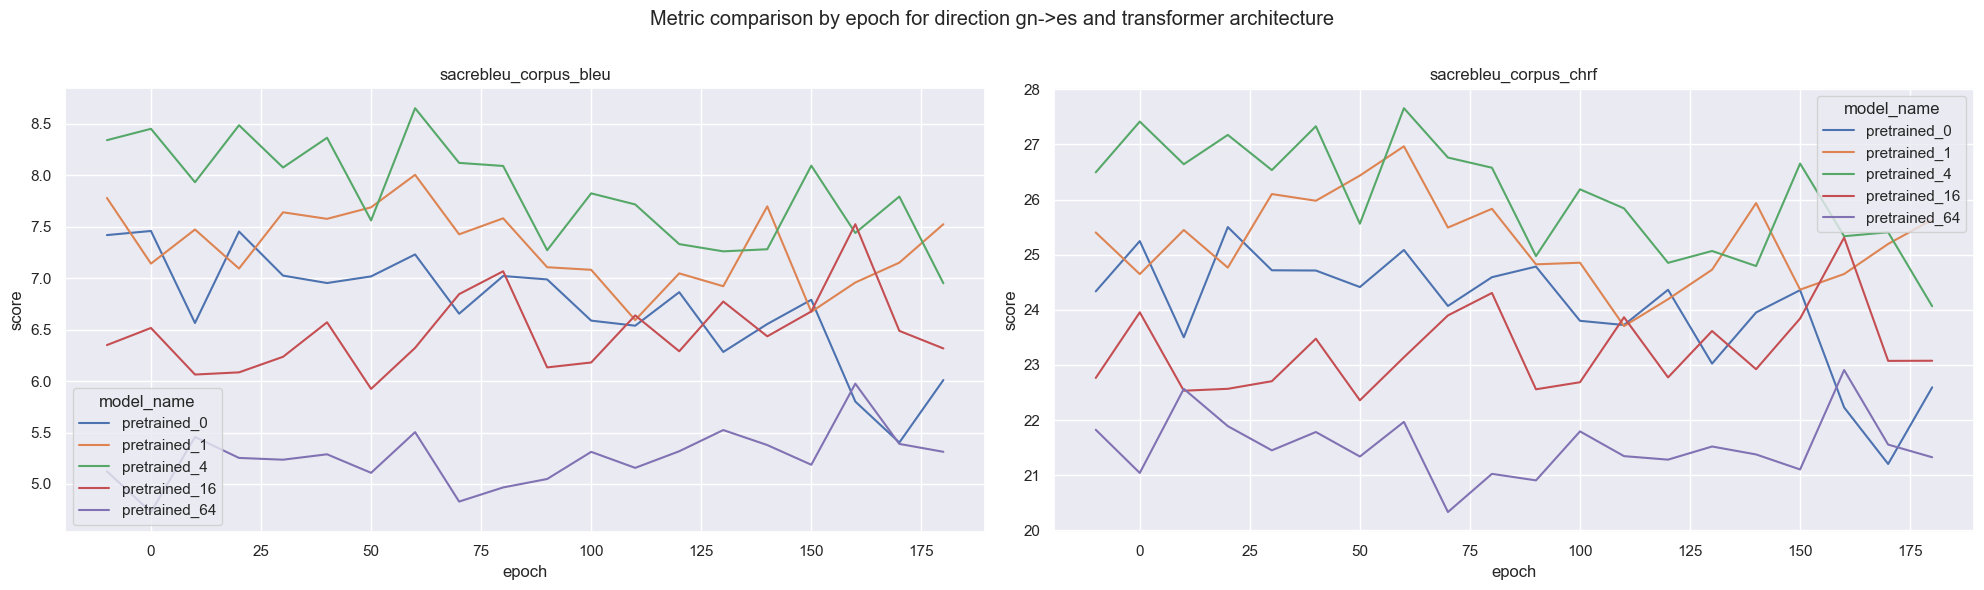

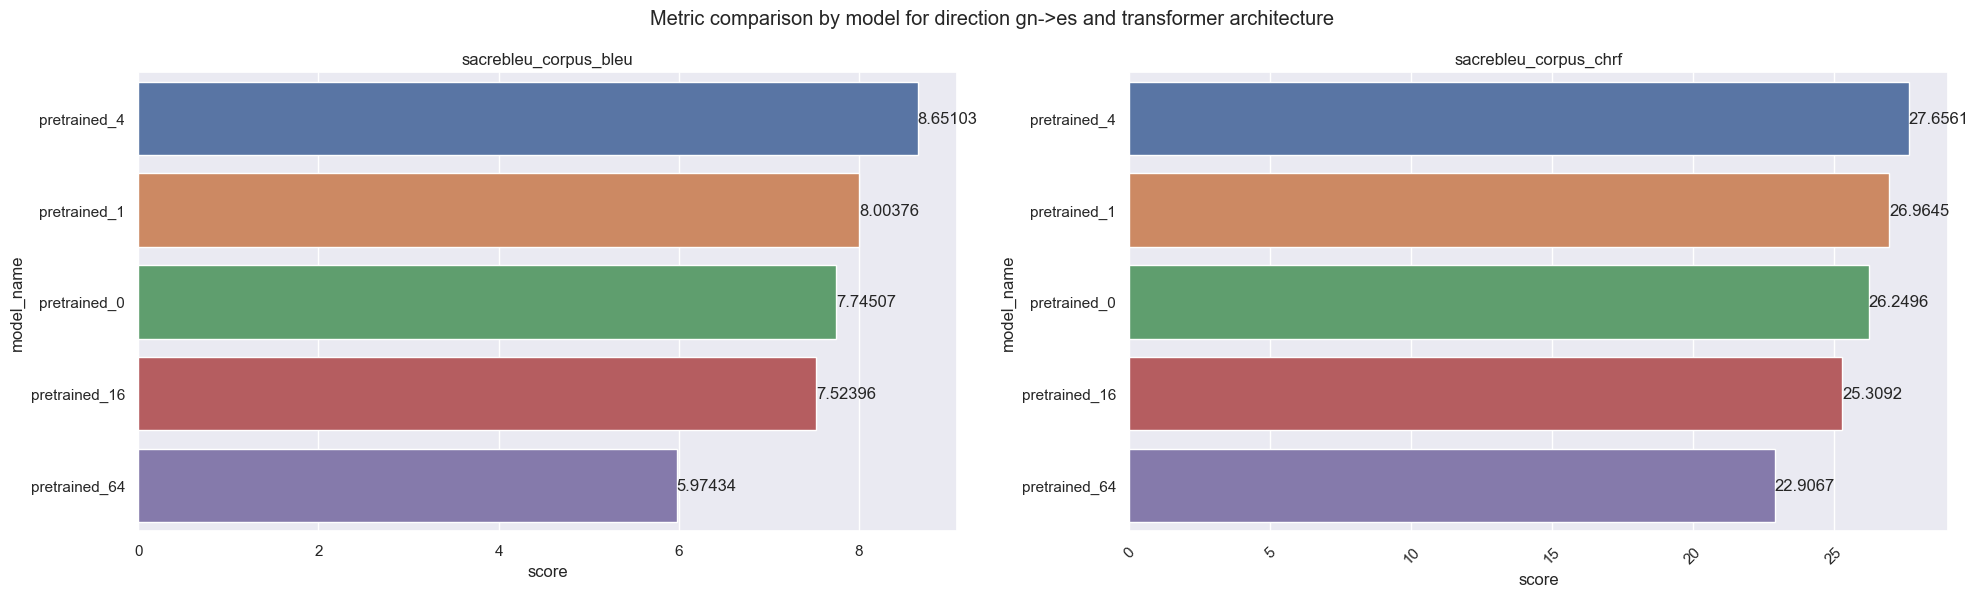

In [205]:
default_ancora_transformer_gn_es_df['model_name'] = default_ancora_transformer_gn_es_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(default_ancora_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_ancora_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (ES -> GN)** 

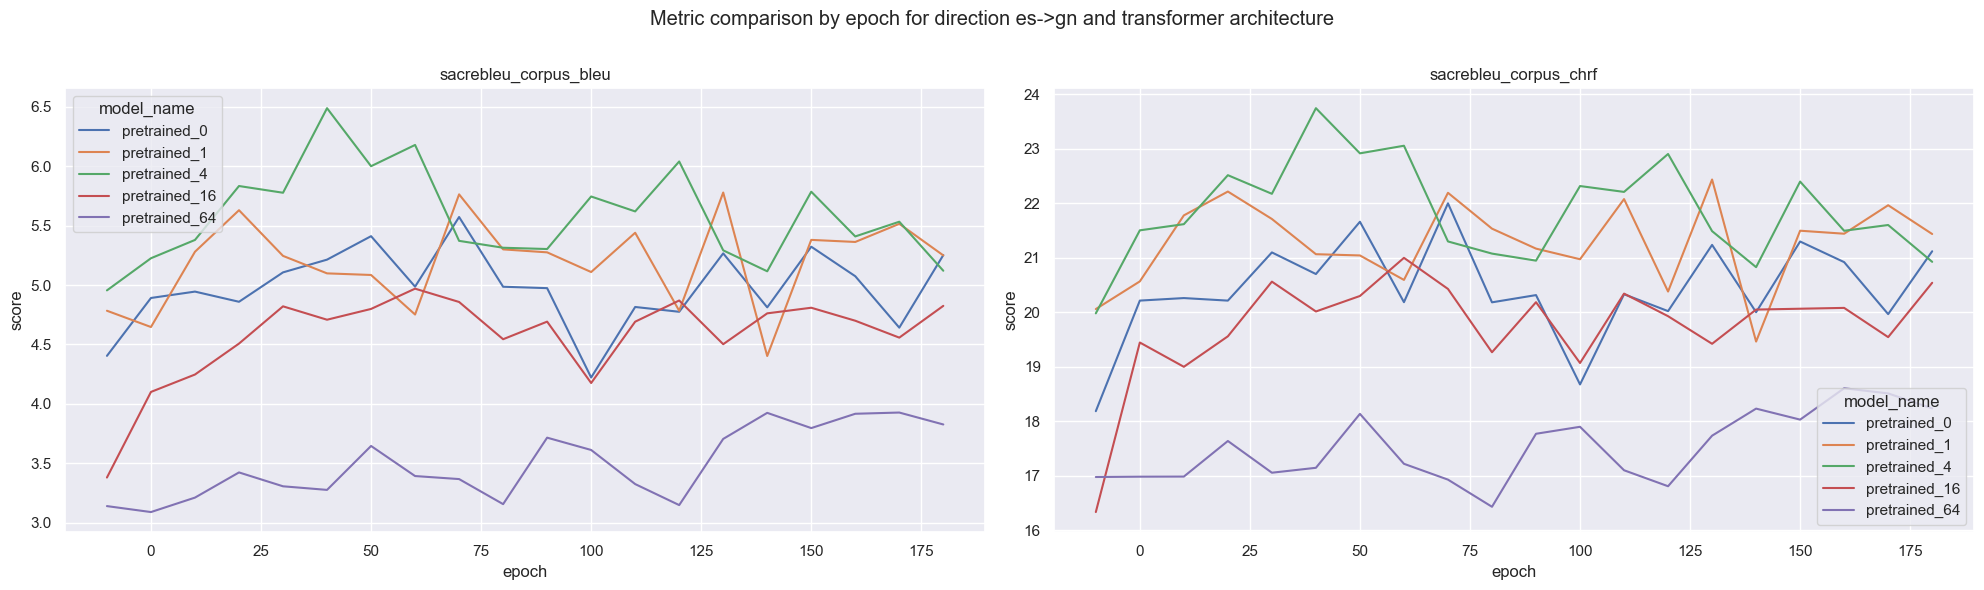

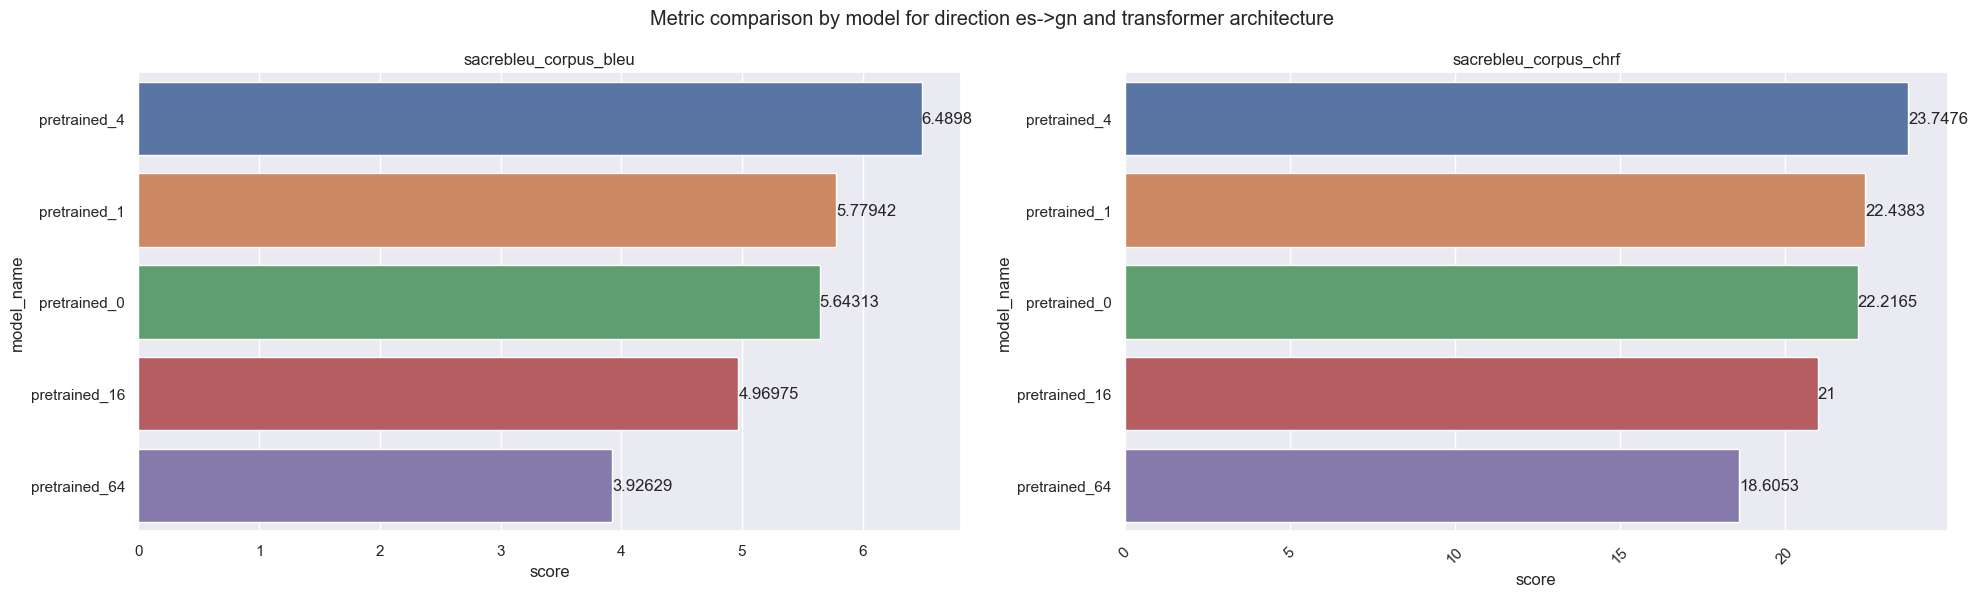

In [206]:
default_ancora_transformer_es_gn_df['model_name'] = default_ancora_transformer_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(default_ancora_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(default_ancora_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

#### **4.2. Finetuned Pretraining**

In [207]:
PRETRAINED_RESULTS_ANCORA_CSV = os.path.join(PRETRAINING_FOLDER, 'finetuned_pretraining_all.csv')

In [208]:
pretrained_results_df = pd.read_csv(PRETRAINED_RESULTS_ANCORA_CSV)
finetuned_results_df = pd.read_csv(FINETUNED_RESULTS_CSV)
pretrained_results_df = pd.concat([pretrained_results_df, finetuned_results_df], axis=0)


pretrained_results_df = shift_epochs_from_epoch(pretrained_results_df, from_=10)
finetuned_results_df = shift_epochs_from_epoch(finetuned_results_df, from_=10)

pretrained_results_df['date'] = pd.to_datetime(pretrained_results_df['date'])
pretrained_results_df = extract_epochs_from_name(pretrained_results_df)

In [209]:
pretrained_s2s_gn_es_df = filter_df_by_model(pretrained_results_df, 's2s', 'gn')
pretrained_s2s_es_gn_df = filter_df_by_model(pretrained_results_df, 's2s', 'es')
pretrained_transformer_gn_es_df = filter_df_by_model(pretrained_results_df, 'transformer', 'gn')
pretrained_transformer_es_gn_df = filter_df_by_model(pretrained_results_df, 'transformer', 'es')

##### **S2S (GN -> ES)** 

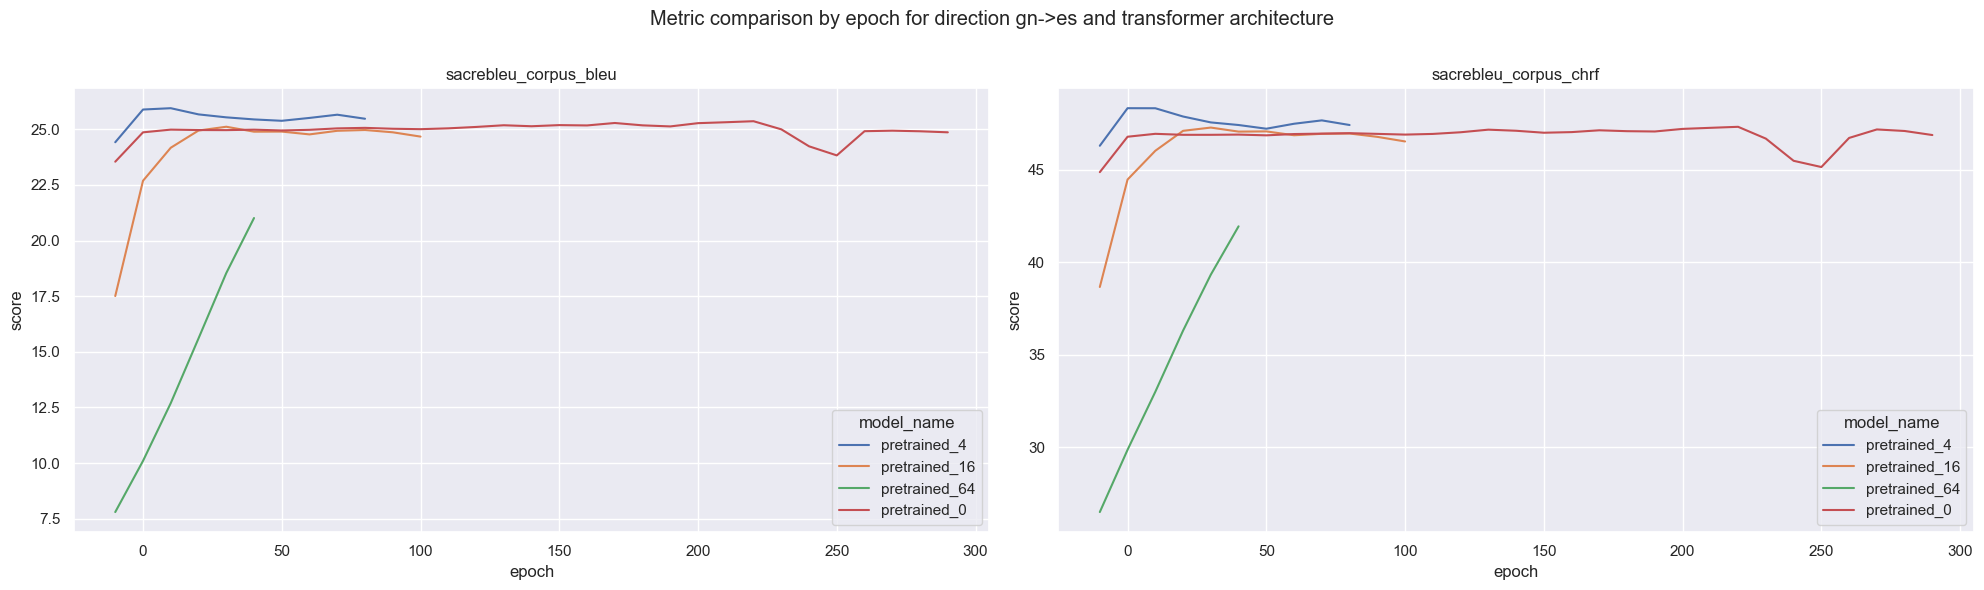

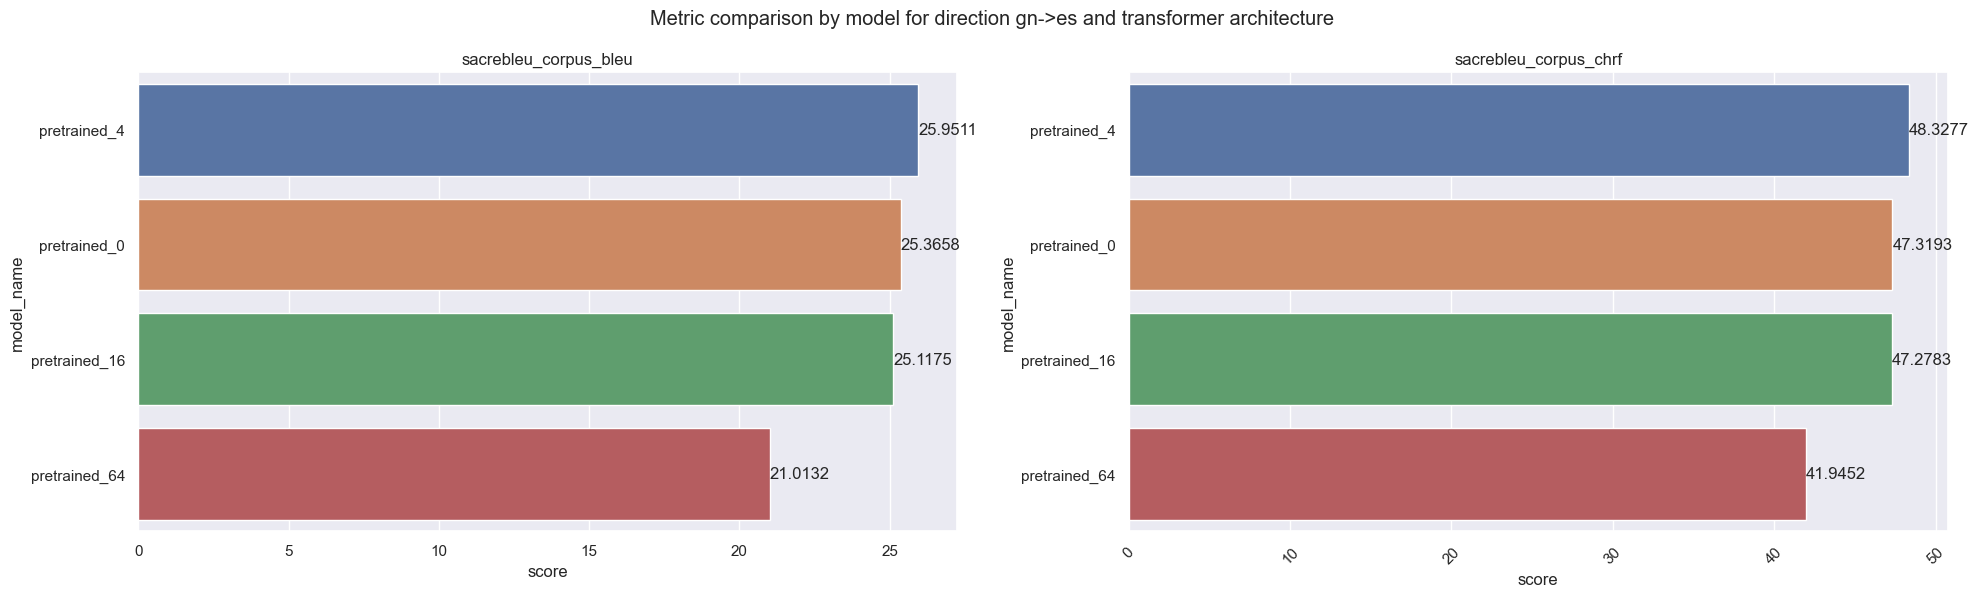

In [210]:
pretrained_s2s_gn_es_df['model_name'] = list(map(lambda x: f'pretrained_{x}', pretrained_s2s_gn_es_df['pretraining_epochs'].tolist()))
plots.plot_metric_by_epoch_foreach_model(pretrained_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_s2s_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **S2S (ES -> GN)** 

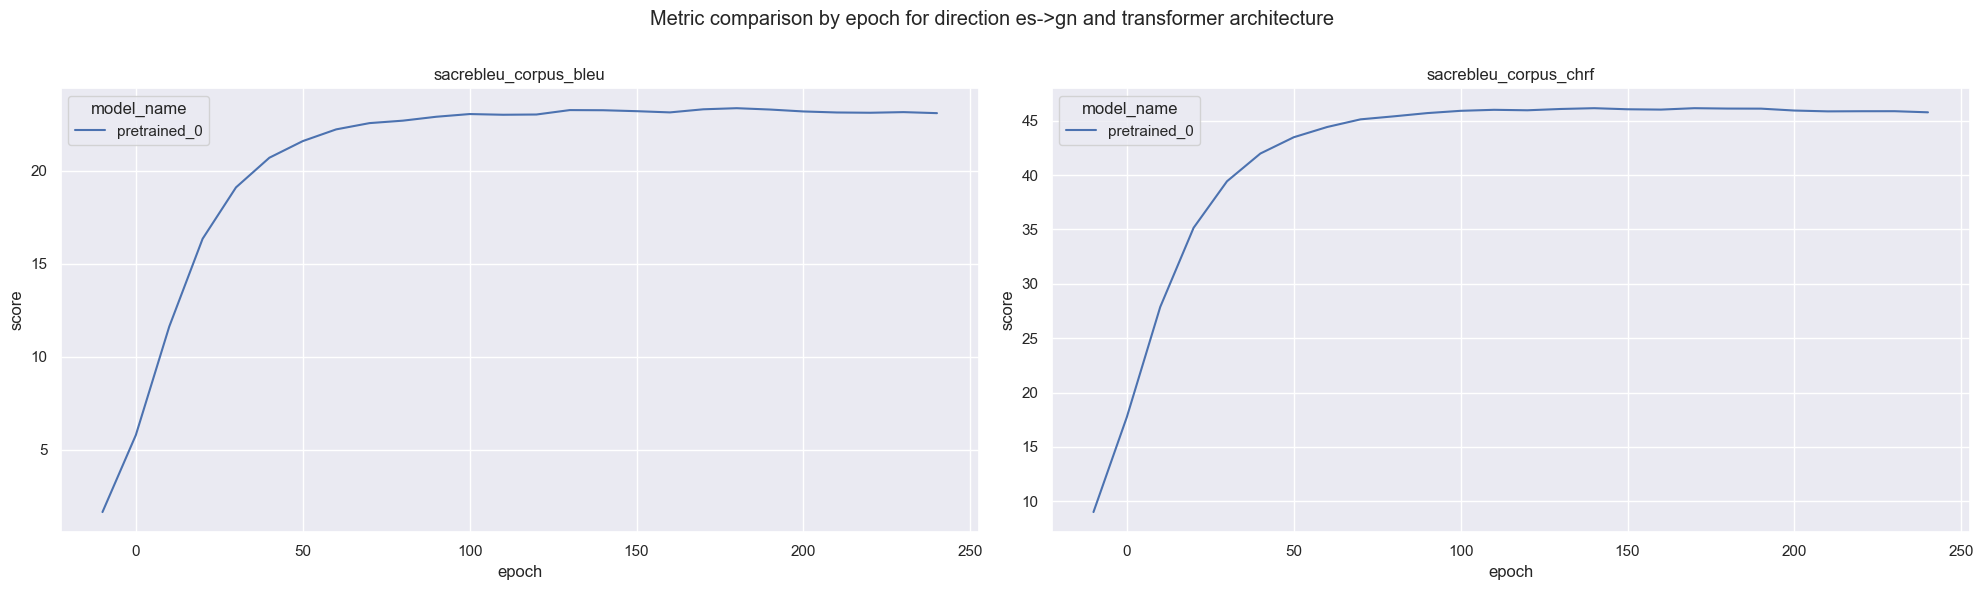

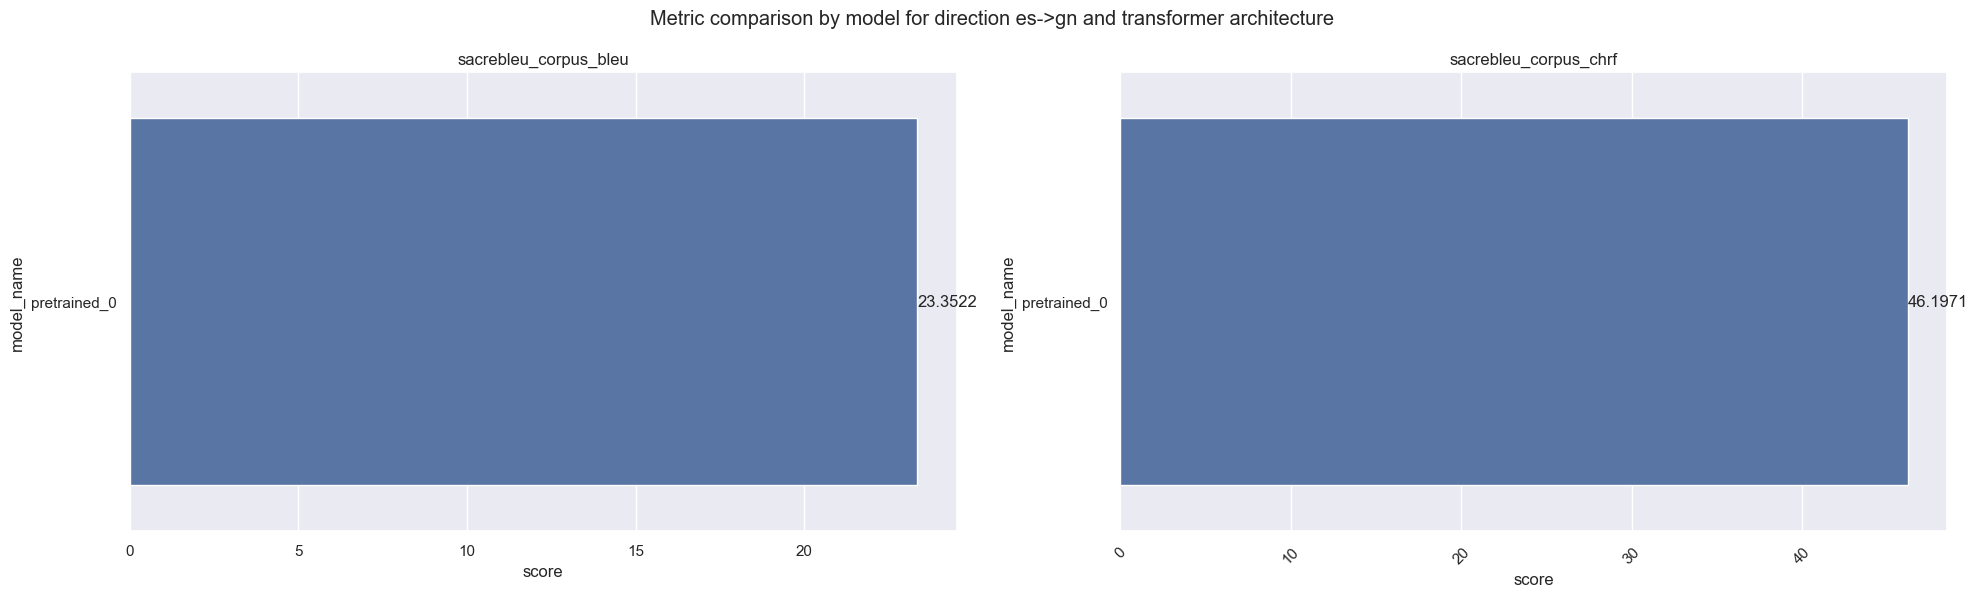

In [211]:
pretrained_s2s_es_gn_df['model_name'] = pretrained_s2s_es_gn_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_s2s_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (GN -> ES)** 

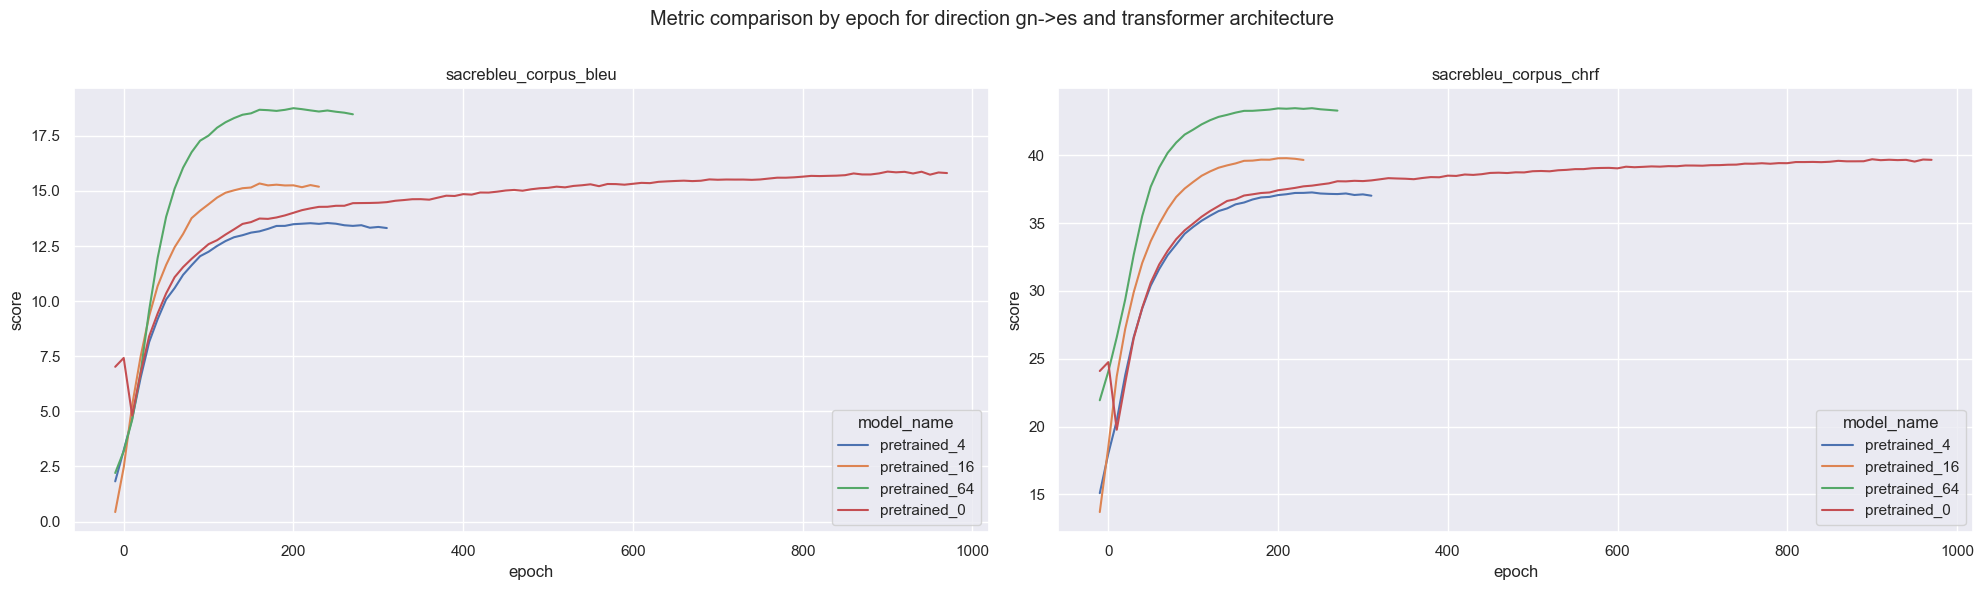

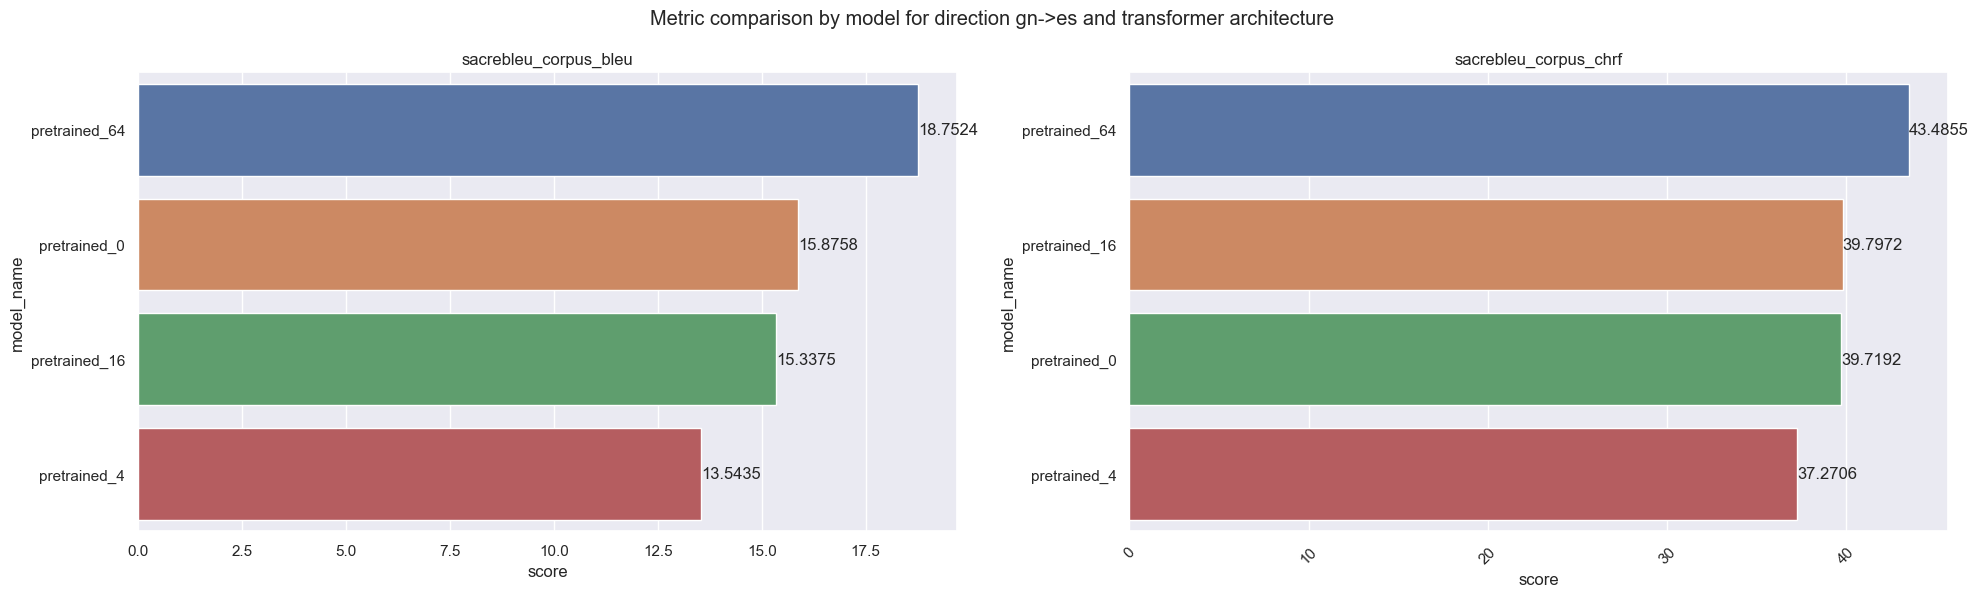

In [212]:
pretrained_transformer_gn_es_df['model_name'] = pretrained_transformer_gn_es_df['pretraining_epochs'].apply(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_transformer_gn_es_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

##### **TRANSFORMER (ES -> GN)** 

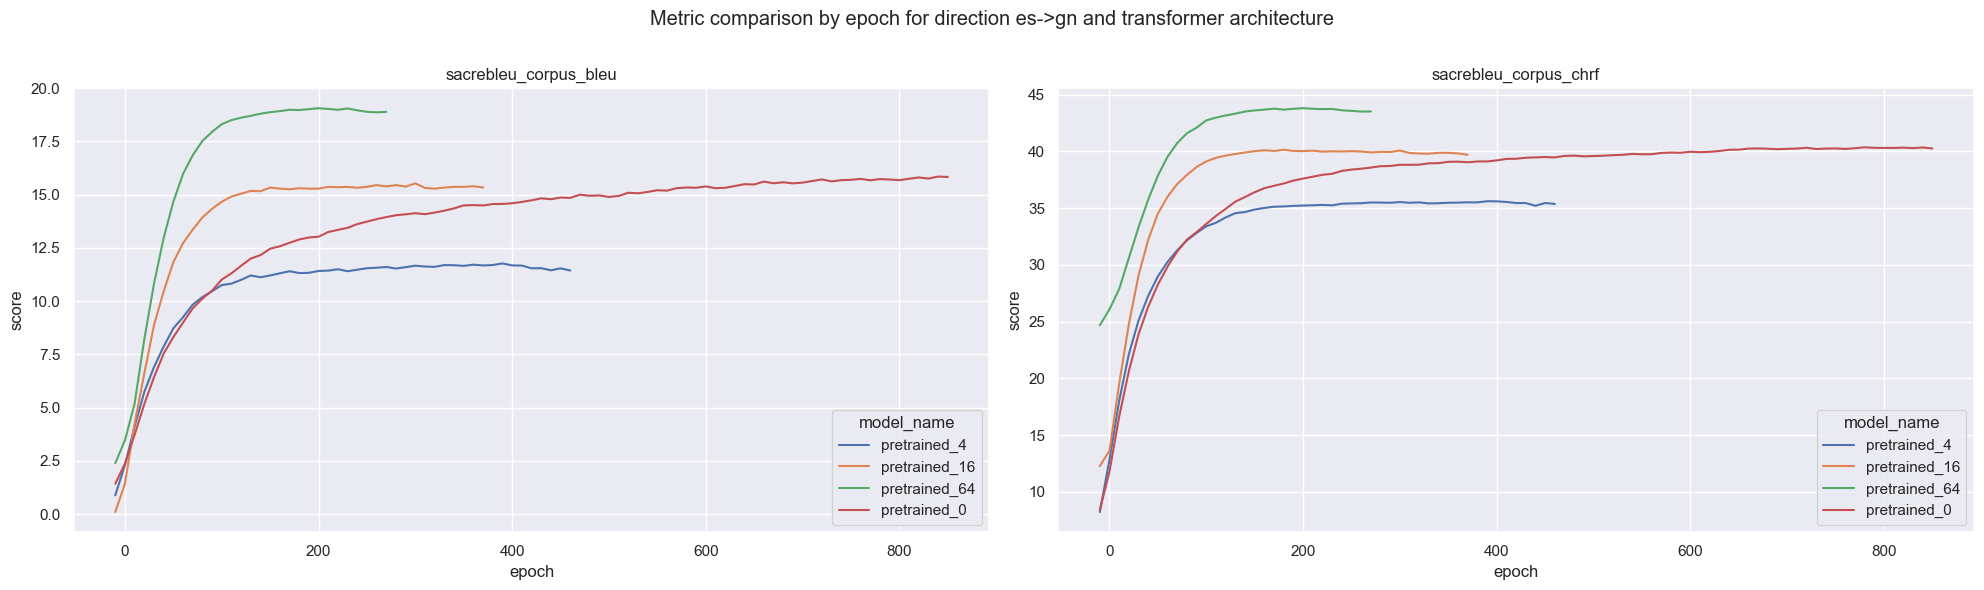

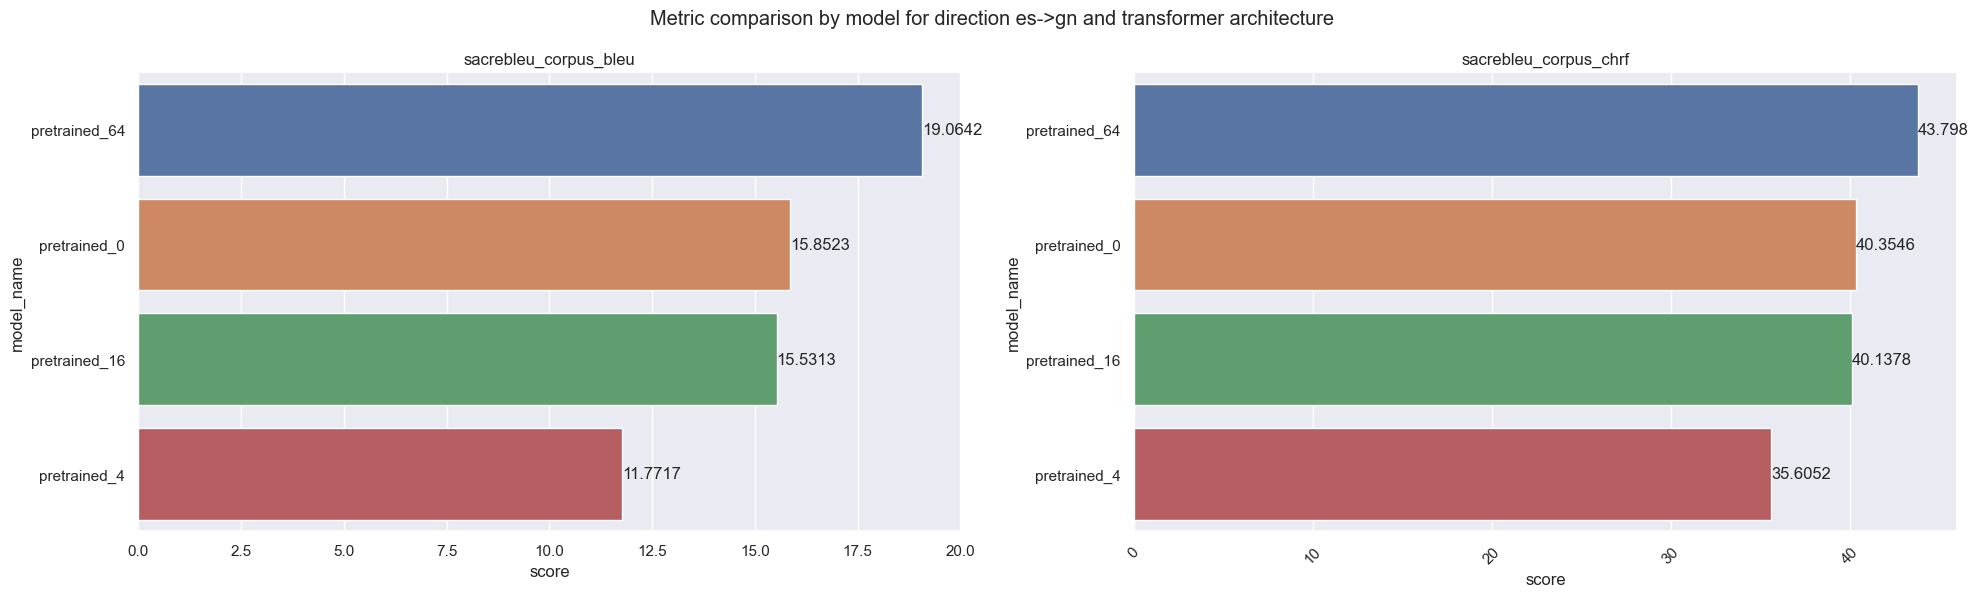

In [213]:
pretrained_transformer_es_gn_df['model_name'] = pretrained_transformer_es_gn_df['pretraining_epochs'].map(lambda x: f'pretrained_{x}')
plots.plot_metric_by_epoch_foreach_model(pretrained_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE, legend=True);
plots.plot_max_score_by_model(pretrained_transformer_es_gn_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=FIGSIZE);

## **Summary**

- Pretraining always enhances default model scores 💹.
- Grammars got the highest score, but only in the best model 🏆.
- Ancora showed better performance than the rest 🤯
- Transformers were the hardest to beat 🤖.
- Training with all subsets is always better than without any 👨‍👩‍👧‍👧.